# Settings

In this notebook we work with the problem of multi-class classification, that is, the correct assignment of an object to one of the classes. Our goal is to achieve high accuracy of assignment to the correct category. We will use the widely used transfer learning method.


Transfer learning is a machine learning technique that uses a pre-trained model. In this approach, a model trained on one data is used or retrained for use with another set of data. By using transfer learning, you can achieve significantly higher classification accuracy, especially when the available data set is limited.

Before running the code, we need to make sure that we are using the GPU. We plan to work with a convolutional neural network, and using a GPU allows us to reduce training time by several times.

In [1]:
# display information about available GPU devices
!nvidia-smi

Fri Jan 19 22:59:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Import libraries

In [2]:
# Visualization purpose
!pip install tensorboardX
!pip install tensorboard
!pip install tensorboard-plugin-customizable-plots

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 7.6 MB/s eta 0:00:00


In [3]:
!pip install split-folders
!pip install optuna
!pip install --upgrade nvidia-ml-py3
!pip install codecarbon


  Preparing metadata (setup.py) ... - \ done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19189 sha256=dc49c8efb435a766ce28c7746068101f3557812c28743f5f61f241cd746dfb13
  Stored in directory: /root/.cache/pip/wheels/5c/d8/c0/46899f8be7a75a2ffd197a23c8797700ea858b9b34819fbf9e
Successfully built nvidia-ml-py3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.0/179.0 kB 4.6 MB/s eta 0:00:00


In [4]:
import os
import shutil
import splitfolders
from pathlib import Path
import imghdr
import numpy as np
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt 
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from codecarbon import EmissionsTracker


import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Description of the data set

The set used has about 22,000 images of various types of waste, divided into 10 different categories - metal, glass, biological waste, etc.


# Data Preprcessing

In [5]:
prepare_data_emission_tracker = EmissionsTracker()
prepare_data_emission_tracker.start()

[codecarbon INFO @ 23:01:16] [setup] RAM Tracking...
[codecarbon INFO @ 23:01:16] [setup] GPU Tracking...
[codecarbon INFO @ 23:01:16] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 23:01:16] [setup] CPU Tracking...
[codecarbon WARNING @ 23:01:16] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 23:01:17] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 23:01:17] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 23:01:17] >>> Tracker's metadata:
[codecarbon INFO @ 23:01:17]   Platform system: Linux-5.15.133+-x86_64-with-glibc2.35
[codecarbon INFO @ 23:01:17]   Python version: 3.10.10
[codecarbon INFO @ 23:01:17]   CodeCarbon version: 2.3.2
[codecarbon INFO @ 23:01:17]   Available RAM : 31.358 GB
[codecarbon INFO @ 23:01:17]   CPU count: 4
[codecarbon INFO @ 23:01:17]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 23:01:17]   GPU

In [6]:
data_dir = '/kaggle/input/garbage-classification-v2/'

Cleaning the working directory if there are any files in it

In [7]:
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working'
remove_folder_contents(folder_path)
# os.rmdir(folder_path)

Copying the dataset to the working directory to allow data cleaning

In [8]:
shutil.copytree(data_dir, '/kaggle/working/dataset')

[codecarbon INFO @ 23:01:35] Energy consumed for RAM : 0.000049 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:01:35] Energy consumed for all GPUs : 0.000081 kWh. Total GPU Power : 19.501651580974347 W
[codecarbon INFO @ 23:01:35] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:01:35] 0.000308 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:01:50] Energy consumed for RAM : 0.000098 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:01:50] Energy consumed for all GPUs : 0.000163 kWh. Total GPU Power : 19.50298934034416 W
[codecarbon INFO @ 23:01:50] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:01:50] 0.000615 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:02:05] Energy consumed for RAM : 0.000147 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:02:05] Energy consumed for all GPUs : 0.000243 kWh. Total GPU Power : 19.4316093159

'/kaggle/working/dataset'

In [9]:
data_dir  = '/kaggle/working/dataset'

In [10]:
experiment_name = "Transfer Learning"

The Tensorflow library that we are going to use does not support some image formats, in addition, the dataset may have corrupted or non-image files. Let's pre-clean the dataset.

In [11]:
count=0
image_extensions = [".png", ".jpg"] 
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        if img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)
            count+=1
print(f"Removed {count} images")

/kaggle/working/dataset/paper/paper_1068.jpg is not an image
/kaggle/working/dataset/paper/paper_1068.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/paper/paper_964.jpg is not an image
/kaggle/working/dataset/paper/paper_964.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/paper/paper_2784.jpg is a webp, not accepted by TensorFlow
/kaggle/working/dataset/paper/paper_1082.jpg is not an image
/kaggle/working/dataset/paper/paper_1082.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/paper/paper_1516.jpg is not an image
/kaggle/working/dataset/paper/paper_1516.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/paper/paper_2779.jpg is not an image
/kaggle/working/dataset/paper/paper_2779.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/paper/paper_3044.jpg is not an image
/kaggle/working/dataset/paper/paper_3044.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/paper/paper_2706.jpg is not an 

To train the model, you will need to divide the data into several samples, so we will create folders for them

In [12]:
os.mkdir('data')

In [13]:
os.chdir('data')

In [14]:
os.getcwd()

'/kaggle/working/data'

In [15]:
os.mkdir('train')
os.mkdir('test')
os.mkdir('val')

In [16]:
os.chdir('/kaggle/working/')

In [17]:
os.getcwd()

'/kaggle/working'

Let's set a random value for reproducibility of the result. In particular, when splitting the dataset randomly (as in the following block of code), a fixed SEED value ensures that we get exactly the same split of data next time.

In [18]:
SEED = 42

Let's divide the data from the dataset into three folders - for training and test samples.

In [19]:
splitfolders.ratio("/kaggle/working/dataset", output = 'data', seed = SEED, ratio = (.8,.1,.1), group_prefix = None)

Copying files: 5588 files [00:00, 5530.96 files/s][codecarbon INFO @ 23:04:50] Energy consumed for RAM : 0.000685 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:04:50] Energy consumed for all GPUs : 0.001135 kWh. Total GPU Power : 19.474971118186897 W
[codecarbon INFO @ 23:04:50] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:04:50] 0.004299 kWh of electricity used since the beginning.
Copying files: 23584 files [00:04, 5657.89 files/s]


In [20]:
data_dir

'/kaggle/working/dataset'

You can now delete the unused dataset folder to save space.

In [21]:
try:
    shutil.rmtree(data_dir)
except OSError as e:
    print("Error: %s : %s" % (data_dir, e.strerror))

Setting paths to training and test data

In [22]:
train_path = '/kaggle/working/data/train'
val_path = '/kaggle/working/data/val'
test_path = '/kaggle/working/data/test'

Visualization of data from a dataset

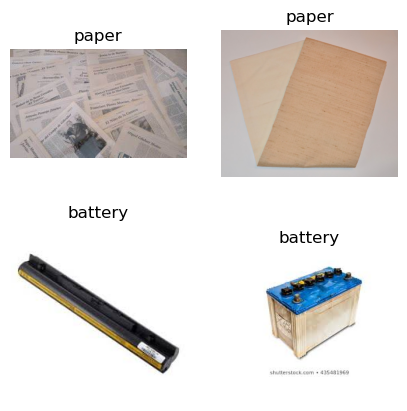

In [23]:
fig, axes = plt.subplots(2, 2, figsize = (5,5)) #выведем 4 изображения
axes = axes.ravel() 

for i in np.arange(0, 4): 

    category = random.choice(os.listdir(train_path)) #случайный выбор класса
    class_dir = os.path.join(train_path, category)

    image = random.choice(os.listdir(class_dir)) #cлучайный выбор изображения из класса
 
    img = plt.imread(os.path.join(class_dir,image))
    axes[i].imshow( img )
    axes[i].set_title(category) 
    axes[i].axis('off')

Let's look at the distribution of data between classes.

In [24]:
total = 0
for category in os.listdir(train_path):
    count= 0
    for image in os.listdir(train_path + "/" + category):
        count += 1
        total +=1
    print(str(category).title() + ": " + str(count))  
print(f"\nTotal number of train images: {total}")

Clothes: 4260
Paper: 2169
Glass: 3272
Cardboard: 1864
Metal: 1494
Biological: 788
Shoes: 1581
Plastic: 2013
Trash: 667
Battery: 756

Total number of train images: 18864


It is noticeable that in some classes the number of images differs several times. Let's visualize the distribution of classes for clarity.

In [25]:
# class names
class_names = sorted(os.listdir(train_path))
class_names

['battery',
 'biological',
 'cardboard',
 'clothes',
 'glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash']

In [26]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]
class_dis

[756, 788, 1864, 4260, 3272, 1494, 2169, 2013, 1581, 667]

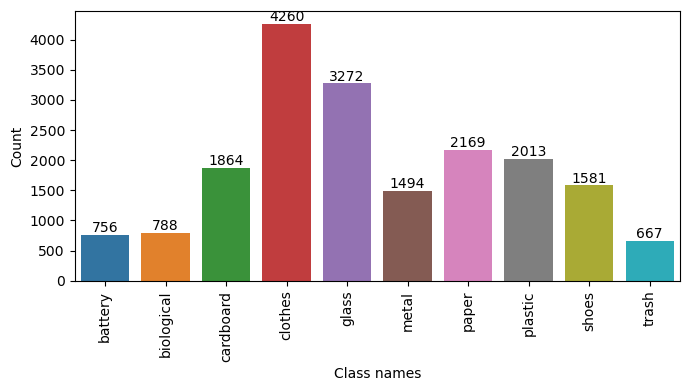

In [27]:
DF = pd.DataFrame(columns=['Class names','Count'])
DF['Class names']=class_names
DF['Count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='Class names', y='Count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

A situation where one or more classes contain a significantly larger number of images is called class imbalance. In our situation, it is natural and determined by the specifics of the data. Thus, there are many more varieties of clothing or glass objects than batteries. However, this may negatively affect the training results of the model and cause it to be biased towards the largest class (that is, it will be much worse at classifying smaller classes). There are different approaches to solving this problem, the applicability of which depends on the problem being solved. We will use the method of insufficient sampling (*random undersampling*), which consists of randomly excluding some examples from large classes.

Excluding some random images from the training data

In [28]:
for category in os.listdir(train_path):
    count = 0
    delete = 0
    for image in os.listdir(train_path + '/'  + category):
        count += 1
        while count > 1000:
            random_image = random.choice(os.listdir(train_path + '/' + category)) 
            delete_image = train_path + '/'  + category +  '/' + random_image
            os.remove(delete_image)
            delete+=1
            count-=1
           
    print(f'Deleted {delete} in {category}')


Deleted 3260 in clothes
Deleted 1169 in paper


[codecarbon INFO @ 23:05:05] Energy consumed for RAM : 0.000734 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:05:05] Energy consumed for all GPUs : 0.001216 kWh. Total GPU Power : 19.48741829391222 W
[codecarbon INFO @ 23:05:05] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:05:05] 0.004607 kWh of electricity used since the beginning.


Deleted 2272 in glass
Deleted 864 in cardboard
Deleted 494 in metal
Deleted 0 in biological
Deleted 581 in shoes
Deleted 1013 in plastic
Deleted 0 in trash
Deleted 0 in battery


We limited the number of images in large classes to 1000. Let's see what the class distribution looks like now

In [29]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]

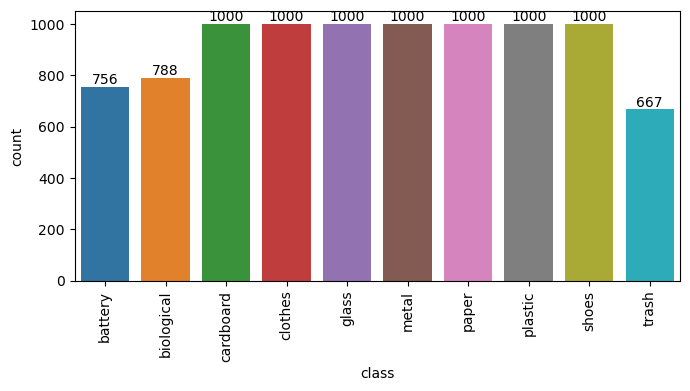

In [30]:
DF = pd.DataFrame(columns=['class','count'])
DF['class']=class_names
DF['count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='class', y='count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

The data distribution now looks much better, although some image classes are still quite sparse. We will try to solve this problem using augmentation methods that we integrate into the model.

In [31]:
data_path = '/kaggle/working/data'

To train a neural network, it is necessary to ensure unification of image sizes. To do this, let’s find the average width and height of images in the entire dataset.

In [32]:
width = []
height = []
from PIL import Image
import numpy as np

for dirname in os.listdir(data_path):
    for category in os.listdir(data_path + '/' + dirname):
        for image in os.listdir(data_path + '/' + dirname + '/' + category):
            img = Image.open(data_path + '/' + dirname + '/' + category + '/' + image)
            width.append(img.width)
            height.append(img.height)

print('Mean width: {:.4f}'.format(np.mean(width)))
print('Mean Height: {:.4f}'.format(np.mean(height)))

Mean width: 416.3352
Mean Height: 398.3283


Let's set the size of the input data (image size) taking into account the found average values

In [33]:
IMG_SIZE = (400, 400)

Let's set the size of the data package for loading images into the model in parts

In [34]:
BATCH_SIZE = 32


Create a SummaryWriter instance to write logs

In [35]:
writer = SummaryWriter()

Previously, we divided the entire amount of data into three sets. Now you need to prepare them for working with the model - distribute them into packages and add labels to them. Data packets generated from the train folder, constituting 80% of the total number of images, will be used to train the model, from the val(10%) folder - for checking during training and adjusting parameters, and from the test folder - to evaluate the accuracy of the model on new data not used during training.


In [36]:
train_data = tf.keras.utils.image_dataset_from_directory(train_path,
                                                         image_size=IMG_SIZE,
                                                         label_mode='categorical',
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True,
                                                         seed=SEED)

Found 9211 files belonging to 10 classes.


In [37]:
test_data = tf.keras.utils.image_dataset_from_directory(test_path,
                                                        image_size=IMG_SIZE,
                                                        label_mode='categorical',
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=False)

Found 2366 files belonging to 10 classes.


In [38]:
validation_data = tf.keras.utils.image_dataset_from_directory(val_path,
                                                              image_size=IMG_SIZE,
                                                              label_mode='categorical',
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=True,
                                                              seed=SEED)

Found 2354 files belonging to 10 classes.


Create directories for train and test logs and write logs to it 

In [39]:
train_log_dir = os.path.join("logs", experiment_name, "train")
test_log_dir = os.path.join("logs", experiment_name, "test")

os.makedirs(train_log_dir, exist_ok=True)
os.makedirs(test_log_dir, exist_ok=True)

train_writer = SummaryWriter(train_log_dir)
test_writer = SummaryWriter(test_log_dir)


In [40]:

prepare_data_emissions: float = prepare_data_emission_tracker.stop()
print(f"Prepare Data Carbon Emissions: {prepare_data_emissions} kg")

[codecarbon INFO @ 23:05:16] Energy consumed for RAM : 0.000770 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:05:16] Energy consumed for all GPUs : 0.001291 kWh. Total GPU Power : 24.96139876720922 W
[codecarbon INFO @ 23:05:16] Energy consumed for all CPUs : 0.002785 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:05:16] 0.004846 kWh of electricity used since the beginning.


Prepare Data Carbon Emissions: 0.0013835131276409966 kg


# Building the model

When selecting a model, we examined the classification models available in Keras with pre-trained weights on the public ImageNet dataset, which includes about 1000 categories of various images (https://keras.io/api/applications/).
For our task, the most important parameter is the classification accuracy. Based on the accuracy values presented in the table (acc1, percentage of correct answers), the ResNet101 model was selected.


In [41]:
develop_model_emission_tracker = EmissionsTracker()
develop_model_emission_tracker.start()

[codecarbon INFO @ 23:05:17] [setup] RAM Tracking...
[codecarbon INFO @ 23:05:17] [setup] GPU Tracking...
[codecarbon INFO @ 23:05:17] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 23:05:17] [setup] CPU Tracking...
[codecarbon WARNING @ 23:05:17] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 23:05:18] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 23:05:18] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 23:05:18] >>> Tracker's metadata:
[codecarbon INFO @ 23:05:18]   Platform system: Linux-5.15.133+-x86_64-with-glibc2.35
[codecarbon INFO @ 23:05:18]   Python version: 3.10.10
[codecarbon INFO @ 23:05:18]   CodeCarbon version: 2.3.2
[codecarbon INFO @ 23:05:18]   Available RAM : 31.358 GB
[codecarbon INFO @ 23:05:18]   CPU count: 4
[codecarbon INFO @ 23:05:18]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 23:05:18]   GPU

Loading the model

In [42]:
base_model = tf.keras.applications.resnet.ResNet101(include_top=False,
                                                   weights='imagenet', 
                                                   input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

171446536/171446536 [==============================] - 1s 0us/step


Let's see what the architecture of the pretrained model looks like

In [43]:
base_model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 406, 406, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 200, 200, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

The architecture of the model we are using already has a Rescale layer, so we may not include an additional image normalization layer in our model.ь.

Let's freeze all layers of the pretrained model so that its parameters do not change during training.

In [44]:
base_model.trainable = False

Let's create a data augmentation layer to improve classification accuracy. This layer is active only during model training.

In [45]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.RandomRotation(0.2), 
                                         tf.keras.layers.RandomZoom(0.2),
                                         tf.keras.layers.RandomHeight(0.2),
                                         tf.keras.layers.RandomWidth(0.2),],
                                         name ="data_augmentation")

Let's see how this layer works with images from the training set.

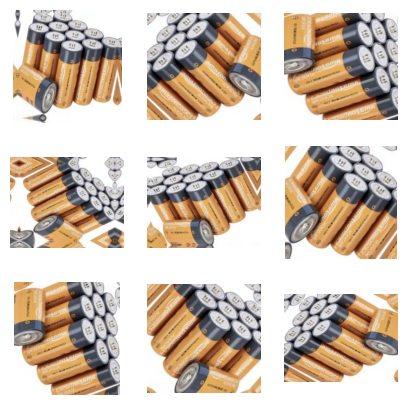

In [46]:
for image, _ in train_data.take(1):  
    plt.figure(figsize=(5, 5))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Let's combine the model with the augmentation layer, and also add several layers:

* GlobalAveragePooling2D layer, which calculates the arithmetic average over all channels to combine feature maps
* A fully connected layer with 128 neurons and a Dropout layer, which excludes some neurons from the previous fully connected layer with a given probability, thereby reducing the possible effect of overfitting.
* Output fully connected layer with the number of outputs corresponding to the number of classes of our data.

In [47]:
name="ResNet101"

ResNet101_model=tf.keras.Sequential([tf.keras.Input(shape=(None, None, 3), name="input_layer"),
                    data_augmentation,
                    base_model,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(len(class_names), activation='softmax')
                    ], name=name)

For training, we will define a loss function, an optimizer, and a tracked accuracy metric

In [48]:
ResNet101_model.compile(loss='categorical_crossentropy',
                              optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                              metrics=['accuracy'])

Let's look at the structure of our model

In [49]:
ResNet101_model.summary()

Model: "ResNet101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 resnet101 (Functional)      (None, 13, 13, 2048)      42658176  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                12

The summary already shows the advantage of using a pre-trained model - out of more than 20 million parameters, only 165 thousand are trainable, which will significantly reduce training time.

While training the models, we will use a callback function to stop training when the metrics being tracked stop improving. After this, we will save the trained model and weights for further use.

In [50]:
# def log_to_tensorboard(epoch, logs):
#         train_writer.add_scalar('loss', logs['loss'], epoch)
#         train_writer.add_scalar('accuracy', logs['accuracy'], epoch)
#         test_writer.add_scalar('val_loss', logs['val_loss'], epoch)
#         test_writer.add_scalar('val_accuracy', logs['val_accuracy'], epoch)
def log_to_tensorboard(epoch, logs):
    train_writer.add_scalar('loss', logs['loss'], epoch)
    train_writer.add_scalar('accuracy', logs['accuracy'], epoch)
    
    # Use get method with a default value of None to avoid KeyError
    val_loss = logs.get('val_loss', None)
    val_accuracy = logs.get('val_accuracy', None)
    
    if val_loss is not None:
        test_writer.add_scalar('val_loss', val_loss, epoch)
    if val_accuracy is not None:
        test_writer.add_scalar('val_accuracy', val_accuracy, epoch)


# Creating a Callback Function
def create_callback(model_name):
    
    # termination of training when accuracy does not improve within 3 epochs
    early_stop = tf.keras.callbacks.EarlyStopping(patience=3,
                                                monitor="val_loss",
                                                mode="min",
                                                verbose=1)

    # decrease in learning rate when the error rate does not decrease over 2 epochs
    reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                              factor=0.2,
                                                              patience=2,
                                                              verbose=1,
                                                              min_lr=0.00001)

    log_to_tensorboard_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: log_to_tensorboard(epoch, logs))
    # saving model
    check_model = tf.keras.callbacks.ModelCheckpoint(model_name + ".h5",
                                                   monitor="val_accuracy",
                                                   mode="max",
                                                   save_best_only=True)
    callback = [early_stop, reduce_learning_rate, check_model, log_to_tensorboard_callback]
    return callback

In [51]:
ResNet101_callback = create_callback(name)

Let's set the number of training epochs

In [52]:
EPOCH=20

Let's train the model

In [53]:
import time
start_time = time.time()
ResNet101_history = ResNet101_model.fit(train_data, 
                                                    epochs=EPOCH, 
                                                    steps_per_epoch=len(train_data),
                                                    validation_data=validation_data, 
                                                    validation_steps=len(validation_data),
                                                    callbacks=ResNet101_callback)

Epoch 1/20


[codecarbon INFO @ 23:05:51] Energy consumed for RAM : 0.000098 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:05:51] Energy consumed for all GPUs : 0.000496 kWh. Total GPU Power : 64.25408805666011 W
[codecarbon INFO @ 23:05:51] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:05:51] 0.000948 kWh of electricity used since the beginning.


  5/288 [..............................] - ETA: 15:16 - loss: 2.6230 - accuracy: 0.1688

[codecarbon INFO @ 23:06:06] Energy consumed for RAM : 0.000147 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:06:06] Energy consumed for all GPUs : 0.000897 kWh. Total GPU Power : 96.22825046707553 W
[codecarbon INFO @ 23:06:06] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:06:06] 0.001575 kWh of electricity used since the beginning.


  9/288 [..............................] - ETA: 15:26 - loss: 2.2791 - accuracy: 0.2500

[codecarbon INFO @ 23:06:21] Energy consumed for RAM : 0.000196 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:06:21] Energy consumed for all GPUs : 0.001305 kWh. Total GPU Power : 98.06573523293017 W
[codecarbon INFO @ 23:06:21] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:06:21] 0.002209 kWh of electricity used since the beginning.


 14/288 [>.............................] - ETA: 14:49 - loss: 1.9736 - accuracy: 0.3549

[codecarbon INFO @ 23:06:36] Energy consumed for RAM : 0.000245 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:06:36] Energy consumed for all GPUs : 0.001715 kWh. Total GPU Power : 98.52759182817543 W
[codecarbon INFO @ 23:06:36] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:06:36] 0.002846 kWh of electricity used since the beginning.


 19/288 [>.............................] - ETA: 14:17 - loss: 1.7904 - accuracy: 0.4095

[codecarbon INFO @ 23:06:51] Energy consumed for RAM : 0.000294 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:06:51] Energy consumed for all GPUs : 0.002126 kWh. Total GPU Power : 98.53781806345519 W
[codecarbon INFO @ 23:06:51] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:06:51] 0.003482 kWh of electricity used since the beginning.


 23/288 [=>............................] - ETA: 14:37 - loss: 1.6900 - accuracy: 0.4293

[codecarbon INFO @ 23:07:06] Energy consumed for RAM : 0.000343 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:07:06] Energy consumed for all GPUs : 0.002537 kWh. Total GPU Power : 98.82861776224472 W
[codecarbon INFO @ 23:07:06] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:07:06] 0.004120 kWh of electricity used since the beginning.


 28/288 [=>............................] - ETA: 14:13 - loss: 1.5642 - accuracy: 0.4766

[codecarbon INFO @ 23:07:21] Energy consumed for RAM : 0.000392 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:07:21] Energy consumed for all GPUs : 0.002949 kWh. Total GPU Power : 98.82138374910998 W
[codecarbon INFO @ 23:07:21] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:07:21] 0.004757 kWh of electricity used since the beginning.


 32/288 [==>...........................] - ETA: 14:03 - loss: 1.4851 - accuracy: 0.5039

[codecarbon INFO @ 23:07:36] Energy consumed for RAM : 0.000441 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:07:36] Energy consumed for all GPUs : 0.003362 kWh. Total GPU Power : 99.21092158967403 W
[codecarbon INFO @ 23:07:36] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:07:36] 0.005396 kWh of electricity used since the beginning.


 37/288 [==>...........................] - ETA: 13:34 - loss: 1.4271 - accuracy: 0.5177

[codecarbon INFO @ 23:07:51] Energy consumed for RAM : 0.000490 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:07:51] Energy consumed for all GPUs : 0.003775 kWh. Total GPU Power : 99.28482239526814 W
[codecarbon INFO @ 23:07:51] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:07:51] 0.006036 kWh of electricity used since the beginning.


 42/288 [===>..........................] - ETA: 13:24 - loss: 1.3697 - accuracy: 0.5365

[codecarbon INFO @ 23:08:06] Energy consumed for RAM : 0.000539 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:08:06] Energy consumed for all GPUs : 0.004189 kWh. Total GPU Power : 99.30724961477569 W
[codecarbon INFO @ 23:08:06] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:08:06] 0.006676 kWh of electricity used since the beginning.


 46/288 [===>..........................] - ETA: 13:11 - loss: 1.3192 - accuracy: 0.5557

[codecarbon INFO @ 23:08:21] Energy consumed for RAM : 0.000588 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:08:21] Energy consumed for all GPUs : 0.004601 kWh. Total GPU Power : 99.02275711511741 W
[codecarbon INFO @ 23:08:21] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:08:21] 0.007314 kWh of electricity used since the beginning.


 51/288 [====>.........................] - ETA: 12:48 - loss: 1.2939 - accuracy: 0.5662

[codecarbon INFO @ 23:08:36] Energy consumed for RAM : 0.000637 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:08:36] Energy consumed for all GPUs : 0.005013 kWh. Total GPU Power : 98.8632989188804 W
[codecarbon INFO @ 23:08:36] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:08:36] 0.007951 kWh of electricity used since the beginning.


 57/288 [====>.........................] - ETA: 12:08 - loss: 1.2297 - accuracy: 0.5877

[codecarbon INFO @ 23:08:51] Energy consumed for RAM : 0.000686 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:08:51] Energy consumed for all GPUs : 0.005424 kWh. Total GPU Power : 98.74315602194561 W
[codecarbon INFO @ 23:08:51] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:08:51] 0.008589 kWh of electricity used since the beginning.


 62/288 [=====>........................] - ETA: 11:51 - loss: 1.1880 - accuracy: 0.5978

[codecarbon INFO @ 23:09:06] Energy consumed for RAM : 0.000734 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:09:06] Energy consumed for all GPUs : 0.005836 kWh. Total GPU Power : 98.89603156436338 W
[codecarbon INFO @ 23:09:06] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:09:06] 0.009227 kWh of electricity used since the beginning.


 66/288 [=====>........................] - ETA: 11:45 - loss: 1.1637 - accuracy: 0.6080

[codecarbon INFO @ 23:09:21] Energy consumed for RAM : 0.000783 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:09:21] Energy consumed for all GPUs : 0.006248 kWh. Total GPU Power : 98.8232995954594 W
[codecarbon INFO @ 23:09:21] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:09:21] 0.009864 kWh of electricity used since the beginning.


 73/288 [======>.......................] - ETA: 11:06 - loss: 1.1098 - accuracy: 0.6267

[codecarbon INFO @ 23:09:36] Energy consumed for RAM : 0.000832 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:09:36] Energy consumed for all GPUs : 0.006658 kWh. Total GPU Power : 98.63066972646804 W
[codecarbon INFO @ 23:09:36] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:09:36] 0.010501 kWh of electricity used since the beginning.


 79/288 [=======>......................] - ETA: 10:32 - loss: 1.0846 - accuracy: 0.6341

[codecarbon INFO @ 23:09:51] Energy consumed for RAM : 0.000881 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:09:51] Energy consumed for all GPUs : 0.007072 kWh. Total GPU Power : 99.27196403662052 W
[codecarbon INFO @ 23:09:51] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:09:51] 0.011140 kWh of electricity used since the beginning.


 86/288 [=======>......................] - ETA: 9:56 - loss: 1.0543 - accuracy: 0.6432

[codecarbon INFO @ 23:10:06] Energy consumed for RAM : 0.000930 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:10:06] Energy consumed for all GPUs : 0.007481 kWh. Total GPU Power : 98.22632940281592 W
[codecarbon INFO @ 23:10:06] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:10:06] 0.011776 kWh of electricity used since the beginning.


 91/288 [========>.....................] - ETA: 9:47 - loss: 1.0321 - accuracy: 0.6508

[codecarbon INFO @ 23:10:21] Energy consumed for RAM : 0.000979 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:10:21] Energy consumed for all GPUs : 0.007892 kWh. Total GPU Power : 98.65716146500344 W
[codecarbon INFO @ 23:10:21] Energy consumed for all CPUs : 0.003542 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:10:21] 0.012412 kWh of electricity used since the beginning.


 97/288 [=========>....................] - ETA: 9:21 - loss: 1.0090 - accuracy: 0.6585

[codecarbon INFO @ 23:10:36] Energy consumed for RAM : 0.001028 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:10:36] Energy consumed for all GPUs : 0.008304 kWh. Total GPU Power : 99.05734252116326 W
[codecarbon INFO @ 23:10:36] Energy consumed for all CPUs : 0.003719 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:10:36] 0.013051 kWh of electricity used since the beginning.


103/288 [=========>....................] - ETA: 9:01 - loss: 0.9855 - accuracy: 0.6663

[codecarbon INFO @ 23:10:51] Energy consumed for RAM : 0.001077 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:10:51] Energy consumed for all GPUs : 0.008715 kWh. Total GPU Power : 98.70251587670191 W
[codecarbon INFO @ 23:10:51] Energy consumed for all CPUs : 0.003896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:10:51] 0.013688 kWh of electricity used since the beginning.


108/288 [==========>...................] - ETA: 8:43 - loss: 0.9689 - accuracy: 0.6727

[codecarbon INFO @ 23:11:06] Energy consumed for RAM : 0.001126 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:11:06] Energy consumed for all GPUs : 0.009126 kWh. Total GPU Power : 98.57973394392666 W
[codecarbon INFO @ 23:11:06] Energy consumed for all CPUs : 0.004073 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:11:06] 0.014325 kWh of electricity used since the beginning.


114/288 [==========>...................] - ETA: 8:26 - loss: 0.9486 - accuracy: 0.6801

[codecarbon INFO @ 23:11:21] Energy consumed for RAM : 0.001175 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:11:21] Energy consumed for all GPUs : 0.009537 kWh. Total GPU Power : 98.63545429713234 W
[codecarbon INFO @ 23:11:21] Energy consumed for all CPUs : 0.004250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:11:21] 0.014962 kWh of electricity used since the beginning.


120/288 [===========>..................] - ETA: 8:04 - loss: 0.9312 - accuracy: 0.6865

[codecarbon INFO @ 23:11:36] Energy consumed for RAM : 0.001224 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:11:36] Energy consumed for all GPUs : 0.009948 kWh. Total GPU Power : 98.66673995250588 W
[codecarbon INFO @ 23:11:36] Energy consumed for all CPUs : 0.004427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:11:36] 0.015599 kWh of electricity used since the beginning.


126/288 [============>.................] - ETA: 7:44 - loss: 0.9197 - accuracy: 0.6900

[codecarbon INFO @ 23:11:51] Energy consumed for RAM : 0.001273 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:11:51] Energy consumed for all GPUs : 0.010358 kWh. Total GPU Power : 98.65870830545431 W
[codecarbon INFO @ 23:11:51] Energy consumed for all CPUs : 0.004604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:11:51] 0.016236 kWh of electricity used since the beginning.


132/288 [============>.................] - ETA: 7:24 - loss: 0.9112 - accuracy: 0.6927

[codecarbon INFO @ 23:12:06] Energy consumed for RAM : 0.001322 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:12:06] Energy consumed for all GPUs : 0.010769 kWh. Total GPU Power : 98.5648874092833 W
[codecarbon INFO @ 23:12:06] Energy consumed for all CPUs : 0.004781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:12:06] 0.016872 kWh of electricity used since the beginning.


138/288 [=============>................] - ETA: 7:04 - loss: 0.9006 - accuracy: 0.6952

[codecarbon INFO @ 23:12:21] Energy consumed for RAM : 0.001371 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:12:21] Energy consumed for all GPUs : 0.011181 kWh. Total GPU Power : 98.88942915262949 W
[codecarbon INFO @ 23:12:21] Energy consumed for all CPUs : 0.004958 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:12:21] 0.017510 kWh of electricity used since the beginning.


144/288 [==============>...............] - ETA: 6:45 - loss: 0.8854 - accuracy: 0.7007

[codecarbon INFO @ 23:12:36] Energy consumed for RAM : 0.001420 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:12:36] Energy consumed for all GPUs : 0.011590 kWh. Total GPU Power : 98.27040755209029 W
[codecarbon INFO @ 23:12:36] Energy consumed for all CPUs : 0.005135 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:12:36] 0.018145 kWh of electricity used since the beginning.


149/288 [==============>...............] - ETA: 6:31 - loss: 0.8724 - accuracy: 0.7049

[codecarbon INFO @ 23:12:51] Energy consumed for RAM : 0.001469 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:12:51] Energy consumed for all GPUs : 0.012001 kWh. Total GPU Power : 98.7088621471539 W
[codecarbon INFO @ 23:12:51] Energy consumed for all CPUs : 0.005312 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:12:51] 0.018782 kWh of electricity used since the beginning.


155/288 [===============>..............] - ETA: 6:13 - loss: 0.8589 - accuracy: 0.7105

[codecarbon INFO @ 23:13:06] Energy consumed for RAM : 0.001518 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:13:06] Energy consumed for all GPUs : 0.012411 kWh. Total GPU Power : 98.43170614415246 W
[codecarbon INFO @ 23:13:06] Energy consumed for all CPUs : 0.005489 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:13:06] 0.019418 kWh of electricity used since the beginning.


160/288 [===============>..............] - ETA: 6:00 - loss: 0.8519 - accuracy: 0.7137

[codecarbon INFO @ 23:13:21] Energy consumed for RAM : 0.001567 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:13:21] Energy consumed for all GPUs : 0.012821 kWh. Total GPU Power : 98.59405613858053 W
[codecarbon INFO @ 23:13:21] Energy consumed for all CPUs : 0.005666 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:13:21] 0.020054 kWh of electricity used since the beginning.


167/288 [================>.............] - ETA: 5:37 - loss: 0.8383 - accuracy: 0.7184

[codecarbon INFO @ 23:13:36] Energy consumed for RAM : 0.001616 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:13:36] Energy consumed for all GPUs : 0.013232 kWh. Total GPU Power : 98.70679838072101 W
[codecarbon INFO @ 23:13:36] Energy consumed for all CPUs : 0.005843 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:13:36] 0.020691 kWh of electricity used since the beginning.


173/288 [=================>............] - ETA: 5:20 - loss: 0.8309 - accuracy: 0.7215

[codecarbon INFO @ 23:13:51] Energy consumed for RAM : 0.001665 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:13:51] Energy consumed for all GPUs : 0.013642 kWh. Total GPU Power : 98.3795516334813 W
[codecarbon INFO @ 23:13:51] Energy consumed for all CPUs : 0.006020 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:13:51] 0.021327 kWh of electricity used since the beginning.


180/288 [=================>............] - ETA: 4:57 - loss: 0.8191 - accuracy: 0.7264

[codecarbon INFO @ 23:14:06] Energy consumed for RAM : 0.001714 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:14:06] Energy consumed for all GPUs : 0.014053 kWh. Total GPU Power : 98.71275881786713 W
[codecarbon INFO @ 23:14:06] Energy consumed for all CPUs : 0.006198 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:14:06] 0.021964 kWh of electricity used since the beginning.


185/288 [==================>...........] - ETA: 4:44 - loss: 0.8110 - accuracy: 0.7292

[codecarbon INFO @ 23:14:21] Energy consumed for RAM : 0.001763 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:14:21] Energy consumed for all GPUs : 0.014463 kWh. Total GPU Power : 98.45263792234383 W
[codecarbon INFO @ 23:14:21] Energy consumed for all CPUs : 0.006375 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:14:21] 0.022601 kWh of electricity used since the beginning.


192/288 [===================>..........] - ETA: 4:22 - loss: 0.8015 - accuracy: 0.7324

[codecarbon INFO @ 23:14:36] Energy consumed for RAM : 0.001812 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:14:36] Energy consumed for all GPUs : 0.014874 kWh. Total GPU Power : 98.67570365484882 W
[codecarbon INFO @ 23:14:36] Energy consumed for all CPUs : 0.006552 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:14:36] 0.023237 kWh of electricity used since the beginning.


200/288 [===================>..........] - ETA: 3:57 - loss: 0.7907 - accuracy: 0.7370

[codecarbon INFO @ 23:14:51] Energy consumed for RAM : 0.001861 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:14:51] Energy consumed for all GPUs : 0.015284 kWh. Total GPU Power : 98.46740792779659 W
[codecarbon INFO @ 23:14:51] Energy consumed for all CPUs : 0.006729 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:14:51] 0.023873 kWh of electricity used since the beginning.


207/288 [====================>.........] - ETA: 3:37 - loss: 0.7834 - accuracy: 0.7391

[codecarbon INFO @ 23:15:06] Energy consumed for RAM : 0.001910 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:15:06] Energy consumed for all GPUs : 0.015694 kWh. Total GPU Power : 98.56072321849015 W
[codecarbon INFO @ 23:15:06] Energy consumed for all CPUs : 0.006906 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:15:06] 0.024510 kWh of electricity used since the beginning.


212/288 [=====================>........] - ETA: 3:24 - loss: 0.7756 - accuracy: 0.7416

[codecarbon INFO @ 23:15:21] Energy consumed for RAM : 0.001959 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:15:21] Energy consumed for all GPUs : 0.016105 kWh. Total GPU Power : 98.52526903564899 W
[codecarbon INFO @ 23:15:21] Energy consumed for all CPUs : 0.007083 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:15:21] 0.025146 kWh of electricity used since the beginning.


217/288 [=====================>........] - ETA: 3:11 - loss: 0.7687 - accuracy: 0.7441

[codecarbon INFO @ 23:15:36] Energy consumed for RAM : 0.002007 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:15:36] Energy consumed for all GPUs : 0.016515 kWh. Total GPU Power : 98.50435097698124 W
[codecarbon INFO @ 23:15:36] Energy consumed for all CPUs : 0.007260 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:15:36] 0.025782 kWh of electricity used since the beginning.


226/288 [======================>.......] - ETA: 2:45 - loss: 0.7561 - accuracy: 0.7488

[codecarbon INFO @ 23:15:51] Energy consumed for RAM : 0.002056 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:15:51] Energy consumed for all GPUs : 0.016925 kWh. Total GPU Power : 98.50674084344013 W
[codecarbon INFO @ 23:15:51] Energy consumed for all CPUs : 0.007437 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:15:51] 0.026419 kWh of electricity used since the beginning.


233/288 [=======================>......] - ETA: 2:25 - loss: 0.7489 - accuracy: 0.7505

[codecarbon INFO @ 23:16:06] Energy consumed for RAM : 0.002105 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:16:06] Energy consumed for all GPUs : 0.017335 kWh. Total GPU Power : 98.4998133663194 W
[codecarbon INFO @ 23:16:06] Energy consumed for all CPUs : 0.007614 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:16:06] 0.027055 kWh of electricity used since the beginning.


240/288 [========================>.....] - ETA: 2:06 - loss: 0.7409 - accuracy: 0.7535

[codecarbon INFO @ 23:16:21] Energy consumed for RAM : 0.002154 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:16:21] Energy consumed for all GPUs : 0.017746 kWh. Total GPU Power : 98.62352855451542 W
[codecarbon INFO @ 23:16:21] Energy consumed for all CPUs : 0.007791 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:16:21] 0.027692 kWh of electricity used since the beginning.


247/288 [========================>.....] - ETA: 1:47 - loss: 0.7318 - accuracy: 0.7565

[codecarbon INFO @ 23:16:36] Energy consumed for RAM : 0.002203 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:16:36] Energy consumed for all GPUs : 0.018156 kWh. Total GPU Power : 98.4574153278305 W
[codecarbon INFO @ 23:16:36] Energy consumed for all CPUs : 0.007968 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:16:36] 0.028328 kWh of electricity used since the beginning.


254/288 [=========================>....] - ETA: 1:28 - loss: 0.7249 - accuracy: 0.7582

[codecarbon INFO @ 23:16:51] Energy consumed for RAM : 0.002252 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:16:51] Energy consumed for all GPUs : 0.018567 kWh. Total GPU Power : 98.73441088571322 W
[codecarbon INFO @ 23:16:51] Energy consumed for all CPUs : 0.008145 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:16:51] 0.028965 kWh of electricity used since the beginning.


261/288 [==========================>...] - ETA: 1:09 - loss: 0.7189 - accuracy: 0.7602

[codecarbon INFO @ 23:17:06] Energy consumed for RAM : 0.002301 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:17:06] Energy consumed for all GPUs : 0.018977 kWh. Total GPU Power : 98.41725043526156 W
[codecarbon INFO @ 23:17:06] Energy consumed for all CPUs : 0.008322 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:17:06] 0.029601 kWh of electricity used since the beginning.


270/288 [===========================>..] - ETA: 46s - loss: 0.7104 - accuracy: 0.7634

[codecarbon INFO @ 23:17:21] Energy consumed for RAM : 0.002350 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:17:21] Energy consumed for all GPUs : 0.019387 kWh. Total GPU Power : 98.42890769084127 W
[codecarbon INFO @ 23:17:21] Energy consumed for all CPUs : 0.008499 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:17:21] 0.030237 kWh of electricity used since the beginning.


276/288 [===========================>..] - ETA: 30s - loss: 0.7048 - accuracy: 0.7646

[codecarbon INFO @ 23:17:36] Energy consumed for RAM : 0.002399 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:17:36] Energy consumed for all GPUs : 0.019797 kWh. Total GPU Power : 98.43339005597532 W
[codecarbon INFO @ 23:17:36] Energy consumed for all CPUs : 0.008677 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:17:36] 0.030873 kWh of electricity used since the beginning.


284/288 [============================>.] - ETA: 10s - loss: 0.7000 - accuracy: 0.7654

[codecarbon INFO @ 23:17:51] Energy consumed for RAM : 0.002448 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:17:51] Energy consumed for all GPUs : 0.020208 kWh. Total GPU Power : 98.67329165024769 W
[codecarbon INFO @ 23:17:51] Energy consumed for all CPUs : 0.008854 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:17:51] 0.031509 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.6990 - accuracy: 0.7658

[codecarbon INFO @ 23:18:06] Energy consumed for RAM : 0.002497 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:18:06] Energy consumed for all GPUs : 0.020596 kWh. Total GPU Power : 93.17380432573123 W
[codecarbon INFO @ 23:18:06] Energy consumed for all CPUs : 0.009031 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:18:06] 0.032124 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:18:21] Energy consumed for RAM : 0.002546 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:18:21] Energy consumed for all GPUs : 0.021006 kWh. Total GPU Power : 98.40709698381148 W
[codecarbon INFO @ 23:18:21] Energy consumed for all CPUs : 0.009208 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:18:21] 0.032759 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:18:36] Energy consumed for RAM : 0.002595 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:18:36] Energy consumed for all GPUs : 0.021414 kWh. Total GPU Power : 98.18697183314

288/288 [==============================] - 788s 3s/step - loss: 0.6990 - accuracy: 0.7658 - val_loss: 0.3645 - val_accuracy: 0.8845 - lr: 0.0010
Epoch 2/20
  1/288 [..............................] - ETA: 8:51 - loss: 0.4833 - accuracy: 0.8750

[codecarbon INFO @ 23:18:51] Energy consumed for RAM : 0.002644 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:18:51] Energy consumed for all GPUs : 0.021815 kWh. Total GPU Power : 96.17898085327911 W
[codecarbon INFO @ 23:18:51] Energy consumed for all CPUs : 0.009562 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:18:51] 0.034021 kWh of electricity used since the beginning.


 10/288 [>.............................] - ETA: 8:42 - loss: 0.5115 - accuracy: 0.8188

[codecarbon INFO @ 23:19:06] Energy consumed for RAM : 0.002693 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:19:06] Energy consumed for all GPUs : 0.022226 kWh. Total GPU Power : 98.6575792570735 W
[codecarbon INFO @ 23:19:06] Energy consumed for all CPUs : 0.009739 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:19:06] 0.034657 kWh of electricity used since the beginning.


 17/288 [>.............................] - ETA: 8:50 - loss: 0.4704 - accuracy: 0.8401

[codecarbon INFO @ 23:19:21] Energy consumed for RAM : 0.002742 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:19:21] Energy consumed for all GPUs : 0.022636 kWh. Total GPU Power : 98.62125442463896 W
[codecarbon INFO @ 23:19:21] Energy consumed for all CPUs : 0.009916 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:19:21] 0.035294 kWh of electricity used since the beginning.


 24/288 [=>............................] - ETA: 9:10 - loss: 0.4693 - accuracy: 0.8320

[codecarbon INFO @ 23:19:36] Energy consumed for RAM : 0.002791 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:19:36] Energy consumed for all GPUs : 0.023046 kWh. Total GPU Power : 98.32266920887902 W
[codecarbon INFO @ 23:19:36] Energy consumed for all CPUs : 0.010093 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:19:36] 0.035930 kWh of electricity used since the beginning.


 32/288 [==>...........................] - ETA: 8:33 - loss: 0.4721 - accuracy: 0.8340

[codecarbon INFO @ 23:19:51] Energy consumed for RAM : 0.002840 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:19:51] Energy consumed for all GPUs : 0.023457 kWh. Total GPU Power : 98.7288946742482 W
[codecarbon INFO @ 23:19:51] Energy consumed for all CPUs : 0.010270 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:19:51] 0.036567 kWh of electricity used since the beginning.


 39/288 [===>..........................] - ETA: 8:31 - loss: 0.4794 - accuracy: 0.8349

[codecarbon INFO @ 23:20:06] Energy consumed for RAM : 0.002889 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:20:06] Energy consumed for all GPUs : 0.023867 kWh. Total GPU Power : 98.46310031248606 W
[codecarbon INFO @ 23:20:06] Energy consumed for all CPUs : 0.010447 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:20:06] 0.037203 kWh of electricity used since the beginning.


 46/288 [===>..........................] - ETA: 8:16 - loss: 0.4890 - accuracy: 0.8342

[codecarbon INFO @ 23:20:21] Energy consumed for RAM : 0.002938 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:20:21] Energy consumed for all GPUs : 0.024278 kWh. Total GPU Power : 98.71397651976882 W
[codecarbon INFO @ 23:20:21] Energy consumed for all CPUs : 0.010624 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:20:21] 0.037840 kWh of electricity used since the beginning.


 52/288 [====>.........................] - ETA: 8:10 - loss: 0.4860 - accuracy: 0.8341

[codecarbon INFO @ 23:20:36] Energy consumed for RAM : 0.002987 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:20:36] Energy consumed for all GPUs : 0.024688 kWh. Total GPU Power : 98.44528767096328 W
[codecarbon INFO @ 23:20:36] Energy consumed for all CPUs : 0.010801 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:20:36] 0.038476 kWh of electricity used since the beginning.


 59/288 [=====>........................] - ETA: 8:00 - loss: 0.4874 - accuracy: 0.8342

[codecarbon INFO @ 23:20:51] Energy consumed for RAM : 0.003036 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:20:51] Energy consumed for all GPUs : 0.025098 kWh. Total GPU Power : 98.43468840165347 W
[codecarbon INFO @ 23:20:51] Energy consumed for all CPUs : 0.010978 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:20:51] 0.039112 kWh of electricity used since the beginning.


 67/288 [=====>........................] - ETA: 7:37 - loss: 0.4840 - accuracy: 0.8335

[codecarbon INFO @ 23:21:06] Energy consumed for RAM : 0.003085 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:21:06] Energy consumed for all GPUs : 0.025509 kWh. Total GPU Power : 98.60447613836098 W
[codecarbon INFO @ 23:21:06] Energy consumed for all CPUs : 0.011155 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:21:06] 0.039749 kWh of electricity used since the beginning.


 74/288 [======>.......................] - ETA: 7:28 - loss: 0.4863 - accuracy: 0.8294

[codecarbon INFO @ 23:21:21] Energy consumed for RAM : 0.003134 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:21:21] Energy consumed for all GPUs : 0.025919 kWh. Total GPU Power : 98.53889073575891 W
[codecarbon INFO @ 23:21:21] Energy consumed for all CPUs : 0.011332 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:21:21] 0.040385 kWh of electricity used since the beginning.


 83/288 [=======>......................] - ETA: 7:00 - loss: 0.4902 - accuracy: 0.8302

[codecarbon INFO @ 23:21:36] Energy consumed for RAM : 0.003183 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:21:36] Energy consumed for all GPUs : 0.026330 kWh. Total GPU Power : 98.61811486356201 W
[codecarbon INFO @ 23:21:36] Energy consumed for all CPUs : 0.011510 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:21:36] 0.041022 kWh of electricity used since the beginning.


 91/288 [========>.....................] - ETA: 6:40 - loss: 0.4918 - accuracy: 0.8310

[codecarbon INFO @ 23:21:51] Energy consumed for RAM : 0.003232 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:21:51] Energy consumed for all GPUs : 0.026739 kWh. Total GPU Power : 98.298784873948 W
[codecarbon INFO @ 23:21:51] Energy consumed for all CPUs : 0.011687 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:21:51] 0.041657 kWh of electricity used since the beginning.


100/288 [=========>....................] - ETA: 6:15 - loss: 0.4859 - accuracy: 0.8309

[codecarbon INFO @ 23:22:06] Energy consumed for RAM : 0.003281 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:22:06] Energy consumed for all GPUs : 0.027150 kWh. Total GPU Power : 98.60725097493436 W
[codecarbon INFO @ 23:22:06] Energy consumed for all CPUs : 0.011864 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:22:06] 0.042294 kWh of electricity used since the beginning.


109/288 [==========>...................] - ETA: 5:51 - loss: 0.4840 - accuracy: 0.8317

[codecarbon INFO @ 23:22:21] Energy consumed for RAM : 0.003329 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:22:21] Energy consumed for all GPUs : 0.027559 kWh. Total GPU Power : 98.35455994681388 W
[codecarbon INFO @ 23:22:21] Energy consumed for all CPUs : 0.012041 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:22:21] 0.042930 kWh of electricity used since the beginning.


118/288 [===========>..................] - ETA: 5:31 - loss: 0.4770 - accuracy: 0.8342

[codecarbon INFO @ 23:22:36] Energy consumed for RAM : 0.003378 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:22:36] Energy consumed for all GPUs : 0.027972 kWh. Total GPU Power : 98.98242154148681 W
[codecarbon INFO @ 23:22:36] Energy consumed for all CPUs : 0.012218 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:22:36] 0.043569 kWh of electricity used since the beginning.


127/288 [============>.................] - ETA: 5:09 - loss: 0.4792 - accuracy: 0.8346

[codecarbon INFO @ 23:22:51] Energy consumed for RAM : 0.003427 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:22:51] Energy consumed for all GPUs : 0.028382 kWh. Total GPU Power : 98.42327450799333 W
[codecarbon INFO @ 23:22:51] Energy consumed for all CPUs : 0.012395 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:22:51] 0.044204 kWh of electricity used since the beginning.


134/288 [============>.................] - ETA: 4:58 - loss: 0.4817 - accuracy: 0.8342

[codecarbon INFO @ 23:23:06] Energy consumed for RAM : 0.003476 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:23:06] Energy consumed for all GPUs : 0.028792 kWh. Total GPU Power : 98.4849422532386 W
[codecarbon INFO @ 23:23:06] Energy consumed for all CPUs : 0.012572 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:23:06] 0.044840 kWh of electricity used since the beginning.


143/288 [=============>................] - ETA: 4:38 - loss: 0.4775 - accuracy: 0.8372

[codecarbon INFO @ 23:23:21] Energy consumed for RAM : 0.003525 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:23:21] Energy consumed for all GPUs : 0.029202 kWh. Total GPU Power : 98.39349182183562 W
[codecarbon INFO @ 23:23:21] Energy consumed for all CPUs : 0.012749 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:23:21] 0.045476 kWh of electricity used since the beginning.


148/288 [==============>...............] - ETA: 4:32 - loss: 0.4757 - accuracy: 0.8376

[codecarbon INFO @ 23:23:36] Energy consumed for RAM : 0.003574 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:23:36] Energy consumed for all GPUs : 0.029613 kWh. Total GPU Power : 98.73691505244683 W
[codecarbon INFO @ 23:23:36] Energy consumed for all CPUs : 0.012926 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:23:36] 0.046114 kWh of electricity used since the beginning.


156/288 [===============>..............] - ETA: 4:16 - loss: 0.4750 - accuracy: 0.8371

[codecarbon INFO @ 23:23:51] Energy consumed for RAM : 0.003623 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:23:51] Energy consumed for all GPUs : 0.030023 kWh. Total GPU Power : 98.39925396627233 W
[codecarbon INFO @ 23:23:51] Energy consumed for all CPUs : 0.013103 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:23:51] 0.046749 kWh of electricity used since the beginning.


165/288 [================>.............] - ETA: 3:57 - loss: 0.4686 - accuracy: 0.8403

[codecarbon INFO @ 23:24:06] Energy consumed for RAM : 0.003672 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:24:06] Energy consumed for all GPUs : 0.030433 kWh. Total GPU Power : 98.6103674108524 W
[codecarbon INFO @ 23:24:06] Energy consumed for all CPUs : 0.013280 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:24:06] 0.047386 kWh of electricity used since the beginning.


174/288 [=================>............] - ETA: 3:39 - loss: 0.4662 - accuracy: 0.8418

[codecarbon INFO @ 23:24:21] Energy consumed for RAM : 0.003721 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:24:21] Energy consumed for all GPUs : 0.030843 kWh. Total GPU Power : 98.3312700471529 W
[codecarbon INFO @ 23:24:21] Energy consumed for all CPUs : 0.013457 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:24:21] 0.048022 kWh of electricity used since the beginning.


181/288 [=================>............] - ETA: 3:26 - loss: 0.4639 - accuracy: 0.8438

[codecarbon INFO @ 23:24:36] Energy consumed for RAM : 0.003770 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:24:36] Energy consumed for all GPUs : 0.031253 kWh. Total GPU Power : 98.47795549788549 W
[codecarbon INFO @ 23:24:36] Energy consumed for all CPUs : 0.013634 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:24:36] 0.048658 kWh of electricity used since the beginning.


191/288 [==================>...........] - ETA: 3:05 - loss: 0.4642 - accuracy: 0.8433

[codecarbon INFO @ 23:24:51] Energy consumed for RAM : 0.003819 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:24:51] Energy consumed for all GPUs : 0.031664 kWh. Total GPU Power : 98.64308853449491 W
[codecarbon INFO @ 23:24:51] Energy consumed for all CPUs : 0.013812 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:24:51] 0.049295 kWh of electricity used since the beginning.


198/288 [===================>..........] - ETA: 2:52 - loss: 0.4603 - accuracy: 0.8444

[codecarbon INFO @ 23:25:06] Energy consumed for RAM : 0.003868 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:25:06] Energy consumed for all GPUs : 0.032074 kWh. Total GPU Power : 98.42746212711774 W
[codecarbon INFO @ 23:25:06] Energy consumed for all CPUs : 0.013989 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:25:06] 0.049930 kWh of electricity used since the beginning.


208/288 [====================>.........] - ETA: 2:30 - loss: 0.4580 - accuracy: 0.8451

[codecarbon INFO @ 23:25:21] Energy consumed for RAM : 0.003917 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:25:21] Energy consumed for all GPUs : 0.032484 kWh. Total GPU Power : 98.54782108875105 W
[codecarbon INFO @ 23:25:21] Energy consumed for all CPUs : 0.014166 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:25:21] 0.050567 kWh of electricity used since the beginning.


217/288 [=====================>........] - ETA: 2:14 - loss: 0.4569 - accuracy: 0.8468

[codecarbon INFO @ 23:25:36] Energy consumed for RAM : 0.003966 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:25:36] Energy consumed for all GPUs : 0.032894 kWh. Total GPU Power : 98.48246820491508 W
[codecarbon INFO @ 23:25:36] Energy consumed for all CPUs : 0.014343 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:25:36] 0.051203 kWh of electricity used since the beginning.


224/288 [======================>.......] - ETA: 2:01 - loss: 0.4554 - accuracy: 0.8479

[codecarbon INFO @ 23:25:51] Energy consumed for RAM : 0.004015 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:25:51] Energy consumed for all GPUs : 0.033306 kWh. Total GPU Power : 98.74026746646354 W
[codecarbon INFO @ 23:25:51] Energy consumed for all CPUs : 0.014520 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:25:51] 0.051840 kWh of electricity used since the beginning.


232/288 [=======================>......] - ETA: 1:45 - loss: 0.4491 - accuracy: 0.8504

[codecarbon INFO @ 23:26:06] Energy consumed for RAM : 0.004064 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:26:06] Energy consumed for all GPUs : 0.033715 kWh. Total GPU Power : 98.38255560504692 W
[codecarbon INFO @ 23:26:06] Energy consumed for all CPUs : 0.014697 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:26:06] 0.052476 kWh of electricity used since the beginning.


239/288 [=======================>......] - ETA: 1:33 - loss: 0.4472 - accuracy: 0.8505

[codecarbon INFO @ 23:26:21] Energy consumed for RAM : 0.004113 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:26:21] Energy consumed for all GPUs : 0.034126 kWh. Total GPU Power : 98.54369352470124 W
[codecarbon INFO @ 23:26:21] Energy consumed for all CPUs : 0.014874 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:26:21] 0.053113 kWh of electricity used since the beginning.


247/288 [========================>.....] - ETA: 1:18 - loss: 0.4451 - accuracy: 0.8510

[codecarbon INFO @ 23:26:36] Energy consumed for RAM : 0.004162 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:26:36] Energy consumed for all GPUs : 0.034536 kWh. Total GPU Power : 98.41057475638281 W
[codecarbon INFO @ 23:26:36] Energy consumed for all CPUs : 0.015051 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:26:36] 0.053749 kWh of electricity used since the beginning.


254/288 [=========================>....] - ETA: 1:04 - loss: 0.4420 - accuracy: 0.8516

[codecarbon INFO @ 23:26:51] Energy consumed for RAM : 0.004211 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:26:51] Energy consumed for all GPUs : 0.034947 kWh. Total GPU Power : 98.76411196034304 W
[codecarbon INFO @ 23:26:51] Energy consumed for all CPUs : 0.015228 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:26:51] 0.054386 kWh of electricity used since the beginning.


261/288 [==========================>...] - ETA: 51s - loss: 0.4430 - accuracy: 0.8520

[codecarbon INFO @ 23:27:06] Energy consumed for RAM : 0.004260 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:27:06] Energy consumed for all GPUs : 0.035357 kWh. Total GPU Power : 98.45987328860033 W
[codecarbon INFO @ 23:27:06] Energy consumed for all CPUs : 0.015405 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:27:06] 0.055022 kWh of electricity used since the beginning.


270/288 [===========================>..] - ETA: 34s - loss: 0.4424 - accuracy: 0.8521

[codecarbon INFO @ 23:27:21] Energy consumed for RAM : 0.004309 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:27:21] Energy consumed for all GPUs : 0.035768 kWh. Total GPU Power : 98.63408917674458 W
[codecarbon INFO @ 23:27:21] Energy consumed for all CPUs : 0.015582 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:27:21] 0.055659 kWh of electricity used since the beginning.


279/288 [============================>.] - ETA: 17s - loss: 0.4401 - accuracy: 0.8514

[codecarbon INFO @ 23:27:36] Energy consumed for RAM : 0.004358 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:27:36] Energy consumed for all GPUs : 0.036179 kWh. Total GPU Power : 98.85112288506475 W
[codecarbon INFO @ 23:27:36] Energy consumed for all CPUs : 0.015759 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:27:36] 0.056296 kWh of electricity used since the beginning.


287/288 [============================>.] - ETA: 1s - loss: 0.4399 - accuracy: 0.8519

[codecarbon INFO @ 23:27:51] Energy consumed for RAM : 0.004407 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:27:51] Energy consumed for all GPUs : 0.036590 kWh. Total GPU Power : 98.60734874964692 W
[codecarbon INFO @ 23:27:51] Energy consumed for all CPUs : 0.015936 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:27:51] 0.056933 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.4401 - accuracy: 0.8517

[codecarbon INFO @ 23:28:06] Energy consumed for RAM : 0.004456 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:28:06] Energy consumed for all GPUs : 0.036996 kWh. Total GPU Power : 97.49014565971133 W
[codecarbon INFO @ 23:28:06] Energy consumed for all CPUs : 0.016113 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:28:06] 0.057565 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:28:21] Energy consumed for RAM : 0.004505 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:28:21] Energy consumed for all GPUs : 0.037405 kWh. Total GPU Power : 98.24120590909149 W
[codecarbon INFO @ 23:28:21] Energy consumed for all CPUs : 0.016291 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:28:21] 0.058200 kWh of electricity used since the beginning.


288/288 [==============================] - 585s 2s/step - loss: 0.4401 - accuracy: 0.8517 - val_loss: 0.3427 - val_accuracy: 0.8866 - lr: 0.0010
Epoch 3/20
  3/288 [..............................] - ETA: 6:22 - loss: 0.2202 - accuracy: 0.9167

[codecarbon INFO @ 23:28:36] Energy consumed for RAM : 0.004554 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:28:36] Energy consumed for all GPUs : 0.037804 kWh. Total GPU Power : 95.87561142857136 W
[codecarbon INFO @ 23:28:36] Energy consumed for all CPUs : 0.016468 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:28:36] 0.058826 kWh of electricity used since the beginning.


 11/288 [>.............................] - ETA: 7:56 - loss: 0.3413 - accuracy: 0.8778

[codecarbon INFO @ 23:28:51] Energy consumed for RAM : 0.004603 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:28:51] Energy consumed for all GPUs : 0.038215 kWh. Total GPU Power : 98.663939700267 W
[codecarbon INFO @ 23:28:51] Energy consumed for all CPUs : 0.016645 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:28:51] 0.059463 kWh of electricity used since the beginning.


 21/288 [=>............................] - ETA: 7:21 - loss: 0.3529 - accuracy: 0.8839

[codecarbon INFO @ 23:29:06] Energy consumed for RAM : 0.004652 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:29:06] Energy consumed for all GPUs : 0.038625 kWh. Total GPU Power : 98.38478888049352 W
[codecarbon INFO @ 23:29:06] Energy consumed for all CPUs : 0.016822 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:29:06] 0.060099 kWh of electricity used since the beginning.


 30/288 [==>...........................] - ETA: 7:03 - loss: 0.3543 - accuracy: 0.8823

[codecarbon INFO @ 23:29:21] Energy consumed for RAM : 0.004701 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:29:21] Energy consumed for all GPUs : 0.039036 kWh. Total GPU Power : 98.69093275077509 W
[codecarbon INFO @ 23:29:21] Energy consumed for all CPUs : 0.016999 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:29:21] 0.060736 kWh of electricity used since the beginning.


 38/288 [==>...........................] - ETA: 6:59 - loss: 0.3619 - accuracy: 0.8791

[codecarbon INFO @ 23:29:36] Energy consumed for RAM : 0.004750 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:29:36] Energy consumed for all GPUs : 0.039446 kWh. Total GPU Power : 98.42246181194925 W
[codecarbon INFO @ 23:29:36] Energy consumed for all CPUs : 0.017176 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:29:36] 0.061372 kWh of electricity used since the beginning.


 48/288 [====>.........................] - ETA: 6:33 - loss: 0.3641 - accuracy: 0.8796

[codecarbon INFO @ 23:29:51] Energy consumed for RAM : 0.004798 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:29:51] Energy consumed for all GPUs : 0.039857 kWh. Total GPU Power : 98.69187056052428 W
[codecarbon INFO @ 23:29:51] Energy consumed for all CPUs : 0.017353 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:29:51] 0.062009 kWh of electricity used since the beginning.


 55/288 [====>.........................] - ETA: 6:38 - loss: 0.3777 - accuracy: 0.8733

[codecarbon INFO @ 23:30:06] Energy consumed for RAM : 0.004847 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:30:06] Energy consumed for all GPUs : 0.040267 kWh. Total GPU Power : 98.37894742013864 W
[codecarbon INFO @ 23:30:06] Energy consumed for all CPUs : 0.017530 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:30:06] 0.062645 kWh of electricity used since the beginning.


 66/288 [=====>........................] - ETA: 6:03 - loss: 0.3661 - accuracy: 0.8793

[codecarbon INFO @ 23:30:21] Energy consumed for RAM : 0.004896 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:30:21] Energy consumed for all GPUs : 0.040678 kWh. Total GPU Power : 98.7485687996538 W
[codecarbon INFO @ 23:30:21] Energy consumed for all CPUs : 0.017707 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:30:21] 0.063282 kWh of electricity used since the beginning.


 73/288 [======>.......................] - ETA: 6:04 - loss: 0.3681 - accuracy: 0.8797

[codecarbon INFO @ 23:30:36] Energy consumed for RAM : 0.004945 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:30:36] Energy consumed for all GPUs : 0.041088 kWh. Total GPU Power : 98.40303063918712 W
[codecarbon INFO @ 23:30:36] Energy consumed for all CPUs : 0.017884 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:30:36] 0.063918 kWh of electricity used since the beginning.


 84/288 [=======>......................] - ETA: 5:36 - loss: 0.3783 - accuracy: 0.8750

[codecarbon INFO @ 23:30:51] Energy consumed for RAM : 0.004994 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:30:51] Energy consumed for all GPUs : 0.041498 kWh. Total GPU Power : 98.37513767427481 W
[codecarbon INFO @ 23:30:51] Energy consumed for all CPUs : 0.018061 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:30:51] 0.064553 kWh of electricity used since the beginning.


 94/288 [========>.....................] - ETA: 5:17 - loss: 0.3701 - accuracy: 0.8773

[codecarbon INFO @ 23:31:06] Energy consumed for RAM : 0.005043 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:31:06] Energy consumed for all GPUs : 0.041908 kWh. Total GPU Power : 98.4881075278114 W
[codecarbon INFO @ 23:31:06] Energy consumed for all CPUs : 0.018238 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:31:06] 0.065190 kWh of electricity used since the beginning.


104/288 [=========>....................] - ETA: 4:57 - loss: 0.3679 - accuracy: 0.8780

[codecarbon INFO @ 23:31:21] Energy consumed for RAM : 0.005092 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:31:21] Energy consumed for all GPUs : 0.042318 kWh. Total GPU Power : 98.50970736225517 W
[codecarbon INFO @ 23:31:21] Energy consumed for all CPUs : 0.018415 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:31:21] 0.065826 kWh of electricity used since the beginning.


115/288 [==========>...................] - ETA: 4:37 - loss: 0.3663 - accuracy: 0.8783

[codecarbon INFO @ 23:31:36] Energy consumed for RAM : 0.005141 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:31:36] Energy consumed for all GPUs : 0.042729 kWh. Total GPU Power : 98.62678596966387 W
[codecarbon INFO @ 23:31:36] Energy consumed for all CPUs : 0.018593 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:31:36] 0.066463 kWh of electricity used since the beginning.


125/288 [============>.................] - ETA: 4:20 - loss: 0.3672 - accuracy: 0.8770

[codecarbon INFO @ 23:31:51] Energy consumed for RAM : 0.005190 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:31:51] Energy consumed for all GPUs : 0.043139 kWh. Total GPU Power : 98.44793292279158 W
[codecarbon INFO @ 23:31:51] Energy consumed for all CPUs : 0.018770 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:31:51] 0.067099 kWh of electricity used since the beginning.


132/288 [============>.................] - ETA: 4:13 - loss: 0.3684 - accuracy: 0.8762

[codecarbon INFO @ 23:32:06] Energy consumed for RAM : 0.005239 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:32:06] Energy consumed for all GPUs : 0.043550 kWh. Total GPU Power : 98.59600263085645 W
[codecarbon INFO @ 23:32:06] Energy consumed for all CPUs : 0.018947 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:32:06] 0.067736 kWh of electricity used since the beginning.


138/288 [=============>................] - ETA: 4:08 - loss: 0.3691 - accuracy: 0.8755

[codecarbon INFO @ 23:32:21] Energy consumed for RAM : 0.005288 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:32:21] Energy consumed for all GPUs : 0.043961 kWh. Total GPU Power : 98.92616207974339 W
[codecarbon INFO @ 23:32:21] Energy consumed for all CPUs : 0.019124 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:32:21] 0.068373 kWh of electricity used since the beginning.


145/288 [==============>...............] - ETA: 4:00 - loss: 0.3648 - accuracy: 0.8769

[codecarbon INFO @ 23:32:36] Energy consumed for RAM : 0.005337 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:32:36] Energy consumed for all GPUs : 0.044371 kWh. Total GPU Power : 98.29905866783828 W
[codecarbon INFO @ 23:32:36] Energy consumed for all CPUs : 0.019301 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:32:36] 0.069009 kWh of electricity used since the beginning.


153/288 [==============>...............] - ETA: 3:49 - loss: 0.3605 - accuracy: 0.8787

[codecarbon INFO @ 23:32:51] Energy consumed for RAM : 0.005386 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:32:51] Energy consumed for all GPUs : 0.044780 kWh. Total GPU Power : 98.37368488039507 W
[codecarbon INFO @ 23:32:51] Energy consumed for all CPUs : 0.019478 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:32:51] 0.069644 kWh of electricity used since the beginning.


160/288 [===============>..............] - ETA: 3:39 - loss: 0.3622 - accuracy: 0.8793

[codecarbon INFO @ 23:33:06] Energy consumed for RAM : 0.005435 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:33:06] Energy consumed for all GPUs : 0.045191 kWh. Total GPU Power : 98.64154764334806 W
[codecarbon INFO @ 23:33:06] Energy consumed for all CPUs : 0.019655 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:33:06] 0.070281 kWh of electricity used since the beginning.


167/288 [================>.............] - ETA: 3:29 - loss: 0.3620 - accuracy: 0.8802

[codecarbon INFO @ 23:33:21] Energy consumed for RAM : 0.005484 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:33:21] Energy consumed for all GPUs : 0.045603 kWh. Total GPU Power : 98.98642501467128 W
[codecarbon INFO @ 23:33:21] Energy consumed for all CPUs : 0.019832 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:33:21] 0.070919 kWh of electricity used since the beginning.


180/288 [=================>............] - ETA: 3:02 - loss: 0.3620 - accuracy: 0.8799

[codecarbon INFO @ 23:33:36] Energy consumed for RAM : 0.005533 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:33:36] Energy consumed for all GPUs : 0.046013 kWh. Total GPU Power : 98.34252737878316 W
[codecarbon INFO @ 23:33:36] Energy consumed for all CPUs : 0.020009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:33:36] 0.071555 kWh of electricity used since the beginning.


189/288 [==================>...........] - ETA: 2:47 - loss: 0.3643 - accuracy: 0.8786

[codecarbon INFO @ 23:33:51] Energy consumed for RAM : 0.005582 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:33:51] Energy consumed for all GPUs : 0.046424 kWh. Total GPU Power : 98.71369709947525 W
[codecarbon INFO @ 23:33:51] Energy consumed for all CPUs : 0.020186 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:33:51] 0.072192 kWh of electricity used since the beginning.


198/288 [===================>..........] - ETA: 2:32 - loss: 0.3629 - accuracy: 0.8794

[codecarbon INFO @ 23:34:06] Energy consumed for RAM : 0.005631 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:34:06] Energy consumed for all GPUs : 0.046834 kWh. Total GPU Power : 98.4460010621573 W
[codecarbon INFO @ 23:34:06] Energy consumed for all CPUs : 0.020363 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:34:06] 0.072828 kWh of electricity used since the beginning.


205/288 [====================>.........] - ETA: 2:21 - loss: 0.3657 - accuracy: 0.8794

[codecarbon INFO @ 23:34:21] Energy consumed for RAM : 0.005680 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:34:21] Energy consumed for all GPUs : 0.047245 kWh. Total GPU Power : 98.63596216985218 W
[codecarbon INFO @ 23:34:21] Energy consumed for all CPUs : 0.020540 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:34:21] 0.073465 kWh of electricity used since the beginning.


216/288 [=====================>........] - ETA: 2:01 - loss: 0.3643 - accuracy: 0.8806

[codecarbon INFO @ 23:34:36] Energy consumed for RAM : 0.005729 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:34:36] Energy consumed for all GPUs : 0.047656 kWh. Total GPU Power : 98.60594598248247 W
[codecarbon INFO @ 23:34:36] Energy consumed for all CPUs : 0.020718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:34:36] 0.074102 kWh of electricity used since the beginning.


224/288 [======================>.......] - ETA: 1:48 - loss: 0.3645 - accuracy: 0.8803

[codecarbon INFO @ 23:34:51] Energy consumed for RAM : 0.005778 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:34:51] Energy consumed for all GPUs : 0.048066 kWh. Total GPU Power : 98.6091573817074 W
[codecarbon INFO @ 23:34:51] Energy consumed for all CPUs : 0.020895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:34:51] 0.074738 kWh of electricity used since the beginning.


235/288 [=======================>......] - ETA: 1:28 - loss: 0.3631 - accuracy: 0.8806

[codecarbon INFO @ 23:35:06] Energy consumed for RAM : 0.005827 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:35:06] Energy consumed for all GPUs : 0.048477 kWh. Total GPU Power : 98.69427882394794 W
[codecarbon INFO @ 23:35:06] Energy consumed for all CPUs : 0.021072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:35:06] 0.075375 kWh of electricity used since the beginning.


245/288 [========================>.....] - ETA: 1:11 - loss: 0.3602 - accuracy: 0.8814

[codecarbon INFO @ 23:35:21] Energy consumed for RAM : 0.005876 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:35:21] Energy consumed for all GPUs : 0.048887 kWh. Total GPU Power : 98.34126734478598 W
[codecarbon INFO @ 23:35:21] Energy consumed for all CPUs : 0.021249 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:35:21] 0.076011 kWh of electricity used since the beginning.


258/288 [=========================>....] - ETA: 49s - loss: 0.3596 - accuracy: 0.8813

[codecarbon INFO @ 23:35:36] Energy consumed for RAM : 0.005925 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:35:36] Energy consumed for all GPUs : 0.049296 kWh. Total GPU Power : 98.29727587380162 W
[codecarbon INFO @ 23:35:36] Energy consumed for all CPUs : 0.021426 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:35:36] 0.076646 kWh of electricity used since the beginning.


269/288 [===========================>..] - ETA: 31s - loss: 0.3560 - accuracy: 0.8824

[codecarbon INFO @ 23:35:51] Energy consumed for RAM : 0.005974 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:35:51] Energy consumed for all GPUs : 0.049706 kWh. Total GPU Power : 98.62584949320743 W
[codecarbon INFO @ 23:35:51] Energy consumed for all CPUs : 0.021603 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:35:51] 0.077283 kWh of electricity used since the beginning.


280/288 [============================>.] - ETA: 12s - loss: 0.3580 - accuracy: 0.8817

[codecarbon INFO @ 23:36:06] Energy consumed for RAM : 0.006023 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:36:06] Energy consumed for all GPUs : 0.050117 kWh. Total GPU Power : 98.52556052060713 W
[codecarbon INFO @ 23:36:06] Energy consumed for all CPUs : 0.021780 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:36:06] 0.077919 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.3585 - accuracy: 0.8810

[codecarbon INFO @ 23:36:21] Energy consumed for RAM : 0.006071 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:36:21] Energy consumed for all GPUs : 0.050524 kWh. Total GPU Power : 97.70316077960639 W
[codecarbon INFO @ 23:36:21] Energy consumed for all CPUs : 0.021957 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:36:21] 0.078552 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:36:36] Energy consumed for RAM : 0.006120 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:36:36] Energy consumed for all GPUs : 0.050933 kWh. Total GPU Power : 98.27074475792188 W
[codecarbon INFO @ 23:36:36] Energy consumed for all CPUs : 0.022134 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:36:36] 0.079187 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:36:51] Energy consumed for RAM : 0.006169 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:36:51] Energy consumed for all GPUs : 0.051343 kWh. Total GPU Power : 98.41847522076

288/288 [==============================] - 507s 2s/step - loss: 0.3585 - accuracy: 0.8810 - val_loss: 0.2552 - val_accuracy: 0.9193 - lr: 0.0010
Epoch 4/20
  6/288 [..............................] - ETA: 5:32 - loss: 0.3948 - accuracy: 0.8594

[codecarbon INFO @ 23:37:06] Energy consumed for RAM : 0.006218 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:37:06] Energy consumed for all GPUs : 0.051739 kWh. Total GPU Power : 95.13231673075873 W
[codecarbon INFO @ 23:37:06] Energy consumed for all CPUs : 0.022488 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:37:06] 0.080446 kWh of electricity used since the beginning.


 14/288 [>.............................] - ETA: 6:43 - loss: 0.3370 - accuracy: 0.8817

[codecarbon INFO @ 23:37:21] Energy consumed for RAM : 0.006267 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:37:21] Energy consumed for all GPUs : 0.052150 kWh. Total GPU Power : 98.60155203616712 W
[codecarbon INFO @ 23:37:21] Energy consumed for all CPUs : 0.022665 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:37:21] 0.081083 kWh of electricity used since the beginning.


 24/288 [=>............................] - ETA: 6:44 - loss: 0.3473 - accuracy: 0.8815

[codecarbon INFO @ 23:37:36] Energy consumed for RAM : 0.006316 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:37:36] Energy consumed for all GPUs : 0.052560 kWh. Total GPU Power : 98.41837077408667 W
[codecarbon INFO @ 23:37:36] Energy consumed for all CPUs : 0.022842 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:37:36] 0.081718 kWh of electricity used since the beginning.


 33/288 [==>...........................] - ETA: 6:34 - loss: 0.3361 - accuracy: 0.8826

[codecarbon INFO @ 23:37:51] Energy consumed for RAM : 0.006365 kWh. RAM Power : 11.759084701538086 W


 34/288 [==>...........................] - ETA: 6:32 - loss: 0.3412 - accuracy: 0.8814

[codecarbon INFO @ 23:37:51] Energy consumed for all GPUs : 0.052970 kWh. Total GPU Power : 98.47405165812297 W
[codecarbon INFO @ 23:37:51] Energy consumed for all CPUs : 0.023020 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:37:51] 0.082355 kWh of electricity used since the beginning.


 44/288 [===>..........................] - ETA: 6:09 - loss: 0.3372 - accuracy: 0.8849

[codecarbon INFO @ 23:38:06] Energy consumed for RAM : 0.006414 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:38:06] Energy consumed for all GPUs : 0.053380 kWh. Total GPU Power : 98.44335386306813 W
[codecarbon INFO @ 23:38:06] Energy consumed for all CPUs : 0.023197 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:38:06] 0.082991 kWh of electricity used since the beginning.


 54/288 [====>.........................] - ETA: 5:53 - loss: 0.3410 - accuracy: 0.8825

[codecarbon INFO @ 23:38:21] Energy consumed for RAM : 0.006463 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:38:21] Energy consumed for all GPUs : 0.053791 kWh. Total GPU Power : 98.72292264298943 W
[codecarbon INFO @ 23:38:21] Energy consumed for all CPUs : 0.023374 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:38:21] 0.083627 kWh of electricity used since the beginning.


 65/288 [=====>........................] - ETA: 5:34 - loss: 0.3351 - accuracy: 0.8813

[codecarbon INFO @ 23:38:36] Energy consumed for RAM : 0.006512 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:38:36] Energy consumed for all GPUs : 0.054200 kWh. Total GPU Power : 98.37003018439835 W
[codecarbon INFO @ 23:38:36] Energy consumed for all CPUs : 0.023551 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:38:36] 0.084263 kWh of electricity used since the beginning.


 74/288 [======>.......................] - ETA: 5:20 - loss: 0.3320 - accuracy: 0.8843

[codecarbon INFO @ 23:38:51] Energy consumed for RAM : 0.006561 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:38:51] Energy consumed for all GPUs : 0.054610 kWh. Total GPU Power : 98.46205428840163 W
[codecarbon INFO @ 23:38:51] Energy consumed for all CPUs : 0.023728 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:38:51] 0.084899 kWh of electricity used since the beginning.


 84/288 [=======>......................] - ETA: 5:08 - loss: 0.3344 - accuracy: 0.8854

[codecarbon INFO @ 23:39:06] Energy consumed for RAM : 0.006610 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:39:06] Energy consumed for all GPUs : 0.055020 kWh. Total GPU Power : 98.50674620820273 W
[codecarbon INFO @ 23:39:06] Energy consumed for all CPUs : 0.023905 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:39:06] 0.085535 kWh of electricity used since the beginning.


 94/288 [========>.....................] - ETA: 4:53 - loss: 0.3281 - accuracy: 0.8870

[codecarbon INFO @ 23:39:21] Energy consumed for RAM : 0.006659 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:39:21] Energy consumed for all GPUs : 0.055430 kWh. Total GPU Power : 98.53048217211034 W
[codecarbon INFO @ 23:39:21] Energy consumed for all CPUs : 0.024082 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:39:21] 0.086171 kWh of electricity used since the beginning.


105/288 [=========>....................] - ETA: 4:32 - loss: 0.3220 - accuracy: 0.8893

[codecarbon INFO @ 23:39:36] Energy consumed for RAM : 0.006708 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:39:36] Energy consumed for all GPUs : 0.055841 kWh. Total GPU Power : 98.48379591197416 W
[codecarbon INFO @ 23:39:36] Energy consumed for all CPUs : 0.024259 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:39:36] 0.086807 kWh of electricity used since the beginning.


114/288 [==========>...................] - ETA: 4:21 - loss: 0.3199 - accuracy: 0.8901

[codecarbon INFO @ 23:39:51] Energy consumed for RAM : 0.006757 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:39:51] Energy consumed for all GPUs : 0.056250 kWh. Total GPU Power : 98.38203809543896 W
[codecarbon INFO @ 23:39:51] Energy consumed for all CPUs : 0.024436 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:39:51] 0.087443 kWh of electricity used since the beginning.


127/288 [============>.................] - ETA: 3:57 - loss: 0.3304 - accuracy: 0.8875

[codecarbon INFO @ 23:40:06] Energy consumed for RAM : 0.006806 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:40:06] Energy consumed for all GPUs : 0.056660 kWh. Total GPU Power : 98.49043794707957 W
[codecarbon INFO @ 23:40:06] Energy consumed for all CPUs : 0.024613 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:40:06] 0.088079 kWh of electricity used since the beginning.


135/288 [=============>................] - ETA: 3:48 - loss: 0.3315 - accuracy: 0.8870

[codecarbon INFO @ 23:40:21] Energy consumed for RAM : 0.006855 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:40:21] Energy consumed for all GPUs : 0.057071 kWh. Total GPU Power : 98.53933511292462 W
[codecarbon INFO @ 23:40:21] Energy consumed for all CPUs : 0.024790 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:40:21] 0.088716 kWh of electricity used since the beginning.


143/288 [=============>................] - ETA: 3:38 - loss: 0.3297 - accuracy: 0.8875

[codecarbon INFO @ 23:40:36] Energy consumed for RAM : 0.006904 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:40:36] Energy consumed for all GPUs : 0.057482 kWh. Total GPU Power : 98.71296881473052 W
[codecarbon INFO @ 23:40:36] Energy consumed for all CPUs : 0.024967 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:40:36] 0.089353 kWh of electricity used since the beginning.


153/288 [==============>...............] - ETA: 3:23 - loss: 0.3247 - accuracy: 0.8897

[codecarbon INFO @ 23:40:51] Energy consumed for RAM : 0.006953 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:40:51] Energy consumed for all GPUs : 0.057892 kWh. Total GPU Power : 98.38491448419111 W
[codecarbon INFO @ 23:40:51] Energy consumed for all CPUs : 0.025144 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:40:51] 0.089989 kWh of electricity used since the beginning.


163/288 [===============>..............] - ETA: 3:09 - loss: 0.3229 - accuracy: 0.8903

[codecarbon INFO @ 23:41:06] Energy consumed for RAM : 0.007002 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:41:06] Energy consumed for all GPUs : 0.058302 kWh. Total GPU Power : 98.57347595750927 W
[codecarbon INFO @ 23:41:06] Energy consumed for all CPUs : 0.025321 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:41:06] 0.090625 kWh of electricity used since the beginning.


173/288 [=================>............] - ETA: 2:53 - loss: 0.3216 - accuracy: 0.8911

[codecarbon INFO @ 23:41:21] Energy consumed for RAM : 0.007051 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:41:21] Energy consumed for all GPUs : 0.058712 kWh. Total GPU Power : 98.40571268270074 W
[codecarbon INFO @ 23:41:21] Energy consumed for all CPUs : 0.025498 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:41:21] 0.091261 kWh of electricity used since the beginning.


182/288 [=================>............] - ETA: 2:41 - loss: 0.3191 - accuracy: 0.8920

[codecarbon INFO @ 23:41:36] Energy consumed for RAM : 0.007100 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:41:36] Energy consumed for all GPUs : 0.059123 kWh. Total GPU Power : 98.71499034908595 W
[codecarbon INFO @ 23:41:36] Energy consumed for all CPUs : 0.025675 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:41:36] 0.091898 kWh of electricity used since the beginning.


192/288 [===================>..........] - ETA: 2:25 - loss: 0.3195 - accuracy: 0.8927

[codecarbon INFO @ 23:41:51] Energy consumed for RAM : 0.007149 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:41:51] Energy consumed for all GPUs : 0.059533 kWh. Total GPU Power : 98.42372890912256 W
[codecarbon INFO @ 23:41:51] Energy consumed for all CPUs : 0.025852 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:41:51] 0.092534 kWh of electricity used since the beginning.


202/288 [====================>.........] - ETA: 2:10 - loss: 0.3191 - accuracy: 0.8928

[codecarbon INFO @ 23:42:06] Energy consumed for RAM : 0.007198 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:42:06] Energy consumed for all GPUs : 0.059944 kWh. Total GPU Power : 98.53129246252725 W
[codecarbon INFO @ 23:42:06] Energy consumed for all CPUs : 0.026030 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:42:06] 0.093171 kWh of electricity used since the beginning.


213/288 [=====================>........] - ETA: 1:52 - loss: 0.3227 - accuracy: 0.8926

[codecarbon INFO @ 23:42:21] Energy consumed for RAM : 0.007246 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:42:21] Energy consumed for all GPUs : 0.060354 kWh. Total GPU Power : 98.5148491340584 W
[codecarbon INFO @ 23:42:21] Energy consumed for all CPUs : 0.026207 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:42:21] 0.093807 kWh of electricity used since the beginning.


226/288 [======================>.......] - ETA: 1:32 - loss: 0.3235 - accuracy: 0.8927

[codecarbon INFO @ 23:42:36] Energy consumed for RAM : 0.007295 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:42:36] Energy consumed for all GPUs : 0.060764 kWh. Total GPU Power : 98.47526242261218 W
[codecarbon INFO @ 23:42:36] Energy consumed for all CPUs : 0.026384 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:42:36] 0.094443 kWh of electricity used since the beginning.


235/288 [=======================>......] - ETA: 1:19 - loss: 0.3203 - accuracy: 0.8930

[codecarbon INFO @ 23:42:51] Energy consumed for RAM : 0.007344 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:42:51] Energy consumed for all GPUs : 0.061174 kWh. Total GPU Power : 98.49984671323817 W
[codecarbon INFO @ 23:42:51] Energy consumed for all CPUs : 0.026561 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:42:51] 0.095079 kWh of electricity used since the beginning.


250/288 [=========================>....] - ETA: 55s - loss: 0.3193 - accuracy: 0.8924

[codecarbon INFO @ 23:43:06] Energy consumed for RAM : 0.007393 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:43:06] Energy consumed for all GPUs : 0.061587 kWh. Total GPU Power : 99.07727365035046 W
[codecarbon INFO @ 23:43:06] Energy consumed for all CPUs : 0.026738 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:43:06] 0.095718 kWh of electricity used since the beginning.


261/288 [==========================>...] - ETA: 39s - loss: 0.3184 - accuracy: 0.8927

[codecarbon INFO @ 23:43:21] Energy consumed for RAM : 0.007442 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:43:21] Energy consumed for all GPUs : 0.061996 kWh. Total GPU Power : 98.35835697205978 W
[codecarbon INFO @ 23:43:21] Energy consumed for all CPUs : 0.026915 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:43:21] 0.096354 kWh of electricity used since the beginning.


273/288 [===========================>..] - ETA: 21s - loss: 0.3178 - accuracy: 0.8937

[codecarbon INFO @ 23:43:36] Energy consumed for RAM : 0.007491 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:43:36] Energy consumed for all GPUs : 0.062406 kWh. Total GPU Power : 98.34942486614723 W
[codecarbon INFO @ 23:43:36] Energy consumed for all CPUs : 0.027092 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:43:36] 0.096989 kWh of electricity used since the beginning.


286/288 [============================>.] - ETA: 2s - loss: 0.3167 - accuracy: 0.8935

[codecarbon INFO @ 23:43:51] Energy consumed for RAM : 0.007540 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:43:51] Energy consumed for all GPUs : 0.062817 kWh. Total GPU Power : 98.72017787894751 W
[codecarbon INFO @ 23:43:51] Energy consumed for all CPUs : 0.027269 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:43:51] 0.097626 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.3158 - accuracy: 0.8937

[codecarbon INFO @ 23:44:06] Energy consumed for RAM : 0.007589 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:44:06] Energy consumed for all GPUs : 0.063223 kWh. Total GPU Power : 97.5774629726934 W
[codecarbon INFO @ 23:44:06] Energy consumed for all CPUs : 0.027446 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:44:06] 0.098258 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:44:21] Energy consumed for RAM : 0.007638 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:44:21] Energy consumed for all GPUs : 0.063633 kWh. Total GPU Power : 98.46963442175327 W
[codecarbon INFO @ 23:44:21] Energy consumed for all CPUs : 0.027623 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:44:21] 0.098894 kWh of electricity used since the beginning.


288/288 [==============================] - 455s 2s/step - loss: 0.3158 - accuracy: 0.8937 - val_loss: 0.2581 - val_accuracy: 0.9180 - lr: 0.0010
Epoch 5/20
  2/288 [..............................] - ETA: 3:04 - loss: 0.3220 - accuracy: 0.9219 

[codecarbon INFO @ 23:44:36] Energy consumed for RAM : 0.007687 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:44:36] Energy consumed for all GPUs : 0.064038 kWh. Total GPU Power : 97.35305426399965 W
[codecarbon INFO @ 23:44:36] Energy consumed for all CPUs : 0.027800 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:44:36] 0.099526 kWh of electricity used since the beginning.


 15/288 [>.............................] - ETA: 5:03 - loss: 0.3546 - accuracy: 0.8708

[codecarbon INFO @ 23:44:51] Energy consumed for RAM : 0.007736 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:44:51] Energy consumed for all GPUs : 0.064449 kWh. Total GPU Power : 98.66198505887688 W
[codecarbon INFO @ 23:44:51] Energy consumed for all CPUs : 0.027977 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:44:51] 0.100163 kWh of electricity used since the beginning.


 27/288 [=>............................] - ETA: 5:06 - loss: 0.3329 - accuracy: 0.8831

[codecarbon INFO @ 23:45:06] Energy consumed for RAM : 0.007785 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:45:06] Energy consumed for all GPUs : 0.064859 kWh. Total GPU Power : 98.43634479669844 W
[codecarbon INFO @ 23:45:06] Energy consumed for all CPUs : 0.028154 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:45:06] 0.100799 kWh of electricity used since the beginning.


 38/288 [==>...........................] - ETA: 5:04 - loss: 0.3356 - accuracy: 0.8873

[codecarbon INFO @ 23:45:21] Energy consumed for RAM : 0.007834 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:45:21] Energy consumed for all GPUs : 0.065270 kWh. Total GPU Power : 98.61793612219158 W
[codecarbon INFO @ 23:45:21] Energy consumed for all CPUs : 0.028331 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:45:21] 0.101435 kWh of electricity used since the beginning.


 49/288 [====>.........................] - ETA: 5:00 - loss: 0.3236 - accuracy: 0.8916

[codecarbon INFO @ 23:45:36] Energy consumed for RAM : 0.007883 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:45:36] Energy consumed for all GPUs : 0.065679 kWh. Total GPU Power : 98.34058559948211 W
[codecarbon INFO @ 23:45:36] Energy consumed for all CPUs : 0.028509 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:45:36] 0.102071 kWh of electricity used since the beginning.


 61/288 [=====>........................] - ETA: 4:46 - loss: 0.3151 - accuracy: 0.8940

[codecarbon INFO @ 23:45:51] Energy consumed for RAM : 0.007932 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:45:51] Energy consumed for all GPUs : 0.066091 kWh. Total GPU Power : 98.72606057783106 W
[codecarbon INFO @ 23:45:51] Energy consumed for all CPUs : 0.028686 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:45:51] 0.102708 kWh of electricity used since the beginning.


 73/288 [======>.......................] - ETA: 4:26 - loss: 0.3083 - accuracy: 0.9003

[codecarbon INFO @ 23:46:06] Energy consumed for RAM : 0.007981 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:46:06] Energy consumed for all GPUs : 0.066501 kWh. Total GPU Power : 98.51891918422365 W
[codecarbon INFO @ 23:46:06] Energy consumed for all CPUs : 0.028863 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:46:06] 0.103344 kWh of electricity used since the beginning.


 86/288 [=======>......................] - ETA: 4:10 - loss: 0.3040 - accuracy: 0.9015

[codecarbon INFO @ 23:46:21] Energy consumed for RAM : 0.008030 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:46:21] Energy consumed for all GPUs : 0.066911 kWh. Total GPU Power : 98.55482779630564 W
[codecarbon INFO @ 23:46:21] Energy consumed for all CPUs : 0.029040 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:46:21] 0.103981 kWh of electricity used since the beginning.


 97/288 [=========>....................] - ETA: 4:00 - loss: 0.3042 - accuracy: 0.9011

[codecarbon INFO @ 23:46:36] Energy consumed for RAM : 0.008079 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:46:36] Energy consumed for all GPUs : 0.067321 kWh. Total GPU Power : 98.33008492761047 W
[codecarbon INFO @ 23:46:36] Energy consumed for all CPUs : 0.029217 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:46:36] 0.104616 kWh of electricity used since the beginning.


110/288 [==========>...................] - ETA: 3:40 - loss: 0.2991 - accuracy: 0.9028

[codecarbon INFO @ 23:46:51] Energy consumed for RAM : 0.008128 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:46:51] Energy consumed for all GPUs : 0.067732 kWh. Total GPU Power : 98.66871804514774 W
[codecarbon INFO @ 23:46:51] Energy consumed for all CPUs : 0.029394 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:46:51] 0.105253 kWh of electricity used since the beginning.


122/288 [===========>..................] - ETA: 3:26 - loss: 0.2997 - accuracy: 0.9024

[codecarbon INFO @ 23:47:06] Energy consumed for RAM : 0.008177 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:47:06] Energy consumed for all GPUs : 0.068142 kWh. Total GPU Power : 98.5267713230839 W
[codecarbon INFO @ 23:47:06] Energy consumed for all CPUs : 0.029571 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:47:06] 0.105889 kWh of electricity used since the beginning.


130/288 [============>.................] - ETA: 3:20 - loss: 0.2973 - accuracy: 0.9029

[codecarbon INFO @ 23:47:21] Energy consumed for RAM : 0.008226 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:47:21] Energy consumed for all GPUs : 0.068552 kWh. Total GPU Power : 98.54562876740071 W
[codecarbon INFO @ 23:47:21] Energy consumed for all CPUs : 0.029748 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:47:21] 0.106526 kWh of electricity used since the beginning.


141/288 [=============>................] - ETA: 3:08 - loss: 0.2905 - accuracy: 0.9051

[codecarbon INFO @ 23:47:36] Energy consumed for RAM : 0.008275 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:47:36] Energy consumed for all GPUs : 0.068963 kWh. Total GPU Power : 98.6036672189301 W
[codecarbon INFO @ 23:47:36] Energy consumed for all CPUs : 0.029925 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:47:36] 0.107162 kWh of electricity used since the beginning.


154/288 [===============>..............] - ETA: 2:51 - loss: 0.2870 - accuracy: 0.9048

[codecarbon INFO @ 23:47:51] Energy consumed for RAM : 0.008324 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:47:51] Energy consumed for all GPUs : 0.069375 kWh. Total GPU Power : 98.87955304304167 W
[codecarbon INFO @ 23:47:51] Energy consumed for all CPUs : 0.030102 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:47:51] 0.107800 kWh of electricity used since the beginning.


168/288 [================>.............] - ETA: 2:30 - loss: 0.2835 - accuracy: 0.9061

[codecarbon INFO @ 23:48:06] Energy consumed for RAM : 0.008373 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:48:06] Energy consumed for all GPUs : 0.069785 kWh. Total GPU Power : 98.6222578764274 W
[codecarbon INFO @ 23:48:06] Energy consumed for all CPUs : 0.030279 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:48:06] 0.108437 kWh of electricity used since the beginning.


182/288 [=================>............] - ETA: 2:11 - loss: 0.2858 - accuracy: 0.9057

[codecarbon INFO @ 23:48:21] Energy consumed for RAM : 0.008421 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:48:21] Energy consumed for all GPUs : 0.070195 kWh. Total GPU Power : 98.3897812731335 W
[codecarbon INFO @ 23:48:21] Energy consumed for all CPUs : 0.030456 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:48:21] 0.109073 kWh of electricity used since the beginning.


193/288 [===================>..........] - ETA: 1:58 - loss: 0.2866 - accuracy: 0.9064

[codecarbon INFO @ 23:48:36] Energy consumed for RAM : 0.008470 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:48:36] Energy consumed for all GPUs : 0.070606 kWh. Total GPU Power : 98.54225165196509 W
[codecarbon INFO @ 23:48:36] Energy consumed for all CPUs : 0.030633 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:48:36] 0.109709 kWh of electricity used since the beginning.


209/288 [====================>.........] - ETA: 1:36 - loss: 0.2875 - accuracy: 0.9057

[codecarbon INFO @ 23:48:51] Energy consumed for RAM : 0.008519 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:48:51] Energy consumed for all GPUs : 0.071015 kWh. Total GPU Power : 98.38040913699867 W
[codecarbon INFO @ 23:48:51] Energy consumed for all CPUs : 0.030810 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:48:51] 0.110345 kWh of electricity used since the beginning.


220/288 [=====================>........] - ETA: 1:23 - loss: 0.2858 - accuracy: 0.9051

[codecarbon INFO @ 23:49:06] Energy consumed for RAM : 0.008568 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:49:06] Energy consumed for all GPUs : 0.071425 kWh. Total GPU Power : 98.5077438239027 W
[codecarbon INFO @ 23:49:06] Energy consumed for all CPUs : 0.030987 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:49:06] 0.110981 kWh of electricity used since the beginning.


230/288 [======================>.......] - ETA: 1:12 - loss: 0.2878 - accuracy: 0.9043

[codecarbon INFO @ 23:49:21] Energy consumed for RAM : 0.008617 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:49:21] Energy consumed for all GPUs : 0.071835 kWh. Total GPU Power : 98.36731043947101 W
[codecarbon INFO @ 23:49:21] Energy consumed for all CPUs : 0.031164 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:49:21] 0.111617 kWh of electricity used since the beginning.


242/288 [========================>.....] - ETA: 57s - loss: 0.2845 - accuracy: 0.9055

[codecarbon INFO @ 23:49:36] Energy consumed for RAM : 0.008666 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:49:36] Energy consumed for all GPUs : 0.072245 kWh. Total GPU Power : 98.54148601907822 W
[codecarbon INFO @ 23:49:36] Energy consumed for all CPUs : 0.031342 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:49:36] 0.112253 kWh of electricity used since the beginning.


252/288 [=========================>....] - ETA: 45s - loss: 0.2832 - accuracy: 0.9059

[codecarbon INFO @ 23:49:51] Energy consumed for RAM : 0.008715 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:49:51] Energy consumed for all GPUs : 0.072655 kWh. Total GPU Power : 98.47463512663136 W
[codecarbon INFO @ 23:49:51] Energy consumed for all CPUs : 0.031519 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:49:51] 0.112889 kWh of electricity used since the beginning.


262/288 [==========================>...] - ETA: 32s - loss: 0.2819 - accuracy: 0.9060

[codecarbon INFO @ 23:50:06] Energy consumed for RAM : 0.008764 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:50:06] Energy consumed for all GPUs : 0.073066 kWh. Total GPU Power : 98.54099001937533 W
[codecarbon INFO @ 23:50:06] Energy consumed for all CPUs : 0.031696 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:50:06] 0.113526 kWh of electricity used since the beginning.


279/288 [============================>.] - ETA: 11s - loss: 0.2810 - accuracy: 0.9066

[codecarbon INFO @ 23:50:21] Energy consumed for RAM : 0.008813 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:50:21] Energy consumed for all GPUs : 0.073475 kWh. Total GPU Power : 98.25374634584202 W
[codecarbon INFO @ 23:50:21] Energy consumed for all CPUs : 0.031873 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:50:21] 0.114161 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.2806 - accuracy: 0.9064

[codecarbon INFO @ 23:50:36] Energy consumed for RAM : 0.008862 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:50:36] Energy consumed for all GPUs : 0.073883 kWh. Total GPU Power : 97.95781814518291 W
[codecarbon INFO @ 23:50:36] Energy consumed for all CPUs : 0.032050 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:50:36] 0.114795 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:50:51] Energy consumed for RAM : 0.008911 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:50:51] Energy consumed for all GPUs : 0.074292 kWh. Total GPU Power : 98.19887568040454 W
[codecarbon INFO @ 23:50:51] Energy consumed for all CPUs : 0.032227 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:50:51] 0.115430 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:51:06] Energy consumed for RAM : 0.008960 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:51:06] Energy consumed for all GPUs : 0.074702 kWh. Total GPU Power : 98.39677958526

288/288 [==============================] - 399s 1s/step - loss: 0.2806 - accuracy: 0.9064 - val_loss: 0.1955 - val_accuracy: 0.9405 - lr: 0.0010
Epoch 6/20
  7/288 [..............................] - ETA: 5:01 - loss: 0.2650 - accuracy: 0.9196

[codecarbon INFO @ 23:51:21] Energy consumed for RAM : 0.009009 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:51:21] Energy consumed for all GPUs : 0.075102 kWh. Total GPU Power : 96.12819639569278 W
[codecarbon INFO @ 23:51:21] Energy consumed for all CPUs : 0.032581 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:51:21] 0.116692 kWh of electricity used since the beginning.


 19/288 [>.............................] - ETA: 5:21 - loss: 0.2558 - accuracy: 0.9194

[codecarbon INFO @ 23:51:36] Energy consumed for RAM : 0.009058 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:51:36] Energy consumed for all GPUs : 0.075512 kWh. Total GPU Power : 98.60362435419809 W
[codecarbon INFO @ 23:51:36] Energy consumed for all CPUs : 0.032758 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:51:36] 0.117328 kWh of electricity used since the beginning.


 33/288 [==>...........................] - ETA: 4:46 - loss: 0.2561 - accuracy: 0.9100

[codecarbon INFO @ 23:51:51] Energy consumed for RAM : 0.009107 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:51:51] Energy consumed for all GPUs : 0.075922 kWh. Total GPU Power : 98.41885012267144 W
[codecarbon INFO @ 23:51:51] Energy consumed for all CPUs : 0.032935 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:51:51] 0.117964 kWh of electricity used since the beginning.


 44/288 [===>..........................] - ETA: 4:55 - loss: 0.2526 - accuracy: 0.9077

[codecarbon INFO @ 23:52:06] Energy consumed for RAM : 0.009156 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:52:06] Energy consumed for all GPUs : 0.076332 kWh. Total GPU Power : 98.48000577332401 W
[codecarbon INFO @ 23:52:06] Energy consumed for all CPUs : 0.033112 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:52:06] 0.118600 kWh of electricity used since the beginning.


 54/288 [====>.........................] - ETA: 4:54 - loss: 0.2809 - accuracy: 0.8970

[codecarbon INFO @ 23:52:21] Energy consumed for RAM : 0.009205 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:52:21] Energy consumed for all GPUs : 0.076743 kWh. Total GPU Power : 98.60851980834842 W
[codecarbon INFO @ 23:52:21] Energy consumed for all CPUs : 0.033289 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:52:21] 0.119237 kWh of electricity used since the beginning.


 65/288 [=====>........................] - ETA: 4:42 - loss: 0.2897 - accuracy: 0.8981

[codecarbon INFO @ 23:52:36] Energy consumed for RAM : 0.009254 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:52:36] Energy consumed for all GPUs : 0.077153 kWh. Total GPU Power : 98.40317869913255 W
[codecarbon INFO @ 23:52:36] Energy consumed for all CPUs : 0.033466 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:52:36] 0.119873 kWh of electricity used since the beginning.


 77/288 [=======>......................] - ETA: 4:29 - loss: 0.2950 - accuracy: 0.8985

[codecarbon INFO @ 23:52:51] Energy consumed for RAM : 0.009303 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:52:51] Energy consumed for all GPUs : 0.077564 kWh. Total GPU Power : 98.68664826618333 W
[codecarbon INFO @ 23:52:51] Energy consumed for all CPUs : 0.033643 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:52:51] 0.120510 kWh of electricity used since the beginning.


 89/288 [========>.....................] - ETA: 4:12 - loss: 0.2928 - accuracy: 0.9006

[codecarbon INFO @ 23:53:06] Energy consumed for RAM : 0.009352 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:53:06] Energy consumed for all GPUs : 0.077974 kWh. Total GPU Power : 98.42933609131111 W
[codecarbon INFO @ 23:53:06] Energy consumed for all CPUs : 0.033820 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:53:06] 0.121146 kWh of electricity used since the beginning.


103/288 [=========>....................] - ETA: 3:50 - loss: 0.2858 - accuracy: 0.9032

[codecarbon INFO @ 23:53:21] Energy consumed for RAM : 0.009401 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:53:21] Energy consumed for all GPUs : 0.078384 kWh. Total GPU Power : 98.53991013995031 W
[codecarbon INFO @ 23:53:21] Energy consumed for all CPUs : 0.033998 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:53:21] 0.121782 kWh of electricity used since the beginning.


115/288 [==========>...................] - ETA: 3:35 - loss: 0.2856 - accuracy: 0.9043

[codecarbon INFO @ 23:53:36] Energy consumed for RAM : 0.009450 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:53:36] Energy consumed for all GPUs : 0.078794 kWh. Total GPU Power : 98.32198349855811 W
[codecarbon INFO @ 23:53:36] Energy consumed for all CPUs : 0.034175 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:53:36] 0.122418 kWh of electricity used since the beginning.


128/288 [============>.................] - ETA: 3:17 - loss: 0.2857 - accuracy: 0.9043

[codecarbon INFO @ 23:53:51] Energy consumed for RAM : 0.009499 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:53:51] Energy consumed for all GPUs : 0.079204 kWh. Total GPU Power : 98.57180157023961 W
[codecarbon INFO @ 23:53:51] Energy consumed for all CPUs : 0.034352 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:53:51] 0.123054 kWh of electricity used since the beginning.


140/288 [=============>................] - ETA: 3:02 - loss: 0.2890 - accuracy: 0.9036

[codecarbon INFO @ 23:54:06] Energy consumed for RAM : 0.009548 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:54:06] Energy consumed for all GPUs : 0.079614 kWh. Total GPU Power : 98.50424031907292 W
[codecarbon INFO @ 23:54:06] Energy consumed for all CPUs : 0.034529 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:54:06] 0.123691 kWh of electricity used since the beginning.


155/288 [===============>..............] - ETA: 2:40 - loss: 0.2852 - accuracy: 0.9050

[codecarbon INFO @ 23:54:21] Energy consumed for RAM : 0.009597 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:54:21] Energy consumed for all GPUs : 0.080025 kWh. Total GPU Power : 98.5839581290674 W
[codecarbon INFO @ 23:54:21] Energy consumed for all CPUs : 0.034706 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:54:21] 0.124327 kWh of electricity used since the beginning.


167/288 [================>.............] - ETA: 2:27 - loss: 0.2816 - accuracy: 0.9064

[codecarbon INFO @ 23:54:36] Energy consumed for RAM : 0.009646 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:54:36] Energy consumed for all GPUs : 0.080435 kWh. Total GPU Power : 98.41271502578961 W
[codecarbon INFO @ 23:54:36] Energy consumed for all CPUs : 0.034883 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:54:36] 0.124963 kWh of electricity used since the beginning.


177/288 [=================>............] - ETA: 2:16 - loss: 0.2790 - accuracy: 0.9080

[codecarbon INFO @ 23:54:51] Energy consumed for RAM : 0.009694 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:54:51] Energy consumed for all GPUs : 0.080844 kWh. Total GPU Power : 98.39938761943104 W
[codecarbon INFO @ 23:54:51] Energy consumed for all CPUs : 0.035060 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:54:51] 0.125599 kWh of electricity used since the beginning.


189/288 [==================>...........] - ETA: 2:01 - loss: 0.2832 - accuracy: 0.9059

[codecarbon INFO @ 23:55:06] Energy consumed for RAM : 0.009743 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:55:06] Energy consumed for all GPUs : 0.081256 kWh. Total GPU Power : 98.73308235973167 W
[codecarbon INFO @ 23:55:06] Energy consumed for all CPUs : 0.035237 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:55:06] 0.126236 kWh of electricity used since the beginning.


203/288 [====================>.........] - ETA: 1:43 - loss: 0.2837 - accuracy: 0.9053

[codecarbon INFO @ 23:55:21] Energy consumed for RAM : 0.009792 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:55:21] Energy consumed for all GPUs : 0.081665 kWh. Total GPU Power : 98.40760784355584 W
[codecarbon INFO @ 23:55:21] Energy consumed for all CPUs : 0.035414 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:55:21] 0.126872 kWh of electricity used since the beginning.


216/288 [=====================>........] - ETA: 1:27 - loss: 0.2838 - accuracy: 0.9048

[codecarbon INFO @ 23:55:36] Energy consumed for RAM : 0.009841 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:55:36] Energy consumed for all GPUs : 0.082076 kWh. Total GPU Power : 98.51367652120379 W
[codecarbon INFO @ 23:55:36] Energy consumed for all CPUs : 0.035591 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:55:36] 0.127508 kWh of electricity used since the beginning.


227/288 [======================>.......] - ETA: 1:14 - loss: 0.2841 - accuracy: 0.9038

[codecarbon INFO @ 23:55:51] Energy consumed for RAM : 0.009890 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:55:51] Energy consumed for all GPUs : 0.082485 kWh. Total GPU Power : 98.37716173777486 W
[codecarbon INFO @ 23:55:51] Energy consumed for all CPUs : 0.035768 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:55:51] 0.128144 kWh of electricity used since the beginning.


238/288 [=======================>......] - ETA: 1:01 - loss: 0.2803 - accuracy: 0.9049

[codecarbon INFO @ 23:56:06] Energy consumed for RAM : 0.009939 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:56:06] Energy consumed for all GPUs : 0.082898 kWh. Total GPU Power : 99.01046969451724 W
[codecarbon INFO @ 23:56:06] Energy consumed for all CPUs : 0.035945 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:56:06] 0.128783 kWh of electricity used since the beginning.


251/288 [=========================>....] - ETA: 45s - loss: 0.2806 - accuracy: 0.9045

[codecarbon INFO @ 23:56:21] Energy consumed for RAM : 0.009988 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:56:21] Energy consumed for all GPUs : 0.083306 kWh. Total GPU Power : 98.03220032389454 W
[codecarbon INFO @ 23:56:21] Energy consumed for all CPUs : 0.036122 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:56:21] 0.129417 kWh of electricity used since the beginning.


265/288 [==========================>...] - ETA: 27s - loss: 0.2789 - accuracy: 0.9047

[codecarbon INFO @ 23:56:36] Energy consumed for RAM : 0.010037 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:56:36] Energy consumed for all GPUs : 0.083719 kWh. Total GPU Power : 99.07025881205617 W
[codecarbon INFO @ 23:56:36] Energy consumed for all CPUs : 0.036299 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:56:36] 0.130055 kWh of electricity used since the beginning.


279/288 [============================>.] - ETA: 10s - loss: 0.2767 - accuracy: 0.9050

[codecarbon INFO @ 23:56:51] Energy consumed for RAM : 0.010086 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:56:51] Energy consumed for all GPUs : 0.084129 kWh. Total GPU Power : 98.47299337641218 W
[codecarbon INFO @ 23:56:51] Energy consumed for all CPUs : 0.036476 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:56:51] 0.130691 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.2770 - accuracy: 0.9057

[codecarbon INFO @ 23:57:06] Energy consumed for RAM : 0.010135 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:57:06] Energy consumed for all GPUs : 0.084535 kWh. Total GPU Power : 97.6580024825119 W
[codecarbon INFO @ 23:57:06] Energy consumed for all CPUs : 0.036653 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:57:06] 0.131324 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:57:21] Energy consumed for RAM : 0.010184 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:57:21] Energy consumed for all GPUs : 0.084945 kWh. Total GPU Power : 98.18573014985458 W
[codecarbon INFO @ 23:57:21] Energy consumed for all CPUs : 0.036831 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:57:21] 0.131959 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:57:36] Energy consumed for RAM : 0.010233 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:57:36] Energy consumed for all GPUs : 0.085355 kWh. Total GPU Power : 98.532354149607

288/288 [==============================] - 388s 1s/step - loss: 0.2770 - accuracy: 0.9057 - val_loss: 0.1910 - val_accuracy: 0.9376 - lr: 0.0010
Epoch 7/20
  9/288 [..............................] - ETA: 4:53 - loss: 0.2496 - accuracy: 0.9306

[codecarbon INFO @ 23:57:51] Energy consumed for RAM : 0.010282 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:57:51] Energy consumed for all GPUs : 0.085761 kWh. Total GPU Power : 97.58512819580986 W
[codecarbon INFO @ 23:57:51] Energy consumed for all CPUs : 0.037185 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:57:51] 0.133228 kWh of electricity used since the beginning.


 27/288 [=>............................] - ETA: 4:01 - loss: 0.2333 - accuracy: 0.9294

[codecarbon INFO @ 23:58:06] Energy consumed for RAM : 0.010331 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:58:06] Energy consumed for all GPUs : 0.086172 kWh. Total GPU Power : 98.53470630791428 W
[codecarbon INFO @ 23:58:06] Energy consumed for all CPUs : 0.037362 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:58:06] 0.133864 kWh of electricity used since the beginning.


 41/288 [===>..........................] - ETA: 4:01 - loss: 0.2444 - accuracy: 0.9192

[codecarbon INFO @ 23:58:21] Energy consumed for RAM : 0.010380 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:58:21] Energy consumed for all GPUs : 0.086581 kWh. Total GPU Power : 98.33801539519017 W
[codecarbon INFO @ 23:58:21] Energy consumed for all CPUs : 0.037539 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:58:21] 0.134500 kWh of electricity used since the beginning.


 58/288 [=====>........................] - ETA: 3:37 - loss: 0.2642 - accuracy: 0.9084

[codecarbon INFO @ 23:58:36] Energy consumed for RAM : 0.010429 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:58:36] Energy consumed for all GPUs : 0.086992 kWh. Total GPU Power : 98.56051227231073 W
[codecarbon INFO @ 23:58:36] Energy consumed for all CPUs : 0.037716 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:58:36] 0.135137 kWh of electricity used since the beginning.


 68/288 [======>.......................] - ETA: 3:42 - loss: 0.2572 - accuracy: 0.9108

[codecarbon INFO @ 23:58:51] Energy consumed for RAM : 0.010478 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:58:51] Energy consumed for all GPUs : 0.087402 kWh. Total GPU Power : 98.44579585010646 W
[codecarbon INFO @ 23:58:51] Energy consumed for all CPUs : 0.037893 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:58:51] 0.135773 kWh of electricity used since the beginning.


 79/288 [=======>......................] - ETA: 3:43 - loss: 0.2602 - accuracy: 0.9106

[codecarbon INFO @ 23:59:06] Energy consumed for RAM : 0.010527 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:59:06] Energy consumed for all GPUs : 0.087813 kWh. Total GPU Power : 98.83579727302575 W
[codecarbon INFO @ 23:59:06] Energy consumed for all CPUs : 0.038070 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:59:06] 0.136410 kWh of electricity used since the beginning.


 90/288 [========>.....................] - ETA: 3:37 - loss: 0.2595 - accuracy: 0.9090

[codecarbon INFO @ 23:59:21] Energy consumed for RAM : 0.010576 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:59:21] Energy consumed for all GPUs : 0.088224 kWh. Total GPU Power : 98.66673615394798 W
[codecarbon INFO @ 23:59:21] Energy consumed for all CPUs : 0.038247 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:59:21] 0.137047 kWh of electricity used since the beginning.


102/288 [=========>....................] - ETA: 3:27 - loss: 0.2626 - accuracy: 0.9078

[codecarbon INFO @ 23:59:36] Energy consumed for RAM : 0.010625 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:59:36] Energy consumed for all GPUs : 0.088634 kWh. Total GPU Power : 98.53800320136847 W
[codecarbon INFO @ 23:59:36] Energy consumed for all CPUs : 0.038424 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:59:36] 0.137684 kWh of electricity used since the beginning.


119/288 [===========>..................] - ETA: 3:04 - loss: 0.2544 - accuracy: 0.9102

[codecarbon INFO @ 23:59:51] Energy consumed for RAM : 0.010674 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:59:51] Energy consumed for all GPUs : 0.089045 kWh. Total GPU Power : 98.56352350663823 W
[codecarbon INFO @ 23:59:51] Energy consumed for all CPUs : 0.038601 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:59:51] 0.138320 kWh of electricity used since the beginning.


133/288 [============>.................] - ETA: 2:48 - loss: 0.2579 - accuracy: 0.9074

[codecarbon INFO @ 00:00:06] Energy consumed for RAM : 0.010723 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:00:06] Energy consumed for all GPUs : 0.089454 kWh. Total GPU Power : 98.33439614784226 W
[codecarbon INFO @ 00:00:06] Energy consumed for all CPUs : 0.038778 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:00:06] 0.138956 kWh of electricity used since the beginning.


144/288 [==============>...............] - ETA: 2:40 - loss: 0.2564 - accuracy: 0.9089

[codecarbon INFO @ 00:00:21] Energy consumed for RAM : 0.010772 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:00:21] Energy consumed for all GPUs : 0.089865 kWh. Total GPU Power : 98.52341720262905 W
[codecarbon INFO @ 00:00:21] Energy consumed for all CPUs : 0.038956 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:00:21] 0.139592 kWh of electricity used since the beginning.


156/288 [===============>..............] - ETA: 2:27 - loss: 0.2570 - accuracy: 0.9079

[codecarbon INFO @ 00:00:36] Energy consumed for RAM : 0.010821 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:00:36] Energy consumed for all GPUs : 0.090275 kWh. Total GPU Power : 98.46449816082432 W
[codecarbon INFO @ 00:00:36] Energy consumed for all CPUs : 0.039133 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:00:36] 0.140228 kWh of electricity used since the beginning.


171/288 [================>.............] - ETA: 2:10 - loss: 0.2523 - accuracy: 0.9099

[codecarbon INFO @ 00:00:51] Energy consumed for RAM : 0.010870 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:00:51] Energy consumed for all GPUs : 0.090685 kWh. Total GPU Power : 98.4747219916129 W
[codecarbon INFO @ 00:00:51] Energy consumed for all CPUs : 0.039310 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:00:51] 0.140864 kWh of electricity used since the beginning.


187/288 [==================>...........] - ETA: 1:50 - loss: 0.2533 - accuracy: 0.9098

[codecarbon INFO @ 00:01:06] Energy consumed for RAM : 0.010919 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:01:06] Energy consumed for all GPUs : 0.091095 kWh. Total GPU Power : 98.48219015215467 W
[codecarbon INFO @ 00:01:06] Energy consumed for all CPUs : 0.039487 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:01:06] 0.141500 kWh of electricity used since the beginning.


199/288 [===================>..........] - ETA: 1:37 - loss: 0.2550 - accuracy: 0.9105

[codecarbon INFO @ 00:01:21] Energy consumed for RAM : 0.010967 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:01:21] Energy consumed for all GPUs : 0.091506 kWh. Total GPU Power : 98.70194479132203 W
[codecarbon INFO @ 00:01:21] Energy consumed for all CPUs : 0.039664 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:01:21] 0.142137 kWh of electricity used since the beginning.


213/288 [=====================>........] - ETA: 1:22 - loss: 0.2599 - accuracy: 0.9087

[codecarbon INFO @ 00:01:36] Energy consumed for RAM : 0.011016 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:01:36] Energy consumed for all GPUs : 0.091915 kWh. Total GPU Power : 98.3300710514754 W
[codecarbon INFO @ 00:01:36] Energy consumed for all CPUs : 0.039841 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:01:36] 0.142772 kWh of electricity used since the beginning.


224/288 [======================>.......] - ETA: 1:11 - loss: 0.2588 - accuracy: 0.9088

[codecarbon INFO @ 00:01:51] Energy consumed for RAM : 0.011065 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:01:51] Energy consumed for all GPUs : 0.092326 kWh. Total GPU Power : 98.66290315706843 W
[codecarbon INFO @ 00:01:51] Energy consumed for all CPUs : 0.040018 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:01:51] 0.143409 kWh of electricity used since the beginning.


237/288 [=======================>......] - ETA: 57s - loss: 0.2530 - accuracy: 0.9110

[codecarbon INFO @ 00:02:06] Energy consumed for RAM : 0.011114 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:02:06] Energy consumed for all GPUs : 0.092736 kWh. Total GPU Power : 98.36541808403761 W
[codecarbon INFO @ 00:02:06] Energy consumed for all CPUs : 0.040195 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:02:06] 0.144045 kWh of electricity used since the beginning.


250/288 [=========================>....] - ETA: 42s - loss: 0.2521 - accuracy: 0.9114

[codecarbon INFO @ 00:02:21] Energy consumed for RAM : 0.011163 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:02:21] Energy consumed for all GPUs : 0.093147 kWh. Total GPU Power : 98.66924874558813 W
[codecarbon INFO @ 00:02:21] Energy consumed for all CPUs : 0.040372 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:02:21] 0.144682 kWh of electricity used since the beginning.


263/288 [==========================>...] - ETA: 27s - loss: 0.2529 - accuracy: 0.9109

[codecarbon INFO @ 00:02:36] Energy consumed for RAM : 0.011212 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:02:36] Energy consumed for all GPUs : 0.093557 kWh. Total GPU Power : 98.51772038918207 W
[codecarbon INFO @ 00:02:36] Energy consumed for all CPUs : 0.040549 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:02:36] 0.145318 kWh of electricity used since the beginning.


278/288 [===========================>..] - ETA: 11s - loss: 0.2507 - accuracy: 0.9116

[codecarbon INFO @ 00:02:51] Energy consumed for RAM : 0.011261 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:02:51] Energy consumed for all GPUs : 0.093970 kWh. Total GPU Power : 99.08967607855494 W
[codecarbon INFO @ 00:02:51] Energy consumed for all CPUs : 0.040726 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:02:51] 0.145957 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.2504 - accuracy: 0.9116

[codecarbon INFO @ 00:03:06] Energy consumed for RAM : 0.011310 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:03:06] Energy consumed for all GPUs : 0.094376 kWh. Total GPU Power : 97.6945239869468 W
[codecarbon INFO @ 00:03:06] Energy consumed for all CPUs : 0.040903 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:03:06] 0.146590 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:03:21] Energy consumed for RAM : 0.011359 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:03:21] Energy consumed for all GPUs : 0.094786 kWh. Total GPU Power : 98.35720412029397 W
[codecarbon INFO @ 00:03:21] Energy consumed for all CPUs : 0.041080 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:03:21] 0.147225 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:03:36] Energy consumed for RAM : 0.011408 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:03:36] Energy consumed for all GPUs : 0.095194 kWh. Total GPU Power : 98.124655566658

288/288 [==============================] - 361s 1s/step - loss: 0.2504 - accuracy: 0.9116 - val_loss: 0.2175 - val_accuracy: 0.9261 - lr: 0.0010
Epoch 8/20
  8/288 [..............................] - ETA: 5:21 - loss: 0.2405 - accuracy: 0.9336

[codecarbon INFO @ 00:03:51] Energy consumed for RAM : 0.011457 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:03:51] Energy consumed for all GPUs : 0.095602 kWh. Total GPU Power : 97.91464949918813 W
[codecarbon INFO @ 00:03:51] Energy consumed for all CPUs : 0.041434 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:03:51] 0.148494 kWh of electricity used since the beginning.


 19/288 [>.............................] - ETA: 5:33 - loss: 0.2660 - accuracy: 0.9095

[codecarbon INFO @ 00:04:06] Energy consumed for RAM : 0.011506 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:04:06] Energy consumed for all GPUs : 0.096013 kWh. Total GPU Power : 98.58059935150315 W
[codecarbon INFO @ 00:04:06] Energy consumed for all CPUs : 0.041611 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:04:06] 0.149130 kWh of electricity used since the beginning.


 30/288 [==>...........................] - ETA: 5:29 - loss: 0.2576 - accuracy: 0.9073

[codecarbon INFO @ 00:04:21] Energy consumed for RAM : 0.011555 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:04:21] Energy consumed for all GPUs : 0.096423 kWh. Total GPU Power : 98.51570447834803 W
[codecarbon INFO @ 00:04:21] Energy consumed for all CPUs : 0.041789 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:04:21] 0.149767 kWh of electricity used since the beginning.


 43/288 [===>..........................] - ETA: 5:07 - loss: 0.2550 - accuracy: 0.9077

[codecarbon INFO @ 00:04:36] Energy consumed for RAM : 0.011604 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:04:36] Energy consumed for all GPUs : 0.096834 kWh. Total GPU Power : 98.64672374637881 W
[codecarbon INFO @ 00:04:36] Energy consumed for all CPUs : 0.041966 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:04:36] 0.150404 kWh of electricity used since the beginning.


 59/288 [=====>........................] - ETA: 4:28 - loss: 0.2573 - accuracy: 0.9084

[codecarbon INFO @ 00:04:51] Energy consumed for RAM : 0.011653 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:04:51] Energy consumed for all GPUs : 0.097243 kWh. Total GPU Power : 98.31974790260253 W
[codecarbon INFO @ 00:04:51] Energy consumed for all CPUs : 0.042143 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:04:51] 0.151039 kWh of electricity used since the beginning.


 73/288 [======>.......................] - ETA: 4:07 - loss: 0.2536 - accuracy: 0.9101

[codecarbon INFO @ 00:05:06] Energy consumed for RAM : 0.011702 kWh. RAM Power : 11.759084701538086 W


 74/288 [======>.......................] - ETA: 4:04 - loss: 0.2513 - accuracy: 0.9113

[codecarbon INFO @ 00:05:06] Energy consumed for all GPUs : 0.097655 kWh. Total GPU Power : 98.7131776011302 W
[codecarbon INFO @ 00:05:06] Energy consumed for all CPUs : 0.042320 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:05:06] 0.151676 kWh of electricity used since the beginning.


 87/288 [========>.....................] - ETA: 3:47 - loss: 0.2469 - accuracy: 0.9145

[codecarbon INFO @ 00:05:21] Energy consumed for RAM : 0.011751 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:05:21] Energy consumed for all GPUs : 0.098065 kWh. Total GPU Power : 98.5800874819885 W
[codecarbon INFO @ 00:05:21] Energy consumed for all CPUs : 0.042497 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:05:21] 0.152312 kWh of electricity used since the beginning.


102/288 [=========>....................] - ETA: 3:28 - loss: 0.2414 - accuracy: 0.9182

[codecarbon INFO @ 00:05:36] Energy consumed for RAM : 0.011800 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:05:36] Energy consumed for all GPUs : 0.098475 kWh. Total GPU Power : 98.59790475616434 W
[codecarbon INFO @ 00:05:36] Energy consumed for all CPUs : 0.042674 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:05:36] 0.152949 kWh of electricity used since the beginning.


116/288 [===========>..................] - ETA: 3:11 - loss: 0.2399 - accuracy: 0.9170

[codecarbon INFO @ 00:05:51] Energy consumed for RAM : 0.011849 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:05:51] Energy consumed for all GPUs : 0.098885 kWh. Total GPU Power : 98.39641630645608 W
[codecarbon INFO @ 00:05:51] Energy consumed for all CPUs : 0.042851 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:05:51] 0.153585 kWh of electricity used since the beginning.


130/288 [============>.................] - ETA: 2:53 - loss: 0.2386 - accuracy: 0.9168

[codecarbon INFO @ 00:06:06] Energy consumed for RAM : 0.011898 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:06:06] Energy consumed for all GPUs : 0.099296 kWh. Total GPU Power : 98.61322629060986 W
[codecarbon INFO @ 00:06:06] Energy consumed for all CPUs : 0.043028 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:06:06] 0.154222 kWh of electricity used since the beginning.


148/288 [==============>...............] - ETA: 2:30 - loss: 0.2274 - accuracy: 0.9202

[codecarbon INFO @ 00:06:21] Energy consumed for RAM : 0.011947 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:06:21] Energy consumed for all GPUs : 0.099706 kWh. Total GPU Power : 98.57630512859654 W
[codecarbon INFO @ 00:06:21] Energy consumed for all CPUs : 0.043205 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:06:21] 0.154858 kWh of electricity used since the beginning.


162/288 [===============>..............] - ETA: 2:14 - loss: 0.2291 - accuracy: 0.9196

[codecarbon INFO @ 00:06:36] Energy consumed for RAM : 0.011996 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:06:36] Energy consumed for all GPUs : 0.100117 kWh. Total GPU Power : 98.70683139751173 W
[codecarbon INFO @ 00:06:36] Energy consumed for all CPUs : 0.043382 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:06:36] 0.155495 kWh of electricity used since the beginning.


176/288 [=================>............] - ETA: 2:00 - loss: 0.2300 - accuracy: 0.9192

[codecarbon INFO @ 00:06:51] Energy consumed for RAM : 0.012045 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:06:51] Energy consumed for all GPUs : 0.100527 kWh. Total GPU Power : 98.426666551013 W
[codecarbon INFO @ 00:06:51] Energy consumed for all CPUs : 0.043559 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:06:51] 0.156131 kWh of electricity used since the beginning.


189/288 [==================>...........] - ETA: 1:47 - loss: 0.2357 - accuracy: 0.9177

[codecarbon INFO @ 00:07:06] Energy consumed for RAM : 0.012094 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:07:06] Energy consumed for all GPUs : 0.100939 kWh. Total GPU Power : 98.99125303466417 W
[codecarbon INFO @ 00:07:06] Energy consumed for all CPUs : 0.043736 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:07:06] 0.156769 kWh of electricity used since the beginning.


204/288 [====================>.........] - ETA: 1:29 - loss: 0.2363 - accuracy: 0.9182

[codecarbon INFO @ 00:07:21] Energy consumed for RAM : 0.012143 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:07:21] Energy consumed for all GPUs : 0.101350 kWh. Total GPU Power : 98.54558103460218 W
[codecarbon INFO @ 00:07:21] Energy consumed for all CPUs : 0.043913 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:07:21] 0.157406 kWh of electricity used since the beginning.


217/288 [=====================>........] - ETA: 1:16 - loss: 0.2361 - accuracy: 0.9183

[codecarbon INFO @ 00:07:36] Energy consumed for RAM : 0.012191 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:07:36] Energy consumed for all GPUs : 0.101760 kWh. Total GPU Power : 98.541568093611 W
[codecarbon INFO @ 00:07:36] Energy consumed for all CPUs : 0.044090 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:07:36] 0.158042 kWh of electricity used since the beginning.


233/288 [=======================>......] - ETA: 58s - loss: 0.2358 - accuracy: 0.9185

[codecarbon INFO @ 00:07:51] Energy consumed for RAM : 0.012240 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:07:51] Energy consumed for all GPUs : 0.102171 kWh. Total GPU Power : 98.62739718997656 W
[codecarbon INFO @ 00:07:51] Energy consumed for all CPUs : 0.044268 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:07:51] 0.158679 kWh of electricity used since the beginning.


248/288 [========================>.....] - ETA: 42s - loss: 0.2349 - accuracy: 0.9186

[codecarbon INFO @ 00:08:06] Energy consumed for RAM : 0.012289 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:08:06] Energy consumed for all GPUs : 0.102581 kWh. Total GPU Power : 98.60161173372548 W
[codecarbon INFO @ 00:08:06] Energy consumed for all CPUs : 0.044445 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:08:06] 0.159315 kWh of electricity used since the beginning.


262/288 [==========================>...] - ETA: 27s - loss: 0.2348 - accuracy: 0.9194

[codecarbon INFO @ 00:08:21] Energy consumed for RAM : 0.012338 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:08:21] Energy consumed for all GPUs : 0.102992 kWh. Total GPU Power : 98.53735835836235 W
[codecarbon INFO @ 00:08:21] Energy consumed for all CPUs : 0.044622 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:08:21] 0.159952 kWh of electricity used since the beginning.


275/288 [===========================>..] - ETA: 13s - loss: 0.2370 - accuracy: 0.9182

[codecarbon INFO @ 00:08:36] Energy consumed for RAM : 0.012387 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:08:36] Energy consumed for all GPUs : 0.103402 kWh. Total GPU Power : 98.48959915229635 W
[codecarbon INFO @ 00:08:36] Energy consumed for all CPUs : 0.044799 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:08:36] 0.160588 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.2360 - accuracy: 0.9181

[codecarbon INFO @ 00:08:51] Energy consumed for RAM : 0.012436 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:08:51] Energy consumed for all GPUs : 0.103810 kWh. Total GPU Power : 97.92996167987391 W
[codecarbon INFO @ 00:08:51] Energy consumed for all CPUs : 0.044976 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:08:51] 0.161221 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:09:06] Energy consumed for RAM : 0.012485 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:09:06] Energy consumed for all GPUs : 0.104218 kWh. Total GPU Power : 98.17676635136418 W
[codecarbon INFO @ 00:09:06] Energy consumed for all CPUs : 0.045153 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:09:06] 0.161856 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:09:21] Energy consumed for RAM : 0.012534 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:09:21] Energy consumed for all GPUs : 0.104628 kWh. Total GPU Power : 98.29176014644


Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
288/288 [==============================] - 347s 1s/step - loss: 0.2360 - accuracy: 0.9181 - val_loss: 0.2012 - val_accuracy: 0.9380 - lr: 0.0010
Epoch 9/20
  8/288 [..............................] - ETA: 4:00 - loss: 0.2058 - accuracy: 0.9297

[codecarbon INFO @ 00:09:36] Energy consumed for RAM : 0.012583 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:09:36] Energy consumed for all GPUs : 0.105033 kWh. Total GPU Power : 97.41536607257586 W
[codecarbon INFO @ 00:09:36] Energy consumed for all CPUs : 0.045507 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:09:36] 0.163124 kWh of electricity used since the beginning.


 23/288 [=>............................] - ETA: 4:10 - loss: 0.1960 - accuracy: 0.9389

[codecarbon INFO @ 00:09:51] Energy consumed for RAM : 0.012632 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:09:51] Energy consumed for all GPUs : 0.105444 kWh. Total GPU Power : 98.70983047312188 W
[codecarbon INFO @ 00:09:51] Energy consumed for all CPUs : 0.045684 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:09:51] 0.163761 kWh of electricity used since the beginning.


 35/288 [==>...........................] - ETA: 4:16 - loss: 0.1951 - accuracy: 0.9375

[codecarbon INFO @ 00:10:06] Energy consumed for RAM : 0.012681 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:10:06] Energy consumed for all GPUs : 0.105855 kWh. Total GPU Power : 98.45704558556554 W
[codecarbon INFO @ 00:10:06] Energy consumed for all CPUs : 0.045861 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:10:06] 0.164397 kWh of electricity used since the beginning.


 47/288 [===>..........................] - ETA: 4:21 - loss: 0.2009 - accuracy: 0.9355

[codecarbon INFO @ 00:10:21] Energy consumed for RAM : 0.012730 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:10:21] Energy consumed for all GPUs : 0.106264 kWh. Total GPU Power : 98.41186605723723 W
[codecarbon INFO @ 00:10:21] Energy consumed for all CPUs : 0.046038 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:10:21] 0.165033 kWh of electricity used since the beginning.


 64/288 [=====>........................] - ETA: 3:52 - loss: 0.2032 - accuracy: 0.9346

[codecarbon INFO @ 00:10:36] Energy consumed for RAM : 0.012779 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:10:36] Energy consumed for all GPUs : 0.106677 kWh. Total GPU Power : 99.10993293398865 W
[codecarbon INFO @ 00:10:36] Energy consumed for all CPUs : 0.046215 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:10:36] 0.165671 kWh of electricity used since the beginning.


 79/288 [=======>......................] - ETA: 3:35 - loss: 0.1970 - accuracy: 0.9367

[codecarbon INFO @ 00:10:51] Energy consumed for RAM : 0.012828 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:10:51] Energy consumed for all GPUs : 0.107085 kWh. Total GPU Power : 97.91873195158988 W
[codecarbon INFO @ 00:10:51] Energy consumed for all CPUs : 0.046392 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:10:51] 0.166305 kWh of electricity used since the beginning.


 94/288 [========>.....................] - ETA: 3:19 - loss: 0.1946 - accuracy: 0.9362

[codecarbon INFO @ 00:11:06] Energy consumed for RAM : 0.012877 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:11:06] Energy consumed for all GPUs : 0.107496 kWh. Total GPU Power : 98.65245219943928 W
[codecarbon INFO @ 00:11:06] Energy consumed for all CPUs : 0.046569 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:11:06] 0.166942 kWh of electricity used since the beginning.


109/288 [==========>...................] - ETA: 3:03 - loss: 0.1890 - accuracy: 0.9366

[codecarbon INFO @ 00:11:21] Energy consumed for RAM : 0.012926 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:11:21] Energy consumed for all GPUs : 0.107908 kWh. Total GPU Power : 98.89723409720646 W
[codecarbon INFO @ 00:11:21] Energy consumed for all CPUs : 0.046746 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:11:21] 0.167580 kWh of electricity used since the beginning.


125/288 [============>.................] - ETA: 2:45 - loss: 0.1884 - accuracy: 0.9373

[codecarbon INFO @ 00:11:36] Energy consumed for RAM : 0.012975 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:11:36] Energy consumed for all GPUs : 0.108319 kWh. Total GPU Power : 98.77499378009867 W
[codecarbon INFO @ 00:11:36] Energy consumed for all CPUs : 0.046923 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:11:36] 0.168217 kWh of electricity used since the beginning.


143/288 [=============>................] - ETA: 2:24 - loss: 0.1836 - accuracy: 0.9386

[codecarbon INFO @ 00:11:51] Energy consumed for RAM : 0.013024 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:11:51] Energy consumed for all GPUs : 0.108729 kWh. Total GPU Power : 98.42943655355344 W
[codecarbon INFO @ 00:11:51] Energy consumed for all CPUs : 0.047101 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:11:51] 0.168853 kWh of electricity used since the beginning.


157/288 [===============>..............] - ETA: 2:10 - loss: 0.1825 - accuracy: 0.9381

[codecarbon INFO @ 00:12:06] Energy consumed for RAM : 0.013073 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:12:06] Energy consumed for all GPUs : 0.109140 kWh. Total GPU Power : 98.6318285471278 W
[codecarbon INFO @ 00:12:06] Energy consumed for all CPUs : 0.047278 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:12:06] 0.169490 kWh of electricity used since the beginning.


169/288 [================>.............] - ETA: 2:00 - loss: 0.1803 - accuracy: 0.9386

[codecarbon INFO @ 00:12:21] Energy consumed for RAM : 0.013122 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:12:21] Energy consumed for all GPUs : 0.109550 kWh. Total GPU Power : 98.44446222477318 W
[codecarbon INFO @ 00:12:21] Energy consumed for all CPUs : 0.047455 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:12:21] 0.170126 kWh of electricity used since the beginning.


185/288 [==================>...........] - ETA: 1:43 - loss: 0.1788 - accuracy: 0.9399

[codecarbon INFO @ 00:12:36] Energy consumed for RAM : 0.013171 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:12:36] Energy consumed for all GPUs : 0.109960 kWh. Total GPU Power : 98.55293426848615 W
[codecarbon INFO @ 00:12:36] Energy consumed for all CPUs : 0.047632 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:12:36] 0.170762 kWh of electricity used since the beginning.


199/288 [===================>..........] - ETA: 1:30 - loss: 0.1775 - accuracy: 0.9406

[codecarbon INFO @ 00:12:51] Energy consumed for RAM : 0.013220 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:12:51] Energy consumed for all GPUs : 0.110369 kWh. Total GPU Power : 98.3235900645124 W
[codecarbon INFO @ 00:12:51] Energy consumed for all CPUs : 0.047809 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:12:51] 0.171398 kWh of electricity used since the beginning.


215/288 [=====================>........] - ETA: 1:13 - loss: 0.1784 - accuracy: 0.9410

[codecarbon INFO @ 00:13:06] Energy consumed for RAM : 0.013269 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:13:06] Energy consumed for all GPUs : 0.110780 kWh. Total GPU Power : 98.68959974184966 W
[codecarbon INFO @ 00:13:06] Energy consumed for all CPUs : 0.047986 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:13:06] 0.172035 kWh of electricity used since the beginning.


228/288 [======================>.......] - ETA: 1:00 - loss: 0.1784 - accuracy: 0.9413

[codecarbon INFO @ 00:13:21] Energy consumed for RAM : 0.013318 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:13:21] Energy consumed for all GPUs : 0.111190 kWh. Total GPU Power : 98.41595474631431 W
[codecarbon INFO @ 00:13:21] Energy consumed for all CPUs : 0.048163 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:13:21] 0.172671 kWh of electricity used since the beginning.


246/288 [========================>.....] - ETA: 42s - loss: 0.1752 - accuracy: 0.9423

[codecarbon INFO @ 00:13:36] Energy consumed for RAM : 0.013367 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:13:36] Energy consumed for all GPUs : 0.111600 kWh. Total GPU Power : 98.42617676535255 W
[codecarbon INFO @ 00:13:36] Energy consumed for all CPUs : 0.048340 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:13:36] 0.173307 kWh of electricity used since the beginning.


258/288 [=========================>....] - ETA: 30s - loss: 0.1755 - accuracy: 0.9421

[codecarbon INFO @ 00:13:51] Energy consumed for RAM : 0.013416 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:13:51] Energy consumed for all GPUs : 0.112010 kWh. Total GPU Power : 98.4876050959641 W
[codecarbon INFO @ 00:13:51] Energy consumed for all CPUs : 0.048517 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:13:51] 0.173943 kWh of electricity used since the beginning.


272/288 [===========================>..] - ETA: 16s - loss: 0.1755 - accuracy: 0.9415

[codecarbon INFO @ 00:14:06] Energy consumed for RAM : 0.013464 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:14:06] Energy consumed for all GPUs : 0.112421 kWh. Total GPU Power : 98.63400067651773 W
[codecarbon INFO @ 00:14:06] Energy consumed for all CPUs : 0.048694 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:14:06] 0.174580 kWh of electricity used since the beginning.


287/288 [============================>.] - ETA: 1s - loss: 0.1760 - accuracy: 0.9408

[codecarbon INFO @ 00:14:21] Energy consumed for RAM : 0.013513 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:14:21] Energy consumed for all GPUs : 0.112832 kWh. Total GPU Power : 98.60054662128253 W
[codecarbon INFO @ 00:14:21] Energy consumed for all CPUs : 0.048871 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:14:21] 0.175217 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1757 - accuracy: 0.9409

[codecarbon INFO @ 00:14:36] Energy consumed for RAM : 0.013562 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:14:36] Energy consumed for all GPUs : 0.113239 kWh. Total GPU Power : 97.7830203880501 W
[codecarbon INFO @ 00:14:36] Energy consumed for all CPUs : 0.049048 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:14:36] 0.175850 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:14:51] Energy consumed for RAM : 0.013611 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:14:51] Energy consumed for all GPUs : 0.113650 kWh. Total GPU Power : 98.64170627560573 W
[codecarbon INFO @ 00:14:51] Energy consumed for all CPUs : 0.049225 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:14:51] 0.176486 kWh of electricity used since the beginning.


288/288 [==============================] - 335s 1s/step - loss: 0.1757 - accuracy: 0.9409 - val_loss: 0.1763 - val_accuracy: 0.9431 - lr: 2.0000e-04
Epoch 10/20
  1/288 [..............................] - ETA: 6:39 - loss: 0.1010 - accuracy: 1.0000

[codecarbon INFO @ 00:15:06] Energy consumed for RAM : 0.013660 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:15:06] Energy consumed for all GPUs : 0.114049 kWh. Total GPU Power : 95.92332905438913 W
[codecarbon INFO @ 00:15:06] Energy consumed for all CPUs : 0.049402 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:15:06] 0.177112 kWh of electricity used since the beginning.


 12/288 [>.............................] - ETA: 6:22 - loss: 0.1291 - accuracy: 0.9557

[codecarbon INFO @ 00:15:21] Energy consumed for RAM : 0.013709 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:15:21] Energy consumed for all GPUs : 0.114459 kWh. Total GPU Power : 98.41888784578707 W
[codecarbon INFO @ 00:15:21] Energy consumed for all CPUs : 0.049579 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:15:21] 0.177748 kWh of electricity used since the beginning.


 30/288 [==>...........................] - ETA: 4:30 - loss: 0.1815 - accuracy: 0.9375

[codecarbon INFO @ 00:15:36] Energy consumed for RAM : 0.013758 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:15:36] Energy consumed for all GPUs : 0.114869 kWh. Total GPU Power : 98.32601480131304 W
[codecarbon INFO @ 00:15:36] Energy consumed for all CPUs : 0.049757 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:15:36] 0.178383 kWh of electricity used since the beginning.


 44/288 [===>..........................] - ETA: 4:16 - loss: 0.1924 - accuracy: 0.9347

[codecarbon INFO @ 00:15:51] Energy consumed for RAM : 0.013807 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:15:51] Energy consumed for all GPUs : 0.115279 kWh. Total GPU Power : 98.52291967279095 W
[codecarbon INFO @ 00:15:51] Energy consumed for all CPUs : 0.049934 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:15:51] 0.179020 kWh of electricity used since the beginning.


 59/288 [=====>........................] - ETA: 3:53 - loss: 0.1828 - accuracy: 0.9370

[codecarbon INFO @ 00:16:06] Energy consumed for RAM : 0.013856 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:16:06] Energy consumed for all GPUs : 0.115688 kWh. Total GPU Power : 98.34891379830833 W
[codecarbon INFO @ 00:16:06] Energy consumed for all CPUs : 0.050111 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:16:06] 0.179655 kWh of electricity used since the beginning.


 74/288 [======>.......................] - ETA: 3:41 - loss: 0.1848 - accuracy: 0.9337

[codecarbon INFO @ 00:16:21] Energy consumed for RAM : 0.013905 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:16:21] Energy consumed for all GPUs : 0.116099 kWh. Total GPU Power : 98.6099672669753 W
[codecarbon INFO @ 00:16:21] Energy consumed for all CPUs : 0.050288 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:16:21] 0.180292 kWh of electricity used since the beginning.


 89/288 [========>.....................] - ETA: 3:24 - loss: 0.1837 - accuracy: 0.9343

[codecarbon INFO @ 00:16:36] Energy consumed for RAM : 0.013954 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:16:36] Energy consumed for all GPUs : 0.116509 kWh. Total GPU Power : 98.41621235437098 W
[codecarbon INFO @ 00:16:36] Energy consumed for all CPUs : 0.050465 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:16:36] 0.180928 kWh of electricity used since the beginning.


103/288 [=========>....................] - ETA: 3:11 - loss: 0.1835 - accuracy: 0.9354

[codecarbon INFO @ 00:16:51] Energy consumed for RAM : 0.014003 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:16:51] Energy consumed for all GPUs : 0.116919 kWh. Total GPU Power : 98.49894451373179 W
[codecarbon INFO @ 00:16:51] Energy consumed for all CPUs : 0.050642 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:16:51] 0.181564 kWh of electricity used since the beginning.


119/288 [===========>..................] - ETA: 2:52 - loss: 0.1779 - accuracy: 0.9378

[codecarbon INFO @ 00:17:06] Energy consumed for RAM : 0.014052 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:17:06] Energy consumed for all GPUs : 0.117330 kWh. Total GPU Power : 98.54978453181732 W
[codecarbon INFO @ 00:17:06] Energy consumed for all CPUs : 0.050819 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:17:06] 0.182201 kWh of electricity used since the beginning.


132/288 [============>.................] - ETA: 2:39 - loss: 0.1784 - accuracy: 0.9370

[codecarbon INFO @ 00:17:21] Energy consumed for RAM : 0.014101 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:17:21] Energy consumed for all GPUs : 0.117741 kWh. Total GPU Power : 98.61899386579135 W
[codecarbon INFO @ 00:17:21] Energy consumed for all CPUs : 0.050996 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:17:21] 0.182838 kWh of electricity used since the beginning.


150/288 [==============>...............] - ETA: 2:18 - loss: 0.1722 - accuracy: 0.9388

[codecarbon INFO @ 00:17:36] Energy consumed for RAM : 0.014150 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:17:36] Energy consumed for all GPUs : 0.118151 kWh. Total GPU Power : 98.4396723185452 W
[codecarbon INFO @ 00:17:36] Energy consumed for all CPUs : 0.051173 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:17:36] 0.183474 kWh of electricity used since the beginning.


165/288 [================>.............] - ETA: 2:03 - loss: 0.1736 - accuracy: 0.9373

[codecarbon INFO @ 00:17:51] Energy consumed for RAM : 0.014199 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:17:51] Energy consumed for all GPUs : 0.118561 kWh. Total GPU Power : 98.61950686022095 W
[codecarbon INFO @ 00:17:51] Energy consumed for all CPUs : 0.051350 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:17:51] 0.184110 kWh of electricity used since the beginning.


181/288 [=================>............] - ETA: 1:46 - loss: 0.1736 - accuracy: 0.9382

[codecarbon INFO @ 00:18:06] Energy consumed for RAM : 0.014248 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:18:06] Energy consumed for all GPUs : 0.118970 kWh. Total GPU Power : 98.2431573449816 W
[codecarbon INFO @ 00:18:06] Energy consumed for all CPUs : 0.051527 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:18:06] 0.184746 kWh of electricity used since the beginning.


195/288 [===================>..........] - ETA: 1:33 - loss: 0.1720 - accuracy: 0.9386

[codecarbon INFO @ 00:18:21] Energy consumed for RAM : 0.014297 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:18:21] Energy consumed for all GPUs : 0.119381 kWh. Total GPU Power : 98.56775709126559 W
[codecarbon INFO @ 00:18:21] Energy consumed for all CPUs : 0.051704 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:18:21] 0.185382 kWh of electricity used since the beginning.


209/288 [====================>.........] - ETA: 1:19 - loss: 0.1759 - accuracy: 0.9376

[codecarbon INFO @ 00:18:36] Energy consumed for RAM : 0.014346 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:18:36] Energy consumed for all GPUs : 0.119790 kWh. Total GPU Power : 98.424853364096 W
[codecarbon INFO @ 00:18:36] Energy consumed for all CPUs : 0.051881 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:18:36] 0.186018 kWh of electricity used since the beginning.


222/288 [======================>.......] - ETA: 1:06 - loss: 0.1735 - accuracy: 0.9389

[codecarbon INFO @ 00:18:51] Energy consumed for RAM : 0.014395 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:18:51] Energy consumed for all GPUs : 0.120201 kWh. Total GPU Power : 98.57492155618698 W
[codecarbon INFO @ 00:18:51] Energy consumed for all CPUs : 0.052058 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:18:51] 0.186654 kWh of electricity used since the beginning.


236/288 [=======================>......] - ETA: 53s - loss: 0.1706 - accuracy: 0.9403

[codecarbon INFO @ 00:19:06] Energy consumed for RAM : 0.014444 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:19:06] Energy consumed for all GPUs : 0.120611 kWh. Total GPU Power : 98.26564740762832 W
[codecarbon INFO @ 00:19:06] Energy consumed for all CPUs : 0.052236 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:19:06] 0.187290 kWh of electricity used since the beginning.


252/288 [=========================>....] - ETA: 36s - loss: 0.1678 - accuracy: 0.9413

[codecarbon INFO @ 00:19:21] Energy consumed for RAM : 0.014493 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:19:21] Energy consumed for all GPUs : 0.121021 kWh. Total GPU Power : 98.55428365400154 W
[codecarbon INFO @ 00:19:21] Energy consumed for all CPUs : 0.052413 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:19:21] 0.187926 kWh of electricity used since the beginning.


271/288 [===========================>..] - ETA: 17s - loss: 0.1674 - accuracy: 0.9414

[codecarbon INFO @ 00:19:36] Energy consumed for RAM : 0.014542 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:19:36] Energy consumed for all GPUs : 0.121432 kWh. Total GPU Power : 98.76143227871509 W
[codecarbon INFO @ 00:19:36] Energy consumed for all CPUs : 0.052590 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:19:36] 0.188563 kWh of electricity used since the beginning.


283/288 [============================>.] - ETA: 5s - loss: 0.1663 - accuracy: 0.9420

[codecarbon INFO @ 00:19:51] Energy consumed for RAM : 0.014591 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:19:51] Energy consumed for all GPUs : 0.121841 kWh. Total GPU Power : 98.12983913058373 W
[codecarbon INFO @ 00:19:51] Energy consumed for all CPUs : 0.052767 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:19:51] 0.189198 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1664 - accuracy: 0.9420

[codecarbon INFO @ 00:20:06] Energy consumed for RAM : 0.014640 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:20:06] Energy consumed for all GPUs : 0.122247 kWh. Total GPU Power : 97.63744960727675 W
[codecarbon INFO @ 00:20:06] Energy consumed for all CPUs : 0.052944 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:20:06] 0.189831 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:20:21] Energy consumed for RAM : 0.014689 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:20:21] Energy consumed for all GPUs : 0.122658 kWh. Total GPU Power : 98.66989309652625 W
[codecarbon INFO @ 00:20:21] Energy consumed for all CPUs : 0.053121 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:20:21] 0.190468 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:20:36] Energy consumed for RAM : 0.014738 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:20:36] Energy consumed for all GPUs : 0.123068 kWh. Total GPU Power : 98.41362534571

288/288 [==============================] - 333s 1s/step - loss: 0.1664 - accuracy: 0.9420 - val_loss: 0.1672 - val_accuracy: 0.9431 - lr: 2.0000e-04
Epoch 11/20
 15/288 [>.............................] - ETA: 4:09 - loss: 0.1542 - accuracy: 0.9500

[codecarbon INFO @ 00:20:51] Energy consumed for RAM : 0.014786 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:20:51] Energy consumed for all GPUs : 0.123473 kWh. Total GPU Power : 97.28601158653039 W
[codecarbon INFO @ 00:20:51] Energy consumed for all CPUs : 0.053475 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:20:51] 0.191735 kWh of electricity used since the beginning.


 32/288 [==>...........................] - ETA: 3:47 - loss: 0.1480 - accuracy: 0.9463

[codecarbon INFO @ 00:21:06] Energy consumed for RAM : 0.014835 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:21:06] Energy consumed for all GPUs : 0.123884 kWh. Total GPU Power : 98.61155056807834 W
[codecarbon INFO @ 00:21:06] Energy consumed for all CPUs : 0.053652 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:21:06] 0.192372 kWh of electricity used since the beginning.


 49/288 [====>.........................] - ETA: 3:33 - loss: 0.1498 - accuracy: 0.9477

[codecarbon INFO @ 00:21:21] Energy consumed for RAM : 0.014884 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:21:21] Energy consumed for all GPUs : 0.124293 kWh. Total GPU Power : 98.26748460672871 W
[codecarbon INFO @ 00:21:21] Energy consumed for all CPUs : 0.053829 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:21:21] 0.193007 kWh of electricity used since the beginning.


 66/288 [=====>........................] - ETA: 3:17 - loss: 0.1495 - accuracy: 0.9479

[codecarbon INFO @ 00:21:36] Energy consumed for RAM : 0.014933 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:21:36] Energy consumed for all GPUs : 0.124704 kWh. Total GPU Power : 98.53551938215638 W
[codecarbon INFO @ 00:21:36] Energy consumed for all CPUs : 0.054006 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:21:36] 0.193643 kWh of electricity used since the beginning.


 86/288 [=======>......................] - ETA: 2:53 - loss: 0.1545 - accuracy: 0.9448

[codecarbon INFO @ 00:21:51] Energy consumed for RAM : 0.014982 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:21:51] Energy consumed for all GPUs : 0.125113 kWh. Total GPU Power : 98.38879894871347 W
[codecarbon INFO @ 00:21:51] Energy consumed for all CPUs : 0.054183 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:21:51] 0.194279 kWh of electricity used since the beginning.


101/288 [=========>....................] - ETA: 2:44 - loss: 0.1538 - accuracy: 0.9459

[codecarbon INFO @ 00:22:06] Energy consumed for RAM : 0.015031 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:22:06] Energy consumed for all GPUs : 0.125524 kWh. Total GPU Power : 98.68971118499871 W
[codecarbon INFO @ 00:22:06] Energy consumed for all CPUs : 0.054360 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:22:06] 0.194916 kWh of electricity used since the beginning.


120/288 [===========>..................] - ETA: 2:25 - loss: 0.1520 - accuracy: 0.9471

[codecarbon INFO @ 00:22:21] Energy consumed for RAM : 0.015080 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:22:21] Energy consumed for all GPUs : 0.125934 kWh. Total GPU Power : 98.43682829975303 W
[codecarbon INFO @ 00:22:21] Energy consumed for all CPUs : 0.054537 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:22:21] 0.195552 kWh of electricity used since the beginning.


137/288 [=============>................] - ETA: 2:10 - loss: 0.1533 - accuracy: 0.9469

[codecarbon INFO @ 00:22:36] Energy consumed for RAM : 0.015129 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:22:36] Energy consumed for all GPUs : 0.126344 kWh. Total GPU Power : 98.45747136982136 W
[codecarbon INFO @ 00:22:36] Energy consumed for all CPUs : 0.054715 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:22:36] 0.196188 kWh of electricity used since the beginning.


152/288 [==============>...............] - ETA: 1:59 - loss: 0.1499 - accuracy: 0.9476

[codecarbon INFO @ 00:22:51] Energy consumed for RAM : 0.015178 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:22:51] Energy consumed for all GPUs : 0.126756 kWh. Total GPU Power : 98.8342948110143 W
[codecarbon INFO @ 00:22:51] Energy consumed for all CPUs : 0.054892 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:22:51] 0.196826 kWh of electricity used since the beginning.


166/288 [================>.............] - ETA: 1:48 - loss: 0.1504 - accuracy: 0.9471

[codecarbon INFO @ 00:23:06] Energy consumed for RAM : 0.015227 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:23:06] Energy consumed for all GPUs : 0.127166 kWh. Total GPU Power : 98.39101565320033 W
[codecarbon INFO @ 00:23:06] Energy consumed for all CPUs : 0.055069 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:23:06] 0.197462 kWh of electricity used since the beginning.


185/288 [==================>...........] - ETA: 1:30 - loss: 0.1520 - accuracy: 0.9476

[codecarbon INFO @ 00:23:21] Energy consumed for RAM : 0.015276 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:23:21] Energy consumed for all GPUs : 0.127576 kWh. Total GPU Power : 98.45962778300557 W
[codecarbon INFO @ 00:23:21] Energy consumed for all CPUs : 0.055246 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:23:21] 0.198098 kWh of electricity used since the beginning.


198/288 [===================>..........] - ETA: 1:20 - loss: 0.1526 - accuracy: 0.9476

[codecarbon INFO @ 00:23:36] Energy consumed for RAM : 0.015325 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:23:36] Energy consumed for all GPUs : 0.127985 kWh. Total GPU Power : 98.35564709129224 W
[codecarbon INFO @ 00:23:36] Energy consumed for all CPUs : 0.055423 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:23:36] 0.198733 kWh of electricity used since the beginning.


216/288 [=====================>........] - ETA: 1:04 - loss: 0.1561 - accuracy: 0.9465

[codecarbon INFO @ 00:23:51] Energy consumed for RAM : 0.015374 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:23:51] Energy consumed for all GPUs : 0.128396 kWh. Total GPU Power : 98.46803560650659 W
[codecarbon INFO @ 00:23:51] Energy consumed for all CPUs : 0.055600 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:23:51] 0.199370 kWh of electricity used since the beginning.


232/288 [=======================>......] - ETA: 50s - loss: 0.1548 - accuracy: 0.9469

[codecarbon INFO @ 00:24:06] Energy consumed for RAM : 0.015423 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:24:06] Energy consumed for all GPUs : 0.128805 kWh. Total GPU Power : 98.34013233241274 W
[codecarbon INFO @ 00:24:06] Energy consumed for all CPUs : 0.055777 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:24:06] 0.200005 kWh of electricity used since the beginning.


247/288 [========================>.....] - ETA: 37s - loss: 0.1547 - accuracy: 0.9465

[codecarbon INFO @ 00:24:21] Energy consumed for RAM : 0.015472 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:24:21] Energy consumed for all GPUs : 0.129216 kWh. Total GPU Power : 98.58356669906719 W
[codecarbon INFO @ 00:24:21] Energy consumed for all CPUs : 0.055954 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:24:21] 0.200642 kWh of electricity used since the beginning.


264/288 [==========================>...] - ETA: 21s - loss: 0.1541 - accuracy: 0.9467

[codecarbon INFO @ 00:24:36] Energy consumed for RAM : 0.015521 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:24:36] Energy consumed for all GPUs : 0.129625 kWh. Total GPU Power : 98.31346709631639 W
[codecarbon INFO @ 00:24:36] Energy consumed for all CPUs : 0.056131 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:24:36] 0.201277 kWh of electricity used since the beginning.


280/288 [============================>.] - ETA: 7s - loss: 0.1542 - accuracy: 0.9468

[codecarbon INFO @ 00:24:51] Energy consumed for RAM : 0.015570 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:24:51] Energy consumed for all GPUs : 0.130036 kWh. Total GPU Power : 98.57514111024705 W
[codecarbon INFO @ 00:24:51] Energy consumed for all CPUs : 0.056308 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:24:51] 0.201914 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1562 - accuracy: 0.9463

[codecarbon INFO @ 00:25:06] Energy consumed for RAM : 0.015619 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:25:06] Energy consumed for all GPUs : 0.130442 kWh. Total GPU Power : 97.63449556979492 W
[codecarbon INFO @ 00:25:06] Energy consumed for all CPUs : 0.056485 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:25:06] 0.202546 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:25:21] Energy consumed for RAM : 0.015668 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:25:21] Energy consumed for all GPUs : 0.130854 kWh. Total GPU Power : 98.95468323803597 W
[codecarbon INFO @ 00:25:21] Energy consumed for all CPUs : 0.056662 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:25:21] 0.203185 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:25:36] Energy consumed for RAM : 0.015717 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:25:36] Energy consumed for all GPUs : 0.131262 kWh. Total GPU Power : 97.89697606449

288/288 [==============================] - 303s 1s/step - loss: 0.1562 - accuracy: 0.9463 - val_loss: 0.1708 - val_accuracy: 0.9439 - lr: 2.0000e-04
Epoch 12/20
 13/288 [>.............................] - ETA: 4:02 - loss: 0.1329 - accuracy: 0.9591

[codecarbon INFO @ 00:25:51] Energy consumed for RAM : 0.015766 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:25:51] Energy consumed for all GPUs : 0.131664 kWh. Total GPU Power : 96.5485980792045 W
[codecarbon INFO @ 00:25:51] Energy consumed for all CPUs : 0.057016 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:25:51] 0.204446 kWh of electricity used since the beginning.


 29/288 [==>...........................] - ETA: 3:43 - loss: 0.1388 - accuracy: 0.9580

[codecarbon INFO @ 00:26:06] Energy consumed for RAM : 0.015815 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:26:06] Energy consumed for all GPUs : 0.132073 kWh. Total GPU Power : 98.32336688940363 W
[codecarbon INFO @ 00:26:06] Energy consumed for all CPUs : 0.057193 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:26:06] 0.205082 kWh of electricity used since the beginning.


 48/288 [====>.........................] - ETA: 3:26 - loss: 0.1459 - accuracy: 0.9518

[codecarbon INFO @ 00:26:21] Energy consumed for RAM : 0.015864 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:26:21] Energy consumed for all GPUs : 0.132484 kWh. Total GPU Power : 98.53858646285389 W
[codecarbon INFO @ 00:26:21] Energy consumed for all CPUs : 0.057371 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:26:21] 0.205718 kWh of electricity used since the beginning.


 65/288 [=====>........................] - ETA: 3:11 - loss: 0.1580 - accuracy: 0.9481

[codecarbon INFO @ 00:26:36] Energy consumed for RAM : 0.015913 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:26:36] Energy consumed for all GPUs : 0.132894 kWh. Total GPU Power : 98.59242570804194 W
[codecarbon INFO @ 00:26:36] Energy consumed for all CPUs : 0.057548 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:26:36] 0.206355 kWh of electricity used since the beginning.


 79/288 [=======>......................] - ETA: 3:08 - loss: 0.1619 - accuracy: 0.9482

[codecarbon INFO @ 00:26:51] Energy consumed for RAM : 0.015962 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:26:51] Energy consumed for all GPUs : 0.133305 kWh. Total GPU Power : 98.67500491979015 W
[codecarbon INFO @ 00:26:51] Energy consumed for all CPUs : 0.057725 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:26:51] 0.206992 kWh of electricity used since the beginning.


 96/288 [=========>....................] - ETA: 2:51 - loss: 0.1600 - accuracy: 0.9473

[codecarbon INFO @ 00:27:06] Energy consumed for RAM : 0.016011 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:27:06] Energy consumed for all GPUs : 0.133715 kWh. Total GPU Power : 98.29073619051901 W
[codecarbon INFO @ 00:27:06] Energy consumed for all CPUs : 0.057902 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:27:06] 0.207627 kWh of electricity used since the beginning.


110/288 [==========>...................] - ETA: 2:42 - loss: 0.1576 - accuracy: 0.9480

[codecarbon INFO @ 00:27:21] Energy consumed for RAM : 0.016060 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:27:21] Energy consumed for all GPUs : 0.134125 kWh. Total GPU Power : 98.5858813496946 W
[codecarbon INFO @ 00:27:21] Energy consumed for all CPUs : 0.058079 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:27:21] 0.208264 kWh of electricity used since the beginning.


130/288 [============>.................] - ETA: 2:21 - loss: 0.1593 - accuracy: 0.9462

[codecarbon INFO @ 00:27:36] Energy consumed for RAM : 0.016109 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:27:36] Energy consumed for all GPUs : 0.134535 kWh. Total GPU Power : 98.44735431923777 W
[codecarbon INFO @ 00:27:36] Energy consumed for all CPUs : 0.058256 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:27:36] 0.208899 kWh of electricity used since the beginning.


146/288 [==============>...............] - ETA: 2:07 - loss: 0.1546 - accuracy: 0.9484

[codecarbon INFO @ 00:27:51] Energy consumed for RAM : 0.016157 kWh. RAM Power : 11.759084701538086 W


147/288 [==============>...............] - ETA: 2:06 - loss: 0.1548 - accuracy: 0.9483

[codecarbon INFO @ 00:27:51] Energy consumed for all GPUs : 0.134945 kWh. Total GPU Power : 98.39099416274523 W
[codecarbon INFO @ 00:27:51] Energy consumed for all CPUs : 0.058433 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:27:51] 0.209535 kWh of electricity used since the beginning.


163/288 [===============>..............] - ETA: 1:52 - loss: 0.1552 - accuracy: 0.9471

[codecarbon INFO @ 00:28:06] Energy consumed for RAM : 0.016206 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:28:06] Energy consumed for all GPUs : 0.135355 kWh. Total GPU Power : 98.57232755182191 W
[codecarbon INFO @ 00:28:06] Energy consumed for all CPUs : 0.058610 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:28:06] 0.210171 kWh of electricity used since the beginning.


178/288 [=================>............] - ETA: 1:39 - loss: 0.1537 - accuracy: 0.9479

[codecarbon INFO @ 00:28:21] Energy consumed for RAM : 0.016255 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:28:21] Energy consumed for all GPUs : 0.135766 kWh. Total GPU Power : 98.75602940443389 W
[codecarbon INFO @ 00:28:21] Energy consumed for all CPUs : 0.058787 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:28:21] 0.210809 kWh of electricity used since the beginning.


197/288 [===================>..........] - ETA: 1:21 - loss: 0.1530 - accuracy: 0.9473

[codecarbon INFO @ 00:28:36] Energy consumed for RAM : 0.016304 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:28:36] Energy consumed for all GPUs : 0.136176 kWh. Total GPU Power : 98.50755289664157 W
[codecarbon INFO @ 00:28:36] Energy consumed for all CPUs : 0.058964 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:28:36] 0.211445 kWh of electricity used since the beginning.


215/288 [=====================>........] - ETA: 1:04 - loss: 0.1547 - accuracy: 0.9474

[codecarbon INFO @ 00:28:51] Energy consumed for RAM : 0.016353 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:28:51] Energy consumed for all GPUs : 0.136586 kWh. Total GPU Power : 98.35305390418227 W
[codecarbon INFO @ 00:28:51] Energy consumed for all CPUs : 0.059141 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:28:51] 0.212080 kWh of electricity used since the beginning.


232/288 [=======================>......] - ETA: 49s - loss: 0.1528 - accuracy: 0.9483

[codecarbon INFO @ 00:29:06] Energy consumed for RAM : 0.016402 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:29:06] Energy consumed for all GPUs : 0.136996 kWh. Total GPU Power : 98.53425314237626 W
[codecarbon INFO @ 00:29:06] Energy consumed for all CPUs : 0.059318 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:29:06] 0.212717 kWh of electricity used since the beginning.


246/288 [========================>.....] - ETA: 37s - loss: 0.1509 - accuracy: 0.9492

[codecarbon INFO @ 00:29:21] Energy consumed for RAM : 0.016451 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:29:21] Energy consumed for all GPUs : 0.137406 kWh. Total GPU Power : 98.35073867367339 W
[codecarbon INFO @ 00:29:21] Energy consumed for all CPUs : 0.059495 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:29:21] 0.213352 kWh of electricity used since the beginning.


264/288 [==========================>...] - ETA: 21s - loss: 0.1503 - accuracy: 0.9492

[codecarbon INFO @ 00:29:36] Energy consumed for RAM : 0.016500 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:29:36] Energy consumed for all GPUs : 0.137816 kWh. Total GPU Power : 98.44604827746339 W
[codecarbon INFO @ 00:29:36] Energy consumed for all CPUs : 0.059672 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:29:36] 0.213988 kWh of electricity used since the beginning.


280/288 [============================>.] - ETA: 7s - loss: 0.1501 - accuracy: 0.9496

[codecarbon INFO @ 00:29:51] Energy consumed for RAM : 0.016549 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:29:51] Energy consumed for all GPUs : 0.138226 kWh. Total GPU Power : 98.46199630189759 W
[codecarbon INFO @ 00:29:51] Energy consumed for all CPUs : 0.059849 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:29:51] 0.214625 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1502 - accuracy: 0.9492

[codecarbon INFO @ 00:30:06] Energy consumed for RAM : 0.016598 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:30:06] Energy consumed for all GPUs : 0.138633 kWh. Total GPU Power : 97.59278890287933 W
[codecarbon INFO @ 00:30:06] Energy consumed for all CPUs : 0.060027 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:30:06] 0.215257 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:30:21] Energy consumed for RAM : 0.016647 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:30:21] Energy consumed for all GPUs : 0.139044 kWh. Total GPU Power : 98.6881256070293 W
[codecarbon INFO @ 00:30:21] Energy consumed for all CPUs : 0.060204 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:30:21] 0.215894 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:30:36] Energy consumed for RAM : 0.016696 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:30:36] Energy consumed for all GPUs : 0.139454 kWh. Total GPU Power : 98.551008929403


Epoch 12: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
288/288 [==============================] - 301s 1s/step - loss: 0.1502 - accuracy: 0.9492 - val_loss: 0.1695 - val_accuracy: 0.9452 - lr: 2.0000e-04
Epoch 13/20
 11/288 [>.............................] - ETA: 4:32 - loss: 0.1324 - accuracy: 0.9602

[codecarbon INFO @ 00:30:51] Energy consumed for RAM : 0.016745 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:30:51] Energy consumed for all GPUs : 0.139852 kWh. Total GPU Power : 95.54542762819887 W
[codecarbon INFO @ 00:30:51] Energy consumed for all CPUs : 0.060558 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:30:51] 0.217155 kWh of electricity used since the beginning.


 28/288 [=>............................] - ETA: 3:53 - loss: 0.1406 - accuracy: 0.9531

[codecarbon INFO @ 00:31:06] Energy consumed for RAM : 0.016794 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:31:06] Energy consumed for all GPUs : 0.140263 kWh. Total GPU Power : 98.96406533641819 W
[codecarbon INFO @ 00:31:06] Energy consumed for all CPUs : 0.060735 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:31:06] 0.217792 kWh of electricity used since the beginning.


 47/288 [===>..........................] - ETA: 3:25 - loss: 0.1587 - accuracy: 0.9415

[codecarbon INFO @ 00:31:21] Energy consumed for RAM : 0.016843 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:31:21] Energy consumed for all GPUs : 0.140672 kWh. Total GPU Power : 98.26068273888023 W
[codecarbon INFO @ 00:31:21] Energy consumed for all CPUs : 0.060912 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:31:21] 0.218427 kWh of electricity used since the beginning.


 67/288 [=====>........................] - ETA: 3:02 - loss: 0.1593 - accuracy: 0.9422

[codecarbon INFO @ 00:31:36] Energy consumed for RAM : 0.016892 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:31:36] Energy consumed for all GPUs : 0.141083 kWh. Total GPU Power : 98.48163443642623 W
[codecarbon INFO @ 00:31:36] Energy consumed for all CPUs : 0.061089 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:31:36] 0.219063 kWh of electricity used since the beginning.


 83/288 [=======>......................] - ETA: 2:52 - loss: 0.1605 - accuracy: 0.9401

[codecarbon INFO @ 00:31:51] Energy consumed for RAM : 0.016941 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:31:51] Energy consumed for all GPUs : 0.141493 kWh. Total GPU Power : 98.44015796609261 W
[codecarbon INFO @ 00:31:51] Energy consumed for all CPUs : 0.061266 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:31:51] 0.219699 kWh of electricity used since the beginning.


101/288 [=========>....................] - ETA: 2:38 - loss: 0.1552 - accuracy: 0.9418

[codecarbon INFO @ 00:32:06] Energy consumed for RAM : 0.016990 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:32:06] Energy consumed for all GPUs : 0.141903 kWh. Total GPU Power : 98.44297899242935 W
[codecarbon INFO @ 00:32:06] Energy consumed for all CPUs : 0.061443 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:32:06] 0.220335 kWh of electricity used since the beginning.


116/288 [===========>..................] - ETA: 2:28 - loss: 0.1531 - accuracy: 0.9426

[codecarbon INFO @ 00:32:21] Energy consumed for RAM : 0.017039 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:32:21] Energy consumed for all GPUs : 0.142314 kWh. Total GPU Power : 98.85575496624517 W
[codecarbon INFO @ 00:32:21] Energy consumed for all CPUs : 0.061620 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:32:21] 0.220973 kWh of electricity used since the beginning.


131/288 [============>.................] - ETA: 2:17 - loss: 0.1532 - accuracy: 0.9439

[codecarbon INFO @ 00:32:36] Energy consumed for RAM : 0.017088 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:32:36] Energy consumed for all GPUs : 0.142724 kWh. Total GPU Power : 98.3380915743863 W
[codecarbon INFO @ 00:32:36] Energy consumed for all CPUs : 0.061797 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:32:36] 0.221609 kWh of electricity used since the beginning.


146/288 [==============>...............] - ETA: 2:05 - loss: 0.1491 - accuracy: 0.9463

[codecarbon INFO @ 00:32:51] Energy consumed for RAM : 0.017137 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:32:51] Energy consumed for all GPUs : 0.143136 kWh. Total GPU Power : 99.05516704841192 W
[codecarbon INFO @ 00:32:51] Energy consumed for all CPUs : 0.061974 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:32:51] 0.222247 kWh of electricity used since the beginning.


164/288 [================>.............] - ETA: 1:49 - loss: 0.1487 - accuracy: 0.9482

[codecarbon INFO @ 00:33:06] Energy consumed for RAM : 0.017186 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:33:06] Energy consumed for all GPUs : 0.143546 kWh. Total GPU Power : 98.35894668167842 W
[codecarbon INFO @ 00:33:06] Energy consumed for all CPUs : 0.062151 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:33:06] 0.222883 kWh of electricity used since the beginning.


182/288 [=================>............] - ETA: 1:33 - loss: 0.1474 - accuracy: 0.9490

[codecarbon INFO @ 00:33:21] Energy consumed for RAM : 0.017235 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:33:21] Energy consumed for all GPUs : 0.143957 kWh. Total GPU Power : 98.62913717078808 W
[codecarbon INFO @ 00:33:21] Energy consumed for all CPUs : 0.062328 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:33:21] 0.223520 kWh of electricity used since the beginning.


197/288 [===================>..........] - ETA: 1:20 - loss: 0.1475 - accuracy: 0.9488

[codecarbon INFO @ 00:33:36] Energy consumed for RAM : 0.017284 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:33:36] Energy consumed for all GPUs : 0.144367 kWh. Total GPU Power : 98.45122863670514 W
[codecarbon INFO @ 00:33:36] Energy consumed for all CPUs : 0.062506 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:33:36] 0.224156 kWh of electricity used since the beginning.


213/288 [=====================>........] - ETA: 1:06 - loss: 0.1495 - accuracy: 0.9484

[codecarbon INFO @ 00:33:51] Energy consumed for RAM : 0.017332 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:33:51] Energy consumed for all GPUs : 0.144777 kWh. Total GPU Power : 98.53833308499804 W
[codecarbon INFO @ 00:33:51] Energy consumed for all CPUs : 0.062683 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:33:51] 0.224792 kWh of electricity used since the beginning.


230/288 [======================>.......] - ETA: 51s - loss: 0.1485 - accuracy: 0.9488

[codecarbon INFO @ 00:34:06] Energy consumed for RAM : 0.017381 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:34:06] Energy consumed for all GPUs : 0.145187 kWh. Total GPU Power : 98.43937902583819 W
[codecarbon INFO @ 00:34:06] Energy consumed for all CPUs : 0.062860 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:34:06] 0.225428 kWh of electricity used since the beginning.


247/288 [========================>.....] - ETA: 36s - loss: 0.1483 - accuracy: 0.9496

[codecarbon INFO @ 00:34:21] Energy consumed for RAM : 0.017430 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:34:21] Energy consumed for all GPUs : 0.145597 kWh. Total GPU Power : 98.57113416045925 W
[codecarbon INFO @ 00:34:21] Energy consumed for all CPUs : 0.063037 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:34:21] 0.226064 kWh of electricity used since the beginning.


264/288 [==========================>...] - ETA: 21s - loss: 0.1474 - accuracy: 0.9503

[codecarbon INFO @ 00:34:36] Energy consumed for RAM : 0.017479 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:34:36] Energy consumed for all GPUs : 0.146007 kWh. Total GPU Power : 98.47929943980971 W
[codecarbon INFO @ 00:34:36] Energy consumed for all CPUs : 0.063214 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:34:36] 0.226701 kWh of electricity used since the beginning.


281/288 [============================>.] - ETA: 6s - loss: 0.1477 - accuracy: 0.9502

[codecarbon INFO @ 00:34:51] Energy consumed for RAM : 0.017528 kWh. RAM Power : 11.759084701538086 W


282/288 [============================>.] - ETA: 5s - loss: 0.1476 - accuracy: 0.9502

[codecarbon INFO @ 00:34:51] Energy consumed for all GPUs : 0.146418 kWh. Total GPU Power : 98.57530662521744 W
[codecarbon INFO @ 00:34:51] Energy consumed for all CPUs : 0.063391 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:34:51] 0.227337 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1468 - accuracy: 0.9505

[codecarbon INFO @ 00:35:06] Energy consumed for RAM : 0.017577 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:35:06] Energy consumed for all GPUs : 0.146824 kWh. Total GPU Power : 97.68675079650738 W
[codecarbon INFO @ 00:35:06] Energy consumed for all CPUs : 0.063568 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:35:06] 0.227969 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:35:21] Energy consumed for RAM : 0.017626 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:35:21] Energy consumed for all GPUs : 0.147234 kWh. Total GPU Power : 98.3804989336107 W
[codecarbon INFO @ 00:35:21] Energy consumed for all CPUs : 0.063745 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:35:21] 0.228605 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:35:36] Energy consumed for RAM : 0.017675 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:35:36] Energy consumed for all GPUs : 0.147644 kWh. Total GPU Power : 98.336406330791

288/288 [==============================] - 298s 1s/step - loss: 0.1468 - accuracy: 0.9505 - val_loss: 0.1635 - val_accuracy: 0.9494 - lr: 4.0000e-05
Epoch 14/20
 16/288 [>.............................] - ETA: 3:35 - loss: 0.1227 - accuracy: 0.9551

[codecarbon INFO @ 00:35:51] Energy consumed for RAM : 0.017724 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:35:51] Energy consumed for all GPUs : 0.148047 kWh. Total GPU Power : 96.82631164448833 W
[codecarbon INFO @ 00:35:51] Energy consumed for all CPUs : 0.064099 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:35:51] 0.229870 kWh of electricity used since the beginning.


 31/288 [==>...........................] - ETA: 3:47 - loss: 0.1310 - accuracy: 0.9556

[codecarbon INFO @ 00:36:06] Energy consumed for RAM : 0.017773 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:36:06] Energy consumed for all GPUs : 0.148457 kWh. Total GPU Power : 98.41437859242039 W
[codecarbon INFO @ 00:36:06] Energy consumed for all CPUs : 0.064276 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:36:06] 0.230506 kWh of electricity used since the beginning.


 47/288 [===>..........................] - ETA: 3:33 - loss: 0.1352 - accuracy: 0.9508

[codecarbon INFO @ 00:36:21] Energy consumed for RAM : 0.017822 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:36:21] Energy consumed for all GPUs : 0.148868 kWh. Total GPU Power : 98.62174850842045 W
[codecarbon INFO @ 00:36:21] Energy consumed for all CPUs : 0.064453 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:36:21] 0.231143 kWh of electricity used since the beginning.


 66/288 [=====>........................] - ETA: 3:14 - loss: 0.1388 - accuracy: 0.9508

[codecarbon INFO @ 00:36:36] Energy consumed for RAM : 0.017871 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:36:36] Energy consumed for all GPUs : 0.149278 kWh. Total GPU Power : 98.45559545742834 W
[codecarbon INFO @ 00:36:36] Energy consumed for all CPUs : 0.064630 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:36:36] 0.231779 kWh of electricity used since the beginning.


 83/288 [=======>......................] - ETA: 2:57 - loss: 0.1430 - accuracy: 0.9492

[codecarbon INFO @ 00:36:51] Energy consumed for RAM : 0.017920 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:36:51] Energy consumed for all GPUs : 0.149688 kWh. Total GPU Power : 98.46414797328593 W
[codecarbon INFO @ 00:36:51] Energy consumed for all CPUs : 0.064807 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:36:51] 0.232415 kWh of electricity used since the beginning.


 99/288 [=========>....................] - ETA: 2:47 - loss: 0.1413 - accuracy: 0.9508

[codecarbon INFO @ 00:37:06] Energy consumed for RAM : 0.017969 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:37:06] Energy consumed for all GPUs : 0.150098 kWh. Total GPU Power : 98.52275647768316 W
[codecarbon INFO @ 00:37:06] Energy consumed for all CPUs : 0.064984 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:37:06] 0.233051 kWh of electricity used since the beginning.


118/288 [===========>..................] - ETA: 2:27 - loss: 0.1373 - accuracy: 0.9523

[codecarbon INFO @ 00:37:21] Energy consumed for RAM : 0.018018 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:37:21] Energy consumed for all GPUs : 0.150508 kWh. Total GPU Power : 98.37947169885796 W
[codecarbon INFO @ 00:37:21] Energy consumed for all CPUs : 0.065161 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:37:21] 0.233687 kWh of electricity used since the beginning.


138/288 [=============>................] - ETA: 2:08 - loss: 0.1375 - accuracy: 0.9529

[codecarbon INFO @ 00:37:36] Energy consumed for RAM : 0.018067 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:37:36] Energy consumed for all GPUs : 0.150920 kWh. Total GPU Power : 99.04240115882656 W
[codecarbon INFO @ 00:37:36] Energy consumed for all CPUs : 0.065339 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:37:36] 0.234326 kWh of electricity used since the beginning.


153/288 [==============>...............] - ETA: 1:56 - loss: 0.1378 - accuracy: 0.9532

[codecarbon INFO @ 00:37:51] Energy consumed for RAM : 0.018116 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:37:51] Energy consumed for all GPUs : 0.151329 kWh. Total GPU Power : 98.12756167701586 W
[codecarbon INFO @ 00:37:51] Energy consumed for all CPUs : 0.065516 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:37:51] 0.234960 kWh of electricity used since the beginning.


170/288 [================>.............] - ETA: 1:42 - loss: 0.1378 - accuracy: 0.9529

[codecarbon INFO @ 00:38:06] Energy consumed for RAM : 0.018165 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:38:06] Energy consumed for all GPUs : 0.151739 kWh. Total GPU Power : 98.574451135997 W
[codecarbon INFO @ 00:38:06] Energy consumed for all CPUs : 0.065693 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:38:06] 0.235597 kWh of electricity used since the beginning.


188/288 [==================>...........] - ETA: 1:26 - loss: 0.1384 - accuracy: 0.9528

[codecarbon INFO @ 00:38:21] Energy consumed for RAM : 0.018214 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:38:21] Energy consumed for all GPUs : 0.152151 kWh. Total GPU Power : 98.85319513710814 W
[codecarbon INFO @ 00:38:21] Energy consumed for all CPUs : 0.065870 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:38:21] 0.236234 kWh of electricity used since the beginning.


205/288 [====================>.........] - ETA: 1:11 - loss: 0.1409 - accuracy: 0.9520

[codecarbon INFO @ 00:38:36] Energy consumed for RAM : 0.018263 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:38:36] Energy consumed for all GPUs : 0.152562 kWh. Total GPU Power : 98.71775299600358 W
[codecarbon INFO @ 00:38:36] Energy consumed for all CPUs : 0.066047 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:38:36] 0.236871 kWh of electricity used since the beginning.


225/288 [======================>.......] - ETA: 54s - loss: 0.1405 - accuracy: 0.9529

[codecarbon INFO @ 00:38:51] Energy consumed for RAM : 0.018312 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:38:51] Energy consumed for all GPUs : 0.152972 kWh. Total GPU Power : 98.4082785363327 W
[codecarbon INFO @ 00:38:51] Energy consumed for all CPUs : 0.066224 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:38:51] 0.237507 kWh of electricity used since the beginning.


244/288 [========================>.....] - ETA: 37s - loss: 0.1390 - accuracy: 0.9535

[codecarbon INFO @ 00:39:06] Energy consumed for RAM : 0.018361 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:39:06] Energy consumed for all GPUs : 0.153382 kWh. Total GPU Power : 98.55720254624158 W
[codecarbon INFO @ 00:39:06] Energy consumed for all CPUs : 0.066401 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:39:06] 0.238144 kWh of electricity used since the beginning.


262/288 [==========================>...] - ETA: 22s - loss: 0.1390 - accuracy: 0.9534

[codecarbon INFO @ 00:39:21] Energy consumed for RAM : 0.018410 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:39:21] Energy consumed for all GPUs : 0.153793 kWh. Total GPU Power : 98.58626110100208 W
[codecarbon INFO @ 00:39:21] Energy consumed for all CPUs : 0.066578 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:39:21] 0.238780 kWh of electricity used since the beginning.


280/288 [============================>.] - ETA: 6s - loss: 0.1385 - accuracy: 0.9539

[codecarbon INFO @ 00:39:36] Energy consumed for RAM : 0.018459 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:39:36] Energy consumed for all GPUs : 0.154203 kWh. Total GPU Power : 98.45075066173052 W
[codecarbon INFO @ 00:39:36] Energy consumed for all CPUs : 0.066755 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:39:36] 0.239416 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1385 - accuracy: 0.9541

[codecarbon INFO @ 00:39:51] Energy consumed for RAM : 0.018508 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:39:51] Energy consumed for all GPUs : 0.154609 kWh. Total GPU Power : 97.63710207285008 W
[codecarbon INFO @ 00:39:51] Energy consumed for all CPUs : 0.066932 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:39:51] 0.240049 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:40:06] Energy consumed for RAM : 0.018557 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:40:06] Energy consumed for all GPUs : 0.155019 kWh. Total GPU Power : 98.34693363155337 W
[codecarbon INFO @ 00:40:06] Energy consumed for all CPUs : 0.067109 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:40:06] 0.240685 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:40:21] Energy consumed for RAM : 0.018606 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:40:21] Energy consumed for all GPUs : 0.155429 kWh. Total GPU Power : 98.44046669050

288/288 [==============================] - 285s 988ms/step - loss: 0.1385 - accuracy: 0.9541 - val_loss: 0.1602 - val_accuracy: 0.9486 - lr: 4.0000e-05
Epoch 15/20
 15/288 [>.............................] - ETA: 3:54 - loss: 0.1232 - accuracy: 0.9646

[codecarbon INFO @ 00:40:36] Energy consumed for RAM : 0.018654 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:40:36] Energy consumed for all GPUs : 0.155835 kWh. Total GPU Power : 97.57630748083798 W
[codecarbon INFO @ 00:40:36] Energy consumed for all CPUs : 0.067463 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:40:36] 0.241953 kWh of electricity used since the beginning.


 33/288 [==>...........................] - ETA: 3:34 - loss: 0.1360 - accuracy: 0.9545

[codecarbon INFO @ 00:40:51] Energy consumed for RAM : 0.018703 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:40:51] Energy consumed for all GPUs : 0.156248 kWh. Total GPU Power : 99.07647110125309 W
[codecarbon INFO @ 00:40:51] Energy consumed for all CPUs : 0.067640 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:40:51] 0.242592 kWh of electricity used since the beginning.


 52/288 [====>.........................] - ETA: 3:16 - loss: 0.1390 - accuracy: 0.9561

[codecarbon INFO @ 00:41:06] Energy consumed for RAM : 0.018752 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:41:06] Energy consumed for all GPUs : 0.156658 kWh. Total GPU Power : 98.37972557700236 W
[codecarbon INFO @ 00:41:06] Energy consumed for all CPUs : 0.067817 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:41:06] 0.243228 kWh of electricity used since the beginning.


 68/288 [======>.......................] - ETA: 3:07 - loss: 0.1447 - accuracy: 0.9536

[codecarbon INFO @ 00:41:21] Energy consumed for RAM : 0.018801 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:41:21] Energy consumed for all GPUs : 0.157069 kWh. Total GPU Power : 98.78798834099794 W
[codecarbon INFO @ 00:41:21] Energy consumed for all CPUs : 0.067994 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:41:21] 0.243865 kWh of electricity used since the beginning.


 84/288 [=======>......................] - ETA: 2:58 - loss: 0.1448 - accuracy: 0.9524

[codecarbon INFO @ 00:41:36] Energy consumed for RAM : 0.018850 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:41:36] Energy consumed for all GPUs : 0.157479 kWh. Total GPU Power : 98.3410813638136 W
[codecarbon INFO @ 00:41:36] Energy consumed for all CPUs : 0.068172 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:41:36] 0.244501 kWh of electricity used since the beginning.


102/288 [=========>....................] - ETA: 2:39 - loss: 0.1427 - accuracy: 0.9540

[codecarbon INFO @ 00:41:51] Energy consumed for RAM : 0.018899 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:41:51] Energy consumed for all GPUs : 0.157889 kWh. Total GPU Power : 98.59188284438746 W
[codecarbon INFO @ 00:41:51] Energy consumed for all CPUs : 0.068349 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:41:51] 0.245137 kWh of electricity used since the beginning.


121/288 [===========>..................] - ETA: 2:22 - loss: 0.1383 - accuracy: 0.9551

[codecarbon INFO @ 00:42:06] Energy consumed for RAM : 0.018948 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:42:06] Energy consumed for all GPUs : 0.158299 kWh. Total GPU Power : 98.39069275195855 W
[codecarbon INFO @ 00:42:06] Energy consumed for all CPUs : 0.068526 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:42:06] 0.245773 kWh of electricity used since the beginning.


139/288 [=============>................] - ETA: 2:06 - loss: 0.1366 - accuracy: 0.9550

[codecarbon INFO @ 00:42:21] Energy consumed for RAM : 0.018997 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:42:21] Energy consumed for all GPUs : 0.158709 kWh. Total GPU Power : 98.56813531045196 W
[codecarbon INFO @ 00:42:21] Energy consumed for all CPUs : 0.068703 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:42:21] 0.246409 kWh of electricity used since the beginning.


157/288 [===============>..............] - ETA: 1:50 - loss: 0.1368 - accuracy: 0.9540

[codecarbon INFO @ 00:42:36] Energy consumed for RAM : 0.019046 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:42:36] Energy consumed for all GPUs : 0.159119 kWh. Total GPU Power : 98.38858848112476 W
[codecarbon INFO @ 00:42:36] Energy consumed for all CPUs : 0.068880 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:42:36] 0.247045 kWh of electricity used since the beginning.


175/288 [=================>............] - ETA: 1:35 - loss: 0.1357 - accuracy: 0.9545

[codecarbon INFO @ 00:42:51] Energy consumed for RAM : 0.019095 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:42:51] Energy consumed for all GPUs : 0.159529 kWh. Total GPU Power : 98.52153820625483 W
[codecarbon INFO @ 00:42:51] Energy consumed for all CPUs : 0.069057 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:42:51] 0.247681 kWh of electricity used since the beginning.


195/288 [===================>..........] - ETA: 1:17 - loss: 0.1347 - accuracy: 0.9558

[codecarbon INFO @ 00:43:06] Energy consumed for RAM : 0.019144 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:43:06] Energy consumed for all GPUs : 0.159939 kWh. Total GPU Power : 98.31623573477444 W
[codecarbon INFO @ 00:43:06] Energy consumed for all CPUs : 0.069234 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:43:06] 0.248317 kWh of electricity used since the beginning.


214/288 [=====================>........] - ETA: 1:01 - loss: 0.1384 - accuracy: 0.9543

[codecarbon INFO @ 00:43:21] Energy consumed for RAM : 0.019193 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:43:21] Energy consumed for all GPUs : 0.160349 kWh. Total GPU Power : 98.45941909193796 W
[codecarbon INFO @ 00:43:21] Energy consumed for all CPUs : 0.069411 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:43:21] 0.248953 kWh of electricity used since the beginning.


233/288 [=======================>......] - ETA: 45s - loss: 0.1358 - accuracy: 0.9552

[codecarbon INFO @ 00:43:36] Energy consumed for RAM : 0.019242 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:43:36] Energy consumed for all GPUs : 0.160760 kWh. Total GPU Power : 98.66951439936742 W
[codecarbon INFO @ 00:43:36] Energy consumed for all CPUs : 0.069588 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:43:36] 0.249590 kWh of electricity used since the beginning.


253/288 [=========================>....] - ETA: 28s - loss: 0.1336 - accuracy: 0.9558

[codecarbon INFO @ 00:43:51] Energy consumed for RAM : 0.019291 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:43:51] Energy consumed for all GPUs : 0.161171 kWh. Total GPU Power : 98.81417425732378 W
[codecarbon INFO @ 00:43:51] Energy consumed for all CPUs : 0.069765 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:43:51] 0.250227 kWh of electricity used since the beginning.


271/288 [===========================>..] - ETA: 14s - loss: 0.1348 - accuracy: 0.9548

[codecarbon INFO @ 00:44:06] Energy consumed for RAM : 0.019340 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:44:06] Energy consumed for all GPUs : 0.161582 kWh. Total GPU Power : 98.52594544151145 W
[codecarbon INFO @ 00:44:06] Energy consumed for all CPUs : 0.069942 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:44:06] 0.250864 kWh of electricity used since the beginning.


287/288 [============================>.] - ETA: 0s - loss: 0.1339 - accuracy: 0.9548

[codecarbon INFO @ 00:44:21] Energy consumed for RAM : 0.019389 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:44:21] Energy consumed for all GPUs : 0.161992 kWh. Total GPU Power : 98.40646005330784 W
[codecarbon INFO @ 00:44:21] Energy consumed for all CPUs : 0.070119 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:44:21] 0.251500 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1340 - accuracy: 0.9547

[codecarbon INFO @ 00:44:36] Energy consumed for RAM : 0.019438 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:44:36] Energy consumed for all GPUs : 0.162399 kWh. Total GPU Power : 97.92511667256886 W
[codecarbon INFO @ 00:44:36] Energy consumed for all CPUs : 0.070296 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:44:36] 0.252134 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:44:51] Energy consumed for RAM : 0.019487 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:44:51] Energy consumed for all GPUs : 0.162808 kWh. Total GPU Power : 98.22393646097174 W
[codecarbon INFO @ 00:44:51] Energy consumed for all CPUs : 0.070474 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:44:51] 0.252769 kWh of electricity used since the beginning.


288/288 [==============================] - 280s 973ms/step - loss: 0.1340 - accuracy: 0.9547 - val_loss: 0.1589 - val_accuracy: 0.9494 - lr: 4.0000e-05
Epoch 16/20
  4/288 [..............................] - ETA: 3:15 - loss: 0.0870 - accuracy: 0.9766

[codecarbon INFO @ 00:45:06] Energy consumed for RAM : 0.019536 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:45:06] Energy consumed for all GPUs : 0.163214 kWh. Total GPU Power : 97.37915161611718 W
[codecarbon INFO @ 00:45:06] Energy consumed for all CPUs : 0.070651 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:45:06] 0.253400 kWh of electricity used since the beginning.


 19/288 [>.............................] - ETA: 4:08 - loss: 0.1203 - accuracy: 0.9671

[codecarbon INFO @ 00:45:21] Energy consumed for RAM : 0.019585 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:45:21] Energy consumed for all GPUs : 0.163624 kWh. Total GPU Power : 98.51458485207682 W
[codecarbon INFO @ 00:45:21] Energy consumed for all CPUs : 0.070828 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:45:21] 0.254036 kWh of electricity used since the beginning.


 37/288 [==>...........................] - ETA: 3:40 - loss: 0.1279 - accuracy: 0.9620

[codecarbon INFO @ 00:45:36] Energy consumed for RAM : 0.019634 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:45:36] Energy consumed for all GPUs : 0.164034 kWh. Total GPU Power : 98.61790488716112 W
[codecarbon INFO @ 00:45:36] Energy consumed for all CPUs : 0.071005 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:45:36] 0.254673 kWh of electricity used since the beginning.


 54/288 [====>.........................] - ETA: 3:25 - loss: 0.1404 - accuracy: 0.9554

[codecarbon INFO @ 00:45:51] Energy consumed for RAM : 0.019683 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:45:51] Energy consumed for all GPUs : 0.164445 kWh. Total GPU Power : 98.50288468377843 W
[codecarbon INFO @ 00:45:51] Energy consumed for all CPUs : 0.071182 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:45:51] 0.255309 kWh of electricity used since the beginning.


 72/288 [======>.......................] - ETA: 3:09 - loss: 0.1409 - accuracy: 0.9527

[codecarbon INFO @ 00:46:06] Energy consumed for RAM : 0.019732 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:46:06] Energy consumed for all GPUs : 0.164855 kWh. Total GPU Power : 98.63567244056664 W
[codecarbon INFO @ 00:46:06] Energy consumed for all CPUs : 0.071359 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:46:06] 0.255946 kWh of electricity used since the beginning.


 91/288 [========>.....................] - ETA: 2:48 - loss: 0.1422 - accuracy: 0.9526

[codecarbon INFO @ 00:46:21] Energy consumed for RAM : 0.019781 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:46:21] Energy consumed for all GPUs : 0.165267 kWh. Total GPU Power : 98.8421269838555 W
[codecarbon INFO @ 00:46:21] Energy consumed for all CPUs : 0.071536 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:46:21] 0.256583 kWh of electricity used since the beginning.


108/288 [==========>...................] - ETA: 2:35 - loss: 0.1367 - accuracy: 0.9534

[codecarbon INFO @ 00:46:36] Energy consumed for RAM : 0.019830 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:46:36] Energy consumed for all GPUs : 0.165678 kWh. Total GPU Power : 98.59145142632974 W
[codecarbon INFO @ 00:46:36] Energy consumed for all CPUs : 0.071713 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:46:36] 0.257220 kWh of electricity used since the beginning.


127/288 [============>.................] - ETA: 2:17 - loss: 0.1365 - accuracy: 0.9535

[codecarbon INFO @ 00:46:51] Energy consumed for RAM : 0.019878 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:46:51] Energy consumed for all GPUs : 0.166088 kWh. Total GPU Power : 98.5017702661078 W
[codecarbon INFO @ 00:46:51] Energy consumed for all CPUs : 0.071890 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:46:51] 0.257856 kWh of electricity used since the beginning.


142/288 [=============>................] - ETA: 2:05 - loss: 0.1342 - accuracy: 0.9553

[codecarbon INFO @ 00:47:06] Energy consumed for RAM : 0.019927 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:47:06] Energy consumed for all GPUs : 0.166499 kWh. Total GPU Power : 98.64210747642227 W
[codecarbon INFO @ 00:47:06] Energy consumed for all CPUs : 0.072067 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:47:06] 0.258493 kWh of electricity used since the beginning.


160/288 [===============>..............] - ETA: 1:50 - loss: 0.1342 - accuracy: 0.9543

[codecarbon INFO @ 00:47:21] Energy consumed for RAM : 0.019976 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:47:21] Energy consumed for all GPUs : 0.166908 kWh. Total GPU Power : 98.3255568203518 W
[codecarbon INFO @ 00:47:21] Energy consumed for all CPUs : 0.072244 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:47:21] 0.259129 kWh of electricity used since the beginning.


178/288 [=================>............] - ETA: 1:33 - loss: 0.1335 - accuracy: 0.9542

[codecarbon INFO @ 00:47:36] Energy consumed for RAM : 0.020025 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:47:36] Energy consumed for all GPUs : 0.167319 kWh. Total GPU Power : 98.559702839493 W
[codecarbon INFO @ 00:47:36] Energy consumed for all CPUs : 0.072421 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:47:36] 0.259765 kWh of electricity used since the beginning.


194/288 [===================>..........] - ETA: 1:21 - loss: 0.1331 - accuracy: 0.9546

[codecarbon INFO @ 00:47:51] Energy consumed for RAM : 0.020074 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:47:51] Energy consumed for all GPUs : 0.167729 kWh. Total GPU Power : 98.47731514047555 W
[codecarbon INFO @ 00:47:51] Energy consumed for all CPUs : 0.072598 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:47:51] 0.260401 kWh of electricity used since the beginning.


213/288 [=====================>........] - ETA: 1:04 - loss: 0.1344 - accuracy: 0.9541

[codecarbon INFO @ 00:48:06] Energy consumed for RAM : 0.020123 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:48:06] Energy consumed for all GPUs : 0.168140 kWh. Total GPU Power : 98.716534740087 W
[codecarbon INFO @ 00:48:06] Energy consumed for all CPUs : 0.072775 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:48:06] 0.261038 kWh of electricity used since the beginning.


233/288 [=======================>......] - ETA: 46s - loss: 0.1342 - accuracy: 0.9543

[codecarbon INFO @ 00:48:21] Energy consumed for RAM : 0.020172 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:48:21] Energy consumed for all GPUs : 0.168550 kWh. Total GPU Power : 98.4193012618614 W
[codecarbon INFO @ 00:48:21] Energy consumed for all CPUs : 0.072952 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:48:21] 0.261674 kWh of electricity used since the beginning.


251/288 [=========================>....] - ETA: 31s - loss: 0.1316 - accuracy: 0.9552

[codecarbon INFO @ 00:48:36] Energy consumed for RAM : 0.020221 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:48:36] Energy consumed for all GPUs : 0.168960 kWh. Total GPU Power : 98.44024722608722 W
[codecarbon INFO @ 00:48:36] Energy consumed for all CPUs : 0.073129 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:48:36] 0.262310 kWh of electricity used since the beginning.


267/288 [==========================>...] - ETA: 17s - loss: 0.1310 - accuracy: 0.9551

[codecarbon INFO @ 00:48:51] Energy consumed for RAM : 0.020270 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:48:51] Energy consumed for all GPUs : 0.169371 kWh. Total GPU Power : 98.68149427201728 W
[codecarbon INFO @ 00:48:51] Energy consumed for all CPUs : 0.073307 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:48:51] 0.262947 kWh of electricity used since the beginning.


285/288 [============================>.] - ETA: 2s - loss: 0.1312 - accuracy: 0.9553

[codecarbon INFO @ 00:49:06] Energy consumed for RAM : 0.020319 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:49:06] Energy consumed for all GPUs : 0.169781 kWh. Total GPU Power : 98.52046339421857 W
[codecarbon INFO @ 00:49:06] Energy consumed for all CPUs : 0.073484 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:49:06] 0.263584 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1306 - accuracy: 0.9556

[codecarbon INFO @ 00:49:21] Energy consumed for RAM : 0.020368 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:49:21] Energy consumed for all GPUs : 0.170187 kWh. Total GPU Power : 97.66131113748897 W
[codecarbon INFO @ 00:49:21] Energy consumed for all CPUs : 0.073661 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:49:21] 0.264216 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:49:36] Energy consumed for RAM : 0.020417 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:49:36] Energy consumed for all GPUs : 0.170598 kWh. Total GPU Power : 98.53799795268783 W
[codecarbon INFO @ 00:49:36] Energy consumed for all CPUs : 0.073838 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:49:36] 0.264853 kWh of electricity used since the beginning.


288/288 [==============================] - 285s 989ms/step - loss: 0.1306 - accuracy: 0.9556 - val_loss: 0.1577 - val_accuracy: 0.9486 - lr: 4.0000e-05
Epoch 17/20
  3/288 [..............................] - ETA: 3:57 - loss: 0.1457 - accuracy: 0.9479

[codecarbon INFO @ 00:49:51] Energy consumed for RAM : 0.020466 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:49:51] Energy consumed for all GPUs : 0.171004 kWh. Total GPU Power : 97.46844468398227 W
[codecarbon INFO @ 00:49:51] Energy consumed for all CPUs : 0.074015 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:49:51] 0.265485 kWh of electricity used since the beginning.


 20/288 [=>............................] - ETA: 3:45 - loss: 0.1475 - accuracy: 0.9578

[codecarbon INFO @ 00:50:06] Energy consumed for RAM : 0.020515 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:50:06] Energy consumed for all GPUs : 0.171414 kWh. Total GPU Power : 98.5075971123553 W
[codecarbon INFO @ 00:50:06] Energy consumed for all CPUs : 0.074192 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:50:06] 0.266121 kWh of electricity used since the beginning.


 39/288 [===>..........................] - ETA: 3:28 - loss: 0.1425 - accuracy: 0.9519

[codecarbon INFO @ 00:50:21] Energy consumed for RAM : 0.020564 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:50:21] Energy consumed for all GPUs : 0.171825 kWh. Total GPU Power : 98.67252816425547 W
[codecarbon INFO @ 00:50:21] Energy consumed for all CPUs : 0.074369 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:50:21] 0.266758 kWh of electricity used since the beginning.


 56/288 [====>.........................] - ETA: 3:15 - loss: 0.1375 - accuracy: 0.9526

[codecarbon INFO @ 00:50:36] Energy consumed for RAM : 0.020613 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:50:36] Energy consumed for all GPUs : 0.172235 kWh. Total GPU Power : 98.42361750949735 W
[codecarbon INFO @ 00:50:36] Energy consumed for all CPUs : 0.074546 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:50:36] 0.267394 kWh of electricity used since the beginning.


 74/288 [======>.......................] - ETA: 3:00 - loss: 0.1354 - accuracy: 0.9544

[codecarbon INFO @ 00:50:51] Energy consumed for RAM : 0.020662 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:50:51] Energy consumed for all GPUs : 0.172645 kWh. Total GPU Power : 98.38033592985069 W
[codecarbon INFO @ 00:50:51] Energy consumed for all CPUs : 0.074723 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:50:51] 0.268029 kWh of electricity used since the beginning.


 92/288 [========>.....................] - ETA: 2:45 - loss: 0.1388 - accuracy: 0.9538

[codecarbon INFO @ 00:51:06] Energy consumed for RAM : 0.020711 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:51:06] Energy consumed for all GPUs : 0.173055 kWh. Total GPU Power : 98.55360248849351 W
[codecarbon INFO @ 00:51:06] Energy consumed for all CPUs : 0.074900 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:51:06] 0.268666 kWh of electricity used since the beginning.


111/288 [==========>...................] - ETA: 2:26 - loss: 0.1383 - accuracy: 0.9547

[codecarbon INFO @ 00:51:21] Energy consumed for RAM : 0.020760 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:51:21] Energy consumed for all GPUs : 0.173465 kWh. Total GPU Power : 98.48388007792869 W
[codecarbon INFO @ 00:51:21] Energy consumed for all CPUs : 0.075077 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:51:21] 0.269302 kWh of electricity used since the beginning.


131/288 [============>.................] - ETA: 2:08 - loss: 0.1396 - accuracy: 0.9542

[codecarbon INFO @ 00:51:36] Energy consumed for RAM : 0.020809 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:51:36] Energy consumed for all GPUs : 0.173875 kWh. Total GPU Power : 98.53351487116066 W
[codecarbon INFO @ 00:51:36] Energy consumed for all CPUs : 0.075254 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:51:36] 0.269938 kWh of electricity used since the beginning.


151/288 [==============>...............] - ETA: 1:50 - loss: 0.1390 - accuracy: 0.9534

[codecarbon INFO @ 00:51:51] Energy consumed for RAM : 0.020858 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:51:51] Energy consumed for all GPUs : 0.174287 kWh. Total GPU Power : 98.77970233465089 W
[codecarbon INFO @ 00:51:51] Energy consumed for all CPUs : 0.075431 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:51:51] 0.270576 kWh of electricity used since the beginning.


169/288 [================>.............] - ETA: 1:36 - loss: 0.1382 - accuracy: 0.9538

[codecarbon INFO @ 00:52:06] Energy consumed for RAM : 0.020907 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:52:06] Energy consumed for all GPUs : 0.174697 kWh. Total GPU Power : 98.54218382526423 W
[codecarbon INFO @ 00:52:06] Energy consumed for all CPUs : 0.075608 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:52:06] 0.271212 kWh of electricity used since the beginning.


183/288 [==================>...........] - ETA: 1:26 - loss: 0.1374 - accuracy: 0.9549

[codecarbon INFO @ 00:52:21] Energy consumed for RAM : 0.020956 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:52:21] Energy consumed for all GPUs : 0.175108 kWh. Total GPU Power : 98.58553800507985 W
[codecarbon INFO @ 00:52:21] Energy consumed for all CPUs : 0.075785 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:52:21] 0.271849 kWh of electricity used since the beginning.


202/288 [====================>.........] - ETA: 1:11 - loss: 0.1379 - accuracy: 0.9554

[codecarbon INFO @ 00:52:36] Energy consumed for RAM : 0.021005 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:52:36] Energy consumed for all GPUs : 0.175519 kWh. Total GPU Power : 98.82737400878621 W
[codecarbon INFO @ 00:52:36] Energy consumed for all CPUs : 0.075963 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:52:36] 0.272486 kWh of electricity used since the beginning.


219/288 [=====================>........] - ETA: 57s - loss: 0.1388 - accuracy: 0.9552

[codecarbon INFO @ 00:52:51] Energy consumed for RAM : 0.021054 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:52:51] Energy consumed for all GPUs : 0.175929 kWh. Total GPU Power : 98.33564085976901 W
[codecarbon INFO @ 00:52:51] Energy consumed for all CPUs : 0.076140 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:52:51] 0.273122 kWh of electricity used since the beginning.


238/288 [=======================>......] - ETA: 41s - loss: 0.1356 - accuracy: 0.9564

[codecarbon INFO @ 00:53:06] Energy consumed for RAM : 0.021103 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:53:06] Energy consumed for all GPUs : 0.176339 kWh. Total GPU Power : 98.53844440395463 W
[codecarbon INFO @ 00:53:06] Energy consumed for all CPUs : 0.076317 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:53:06] 0.273758 kWh of electricity used since the beginning.


254/288 [=========================>....] - ETA: 28s - loss: 0.1346 - accuracy: 0.9567

[codecarbon INFO @ 00:53:21] Energy consumed for RAM : 0.021151 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:53:21] Energy consumed for all GPUs : 0.176749 kWh. Total GPU Power : 98.37010482433472 W
[codecarbon INFO @ 00:53:21] Energy consumed for all CPUs : 0.076494 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:53:21] 0.274394 kWh of electricity used since the beginning.


272/288 [===========================>..] - ETA: 13s - loss: 0.1343 - accuracy: 0.9562

[codecarbon INFO @ 00:53:36] Energy consumed for RAM : 0.021200 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:53:36] Energy consumed for all GPUs : 0.177160 kWh. Total GPU Power : 98.65450970735051 W
[codecarbon INFO @ 00:53:36] Energy consumed for all CPUs : 0.076671 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:53:36] 0.275031 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1346 - accuracy: 0.9560

[codecarbon INFO @ 00:53:51] Energy consumed for RAM : 0.021249 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:53:51] Energy consumed for all GPUs : 0.177568 kWh. Total GPU Power : 98.12012516816507 W
[codecarbon INFO @ 00:53:51] Energy consumed for all CPUs : 0.076848 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:53:51] 0.275666 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:54:06] Energy consumed for RAM : 0.021298 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:54:06] Energy consumed for all GPUs : 0.177976 kWh. Total GPU Power : 97.97322486800506 W
[codecarbon INFO @ 00:54:06] Energy consumed for all CPUs : 0.077025 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:54:06] 0.276300 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:54:21] Energy consumed for RAM : 0.021347 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:54:21] Energy consumed for all GPUs : 0.178386 kWh. Total GPU Power : 98.31913496274

288/288 [==============================] - 282s 976ms/step - loss: 0.1346 - accuracy: 0.9560 - val_loss: 0.1587 - val_accuracy: 0.9473 - lr: 4.0000e-05
Epoch 18/20
  8/288 [..............................] - ETA: 3:26 - loss: 0.1049 - accuracy: 0.9727

[codecarbon INFO @ 00:54:36] Energy consumed for RAM : 0.021396 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:54:36] Energy consumed for all GPUs : 0.178792 kWh. Total GPU Power : 97.46281596820606 W
[codecarbon INFO @ 00:54:36] Energy consumed for all CPUs : 0.077379 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:54:36] 0.277567 kWh of electricity used since the beginning.


 26/288 [=>............................] - ETA: 3:32 - loss: 0.1359 - accuracy: 0.9615

[codecarbon INFO @ 00:54:51] Energy consumed for RAM : 0.021445 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:54:51] Energy consumed for all GPUs : 0.179203 kWh. Total GPU Power : 98.62836369814245 W
[codecarbon INFO @ 00:54:51] Energy consumed for all CPUs : 0.077556 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:54:51] 0.278204 kWh of electricity used since the beginning.


 44/288 [===>..........................] - ETA: 3:17 - loss: 0.1428 - accuracy: 0.9545

[codecarbon INFO @ 00:55:06] Energy consumed for RAM : 0.021494 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:55:06] Energy consumed for all GPUs : 0.179612 kWh. Total GPU Power : 98.41094871353164 W
[codecarbon INFO @ 00:55:06] Energy consumed for all CPUs : 0.077733 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:55:06] 0.278839 kWh of electricity used since the beginning.


 63/288 [=====>........................] - ETA: 3:02 - loss: 0.1498 - accuracy: 0.9524

[codecarbon INFO @ 00:55:21] Energy consumed for RAM : 0.021543 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:55:21] Energy consumed for all GPUs : 0.180022 kWh. Total GPU Power : 98.47661274023065 W
[codecarbon INFO @ 00:55:21] Energy consumed for all CPUs : 0.077910 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:55:21] 0.279476 kWh of electricity used since the beginning.


 82/288 [=======>......................] - ETA: 2:45 - loss: 0.1474 - accuracy: 0.9535

[codecarbon INFO @ 00:55:36] Energy consumed for RAM : 0.021592 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:55:36] Energy consumed for all GPUs : 0.180431 kWh. Total GPU Power : 98.29689406203977 W
[codecarbon INFO @ 00:55:36] Energy consumed for all CPUs : 0.078087 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:55:36] 0.280111 kWh of electricity used since the beginning.


 98/288 [=========>....................] - ETA: 2:37 - loss: 0.1428 - accuracy: 0.9541

[codecarbon INFO @ 00:55:51] Energy consumed for RAM : 0.021641 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:55:51] Energy consumed for all GPUs : 0.180843 kWh. Total GPU Power : 98.69354969665602 W
[codecarbon INFO @ 00:55:51] Energy consumed for all CPUs : 0.078264 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:55:51] 0.280748 kWh of electricity used since the beginning.


118/288 [===========>..................] - ETA: 2:17 - loss: 0.1377 - accuracy: 0.9552

[codecarbon INFO @ 00:56:06] Energy consumed for RAM : 0.021690 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:56:06] Energy consumed for all GPUs : 0.181252 kWh. Total GPU Power : 98.3155005069672 W
[codecarbon INFO @ 00:56:06] Energy consumed for all CPUs : 0.078441 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:56:06] 0.281383 kWh of electricity used since the beginning.


136/288 [=============>................] - ETA: 2:03 - loss: 0.1404 - accuracy: 0.9538

[codecarbon INFO @ 00:56:21] Energy consumed for RAM : 0.021739 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:56:21] Energy consumed for all GPUs : 0.181663 kWh. Total GPU Power : 98.66228845281785 W
[codecarbon INFO @ 00:56:21] Energy consumed for all CPUs : 0.078618 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:56:21] 0.282020 kWh of electricity used since the beginning.


157/288 [===============>..............] - ETA: 1:45 - loss: 0.1359 - accuracy: 0.9546

[codecarbon INFO @ 00:56:36] Energy consumed for RAM : 0.021788 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:56:36] Energy consumed for all GPUs : 0.182072 kWh. Total GPU Power : 98.25756571713926 W
[codecarbon INFO @ 00:56:36] Energy consumed for all CPUs : 0.078796 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:56:36] 0.282656 kWh of electricity used since the beginning.


172/288 [================>.............] - ETA: 1:34 - loss: 0.1348 - accuracy: 0.9546

[codecarbon INFO @ 00:56:51] Energy consumed for RAM : 0.021837 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:56:51] Energy consumed for all GPUs : 0.182483 kWh. Total GPU Power : 98.68216971019834 W
[codecarbon INFO @ 00:56:51] Energy consumed for all CPUs : 0.078973 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:56:51] 0.283293 kWh of electricity used since the beginning.


192/288 [===================>..........] - ETA: 1:17 - loss: 0.1346 - accuracy: 0.9551

[codecarbon INFO @ 00:57:06] Energy consumed for RAM : 0.021886 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:57:06] Energy consumed for all GPUs : 0.182892 kWh. Total GPU Power : 98.2530924264292 W
[codecarbon INFO @ 00:57:06] Energy consumed for all CPUs : 0.079150 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:57:06] 0.283928 kWh of electricity used since the beginning.


209/288 [====================>.........] - ETA: 1:04 - loss: 0.1359 - accuracy: 0.9551

[codecarbon INFO @ 00:57:21] Energy consumed for RAM : 0.021935 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:57:21] Energy consumed for all GPUs : 0.183303 kWh. Total GPU Power : 98.5468138583096 W
[codecarbon INFO @ 00:57:21] Energy consumed for all CPUs : 0.079327 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:57:21] 0.284564 kWh of electricity used since the beginning.


226/288 [======================>.......] - ETA: 50s - loss: 0.1340 - accuracy: 0.9558

[codecarbon INFO @ 00:57:36] Energy consumed for RAM : 0.021984 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:57:36] Energy consumed for all GPUs : 0.183714 kWh. Total GPU Power : 98.77393017243361 W
[codecarbon INFO @ 00:57:36] Energy consumed for all CPUs : 0.079504 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:57:36] 0.285202 kWh of electricity used since the beginning.


247/288 [========================>.....] - ETA: 33s - loss: 0.1335 - accuracy: 0.9564

[codecarbon INFO @ 00:57:51] Energy consumed for RAM : 0.022033 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:57:51] Energy consumed for all GPUs : 0.184124 kWh. Total GPU Power : 98.40073257636328 W
[codecarbon INFO @ 00:57:51] Energy consumed for all CPUs : 0.079681 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:57:51] 0.285837 kWh of electricity used since the beginning.


266/288 [==========================>...] - ETA: 17s - loss: 0.1330 - accuracy: 0.9563

[codecarbon INFO @ 00:58:06] Energy consumed for RAM : 0.022082 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:58:06] Energy consumed for all GPUs : 0.184533 kWh. Total GPU Power : 98.40196391842518 W
[codecarbon INFO @ 00:58:06] Energy consumed for all CPUs : 0.079858 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:58:06] 0.286473 kWh of electricity used since the beginning.


283/288 [============================>.] - ETA: 4s - loss: 0.1323 - accuracy: 0.9563

[codecarbon INFO @ 00:58:21] Energy consumed for RAM : 0.022131 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:58:21] Energy consumed for all GPUs : 0.184944 kWh. Total GPU Power : 98.50413430837152 W
[codecarbon INFO @ 00:58:21] Energy consumed for all CPUs : 0.080035 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:58:21] 0.287110 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1324 - accuracy: 0.9561

[codecarbon INFO @ 00:58:36] Energy consumed for RAM : 0.022180 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:58:36] Energy consumed for all GPUs : 0.185350 kWh. Total GPU Power : 97.66221137635259 W
[codecarbon INFO @ 00:58:36] Energy consumed for all CPUs : 0.080212 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:58:37] 0.287742 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:58:51] Energy consumed for RAM : 0.022229 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:58:51] Energy consumed for all GPUs : 0.185760 kWh. Total GPU Power : 98.45803943045763 W
[codecarbon INFO @ 00:58:51] Energy consumed for all CPUs : 0.080389 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:58:51] 0.288378 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:59:06] Energy consumed for RAM : 0.022278 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:59:06] Energy consumed for all GPUs : 0.186166 kWh. Total GPU Power : 97.32837054909

288/288 [==============================] - 277s 961ms/step - loss: 0.1324 - accuracy: 0.9561 - val_loss: 0.1572 - val_accuracy: 0.9499 - lr: 4.0000e-05
Epoch 19/20
 17/288 [>.............................] - ETA: 3:33 - loss: 0.1430 - accuracy: 0.9522

[codecarbon INFO @ 00:59:21] Energy consumed for RAM : 0.022327 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:59:21] Energy consumed for all GPUs : 0.186567 kWh. Total GPU Power : 96.3150531990811 W
[codecarbon INFO @ 00:59:21] Energy consumed for all CPUs : 0.080743 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:59:21] 0.289637 kWh of electricity used since the beginning.


 33/288 [==>...........................] - ETA: 3:39 - loss: 0.1540 - accuracy: 0.9479

[codecarbon INFO @ 00:59:36] Energy consumed for RAM : 0.022376 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:59:36] Energy consumed for all GPUs : 0.186976 kWh. Total GPU Power : 98.33794974820862 W
[codecarbon INFO @ 00:59:36] Energy consumed for all CPUs : 0.080920 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:59:36] 0.290272 kWh of electricity used since the beginning.


 53/288 [====>.........................] - ETA: 3:13 - loss: 0.1603 - accuracy: 0.9434

[codecarbon INFO @ 00:59:51] Energy consumed for RAM : 0.022425 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:59:51] Energy consumed for all GPUs : 0.187389 kWh. Total GPU Power : 99.00549326504715 W
[codecarbon INFO @ 00:59:51] Energy consumed for all CPUs : 0.081097 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:59:51] 0.290911 kWh of electricity used since the beginning.


 72/288 [======>.......................] - ETA: 2:55 - loss: 0.1503 - accuracy: 0.9488

[codecarbon INFO @ 01:00:06] Energy consumed for RAM : 0.022473 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:00:06] Energy consumed for all GPUs : 0.187798 kWh. Total GPU Power : 98.368763655482 W
[codecarbon INFO @ 01:00:06] Energy consumed for all CPUs : 0.081274 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:00:06] 0.291546 kWh of electricity used since the beginning.


 91/288 [========>.....................] - ETA: 2:39 - loss: 0.1530 - accuracy: 0.9478

[codecarbon INFO @ 01:00:21] Energy consumed for RAM : 0.022522 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:00:21] Energy consumed for all GPUs : 0.188208 kWh. Total GPU Power : 98.38641428702702 W
[codecarbon INFO @ 01:00:21] Energy consumed for all CPUs : 0.081452 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:00:21] 0.292182 kWh of electricity used since the beginning.


107/288 [==========>...................] - ETA: 2:29 - loss: 0.1495 - accuracy: 0.9501

[codecarbon INFO @ 01:00:36] Energy consumed for RAM : 0.022571 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:00:36] Energy consumed for all GPUs : 0.188618 kWh. Total GPU Power : 98.4443897573094 W
[codecarbon INFO @ 01:00:36] Energy consumed for all CPUs : 0.081629 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:00:36] 0.292818 kWh of electricity used since the beginning.


127/288 [============>.................] - ETA: 2:11 - loss: 0.1467 - accuracy: 0.9518

[codecarbon INFO @ 01:00:51] Energy consumed for RAM : 0.022620 kWh. RAM Power : 11.759084701538086 W


128/288 [============>.................] - ETA: 2:09 - loss: 0.1460 - accuracy: 0.9519

[codecarbon INFO @ 01:00:52] Energy consumed for all GPUs : 0.189028 kWh. Total GPU Power : 98.28064977370788 W
[codecarbon INFO @ 01:00:52] Energy consumed for all CPUs : 0.081806 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:00:52] 0.293454 kWh of electricity used since the beginning.


146/288 [==============>...............] - ETA: 1:55 - loss: 0.1411 - accuracy: 0.9531

[codecarbon INFO @ 01:01:06] Energy consumed for RAM : 0.022669 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:01:06] Energy consumed for all GPUs : 0.189438 kWh. Total GPU Power : 98.6883624704007 W
[codecarbon INFO @ 01:01:06] Energy consumed for all CPUs : 0.081983 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:01:07] 0.294090 kWh of electricity used since the beginning.


163/288 [===============>..............] - ETA: 1:42 - loss: 0.1412 - accuracy: 0.9538

[codecarbon INFO @ 01:01:21] Energy consumed for RAM : 0.022718 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:01:22] Energy consumed for all GPUs : 0.189848 kWh. Total GPU Power : 98.46751348651856 W
[codecarbon INFO @ 01:01:22] Energy consumed for all CPUs : 0.082160 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:01:22] 0.294726 kWh of electricity used since the beginning.


184/288 [==================>...........] - ETA: 1:23 - loss: 0.1420 - accuracy: 0.9536

[codecarbon INFO @ 01:01:36] Energy consumed for RAM : 0.022767 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:01:37] Energy consumed for all GPUs : 0.190259 kWh. Total GPU Power : 98.69275509607 W
[codecarbon INFO @ 01:01:37] Energy consumed for all CPUs : 0.082337 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:01:37] 0.295363 kWh of electricity used since the beginning.


205/288 [====================>.........] - ETA: 1:06 - loss: 0.1417 - accuracy: 0.9553

[codecarbon INFO @ 01:01:51] Energy consumed for RAM : 0.022816 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:01:52] Energy consumed for all GPUs : 0.190669 kWh. Total GPU Power : 98.35782362537957 W
[codecarbon INFO @ 01:01:52] Energy consumed for all CPUs : 0.082514 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:01:52] 0.295999 kWh of electricity used since the beginning.


225/288 [======================>.......] - ETA: 49s - loss: 0.1421 - accuracy: 0.9547

[codecarbon INFO @ 01:02:06] Energy consumed for RAM : 0.022865 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:02:06] Energy consumed for all GPUs : 0.191079 kWh. Total GPU Power : 98.49305734410613 W
[codecarbon INFO @ 01:02:07] Energy consumed for all CPUs : 0.082691 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:02:07] 0.296635 kWh of electricity used since the beginning.


244/288 [========================>.....] - ETA: 34s - loss: 0.1402 - accuracy: 0.9561

[codecarbon INFO @ 01:02:21] Energy consumed for RAM : 0.022914 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:02:22] Energy consumed for all GPUs : 0.191490 kWh. Total GPU Power : 98.82360980017748 W
[codecarbon INFO @ 01:02:22] Energy consumed for all CPUs : 0.082868 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:02:22] 0.297273 kWh of electricity used since the beginning.


260/288 [==========================>...] - ETA: 22s - loss: 0.1381 - accuracy: 0.9571

[codecarbon INFO @ 01:02:36] Energy consumed for RAM : 0.022963 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:02:37] Energy consumed for all GPUs : 0.191901 kWh. Total GPU Power : 98.50511163979549 W
[codecarbon INFO @ 01:02:37] Energy consumed for all CPUs : 0.083045 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:02:37] 0.297909 kWh of electricity used since the beginning.


278/288 [===========================>..] - ETA: 8s - loss: 0.1353 - accuracy: 0.9578

[codecarbon INFO @ 01:02:51] Energy consumed for RAM : 0.023012 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:02:52] Energy consumed for all GPUs : 0.192312 kWh. Total GPU Power : 98.67563461404717 W
[codecarbon INFO @ 01:02:52] Energy consumed for all CPUs : 0.083222 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:02:52] 0.298546 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1349 - accuracy: 0.9580

[codecarbon INFO @ 01:03:06] Energy consumed for RAM : 0.023061 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:03:07] Energy consumed for all GPUs : 0.192718 kWh. Total GPU Power : 97.69202897773715 W
[codecarbon INFO @ 01:03:07] Energy consumed for all CPUs : 0.083399 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:03:07] 0.299179 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:03:21] Energy consumed for RAM : 0.023110 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:03:22] Energy consumed for all GPUs : 0.193128 kWh. Total GPU Power : 98.28306068672202 W
[codecarbon INFO @ 01:03:22] Energy consumed for all CPUs : 0.083576 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:03:22] 0.299814 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:03:36] Energy consumed for RAM : 0.023159 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:03:37] Energy consumed for all GPUs : 0.193537 kWh. Total GPU Power : 98.32268310265

288/288 [==============================] - 273s 945ms/step - loss: 0.1349 - accuracy: 0.9580 - val_loss: 0.1590 - val_accuracy: 0.9473 - lr: 4.0000e-05
Epoch 20/20
 14/288 [>.............................] - ETA: 3:32 - loss: 0.1817 - accuracy: 0.9420

[codecarbon INFO @ 01:03:51] Energy consumed for RAM : 0.023208 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:03:52] Energy consumed for all GPUs : 0.193943 kWh. Total GPU Power : 97.55999602828405 W
[codecarbon INFO @ 01:03:52] Energy consumed for all CPUs : 0.083930 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:03:52] 0.301082 kWh of electricity used since the beginning.


 35/288 [==>...........................] - ETA: 3:08 - loss: 0.1611 - accuracy: 0.9446

[codecarbon INFO @ 01:04:06] Energy consumed for RAM : 0.023257 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:04:07] Energy consumed for all GPUs : 0.194353 kWh. Total GPU Power : 98.30070115269939 W
[codecarbon INFO @ 01:04:07] Energy consumed for all CPUs : 0.084107 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:04:07] 0.301717 kWh of electricity used since the beginning.


 55/288 [====>.........................] - ETA: 2:54 - loss: 0.1610 - accuracy: 0.9415

[codecarbon INFO @ 01:04:21] Energy consumed for RAM : 0.023306 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:04:22] Energy consumed for all GPUs : 0.194764 kWh. Total GPU Power : 98.65894068333067 W
[codecarbon INFO @ 01:04:22] Energy consumed for all CPUs : 0.084285 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:04:22] 0.302354 kWh of electricity used since the beginning.


 72/288 [======>.......................] - ETA: 2:48 - loss: 0.1579 - accuracy: 0.9427

[codecarbon INFO @ 01:04:36] Energy consumed for RAM : 0.023355 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:04:37] Energy consumed for all GPUs : 0.195173 kWh. Total GPU Power : 98.41811247531696 W
[codecarbon INFO @ 01:04:37] Energy consumed for all CPUs : 0.084462 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:04:37] 0.302990 kWh of electricity used since the beginning.


 90/288 [========>.....................] - ETA: 2:36 - loss: 0.1608 - accuracy: 0.9413

[codecarbon INFO @ 01:04:51] Energy consumed for RAM : 0.023404 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:04:52] Energy consumed for all GPUs : 0.195584 kWh. Total GPU Power : 98.55390223121407 W
[codecarbon INFO @ 01:04:52] Energy consumed for all CPUs : 0.084639 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:04:52] 0.303626 kWh of electricity used since the beginning.


109/288 [==========>...................] - ETA: 2:20 - loss: 0.1529 - accuracy: 0.9447

[codecarbon INFO @ 01:05:06] Energy consumed for RAM : 0.023453 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:05:07] Energy consumed for all GPUs : 0.195993 kWh. Total GPU Power : 98.35861333854629 W
[codecarbon INFO @ 01:05:07] Energy consumed for all CPUs : 0.084816 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:05:07] 0.304262 kWh of electricity used since the beginning.


127/288 [============>.................] - ETA: 2:07 - loss: 0.1525 - accuracy: 0.9446

[codecarbon INFO @ 01:05:22] Energy consumed for RAM : 0.023502 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:05:22] Energy consumed for all GPUs : 0.196406 kWh. Total GPU Power : 99.0967753712121 W
[codecarbon INFO @ 01:05:22] Energy consumed for all CPUs : 0.084993 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:05:22] 0.304901 kWh of electricity used since the beginning.


144/288 [==============>...............] - ETA: 1:55 - loss: 0.1467 - accuracy: 0.9473

[codecarbon INFO @ 01:05:37] Energy consumed for RAM : 0.023551 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:05:37] Energy consumed for all GPUs : 0.196816 kWh. Total GPU Power : 98.45325647967287 W
[codecarbon INFO @ 01:05:37] Energy consumed for all CPUs : 0.085170 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:05:37] 0.305537 kWh of electricity used since the beginning.


163/288 [===============>..............] - ETA: 1:40 - loss: 0.1450 - accuracy: 0.9477

[codecarbon INFO @ 01:05:52] Energy consumed for RAM : 0.023600 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:05:52] Energy consumed for all GPUs : 0.197225 kWh. Total GPU Power : 98.29167903763982 W
[codecarbon INFO @ 01:05:52] Energy consumed for all CPUs : 0.085347 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:05:52] 0.306172 kWh of electricity used since the beginning.


178/288 [=================>............] - ETA: 1:30 - loss: 0.1437 - accuracy: 0.9489

[codecarbon INFO @ 01:06:07] Energy consumed for RAM : 0.023649 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:06:07] Energy consumed for all GPUs : 0.197636 kWh. Total GPU Power : 98.70247134607658 W
[codecarbon INFO @ 01:06:07] Energy consumed for all CPUs : 0.085524 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:06:07] 0.306809 kWh of electricity used since the beginning.


196/288 [===================>..........] - ETA: 1:15 - loss: 0.1446 - accuracy: 0.9493

[codecarbon INFO @ 01:06:22] Energy consumed for RAM : 0.023698 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:06:22] Energy consumed for all GPUs : 0.198046 kWh. Total GPU Power : 98.23994588345707 W
[codecarbon INFO @ 01:06:22] Energy consumed for all CPUs : 0.085701 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:06:22] 0.307444 kWh of electricity used since the beginning.


213/288 [=====================>........] - ETA: 1:01 - loss: 0.1428 - accuracy: 0.9504

[codecarbon INFO @ 01:06:37] Energy consumed for RAM : 0.023746 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:06:37] Energy consumed for all GPUs : 0.198456 kWh. Total GPU Power : 98.50265273211379 W
[codecarbon INFO @ 01:06:37] Energy consumed for all CPUs : 0.085878 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:06:37] 0.308080 kWh of electricity used since the beginning.


232/288 [=======================>......] - ETA: 46s - loss: 0.1440 - accuracy: 0.9504

[codecarbon INFO @ 01:06:52] Energy consumed for RAM : 0.023795 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:06:52] Energy consumed for all GPUs : 0.198865 kWh. Total GPU Power : 98.28848057840725 W
[codecarbon INFO @ 01:06:52] Energy consumed for all CPUs : 0.086055 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:06:52] 0.308716 kWh of electricity used since the beginning.


250/288 [=========================>....] - ETA: 31s - loss: 0.1406 - accuracy: 0.9520

[codecarbon INFO @ 01:07:07] Energy consumed for RAM : 0.023844 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:07:07] Energy consumed for all GPUs : 0.199276 kWh. Total GPU Power : 98.56477063742072 W
[codecarbon INFO @ 01:07:07] Energy consumed for all CPUs : 0.086232 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:07:07] 0.309352 kWh of electricity used since the beginning.


267/288 [==========================>...] - ETA: 17s - loss: 0.1407 - accuracy: 0.9521

[codecarbon INFO @ 01:07:22] Energy consumed for RAM : 0.023893 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:07:22] Energy consumed for all GPUs : 0.199685 kWh. Total GPU Power : 98.34736350737394 W
[codecarbon INFO @ 01:07:22] Energy consumed for all CPUs : 0.086409 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:07:22] 0.309988 kWh of electricity used since the beginning.


281/288 [============================>.] - ETA: 5s - loss: 0.1415 - accuracy: 0.9523

[codecarbon INFO @ 01:07:37] Energy consumed for RAM : 0.023942 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:07:37] Energy consumed for all GPUs : 0.200096 kWh. Total GPU Power : 98.58763369832039 W
[codecarbon INFO @ 01:07:37] Energy consumed for all CPUs : 0.086586 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:07:37] 0.310624 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1416 - accuracy: 0.9519

[codecarbon INFO @ 01:07:52] Energy consumed for RAM : 0.023991 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:07:52] Energy consumed for all GPUs : 0.200501 kWh. Total GPU Power : 97.29050339773961 W
[codecarbon INFO @ 01:07:52] Energy consumed for all CPUs : 0.086763 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:07:52] 0.311256 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:08:07] Energy consumed for RAM : 0.024040 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:08:07] Energy consumed for all GPUs : 0.200912 kWh. Total GPU Power : 98.7582711357675 W
[codecarbon INFO @ 01:08:07] Energy consumed for all CPUs : 0.086940 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:08:07] 0.311893 kWh of electricity used since the beginning.


288/288 [==============================] - 282s 977ms/step - loss: 0.1416 - accuracy: 0.9519 - val_loss: 0.1532 - val_accuracy: 0.9490 - lr: 4.0000e-05


Based on the training history, you can evaluate the effectiveness of using our callback function - after reducing the learning speed, the errors also decreased.

Out the logs folder for further analysis

In [54]:
import shutil

# Create a zip archive of the output folder
shutil.make_archive("/kaggle/working/logs", 'zip', "/kaggle/working/logs")

'/kaggle/working/logs.zip'

Let's look at the model training schedules.

In [55]:
end_time = time.time()
training_time = end_time - start_time
develop_model_emissions: float = develop_model_emission_tracker.stop()
print(f"Develop Model Carbon Emissions: {develop_model_emissions} kg")
print("Total training time: {:.2f} seconds".format(training_time))
ResNet101_model.save("/kaggle/working/garbage-classification.h5")

[codecarbon INFO @ 01:08:29] Energy consumed for RAM : 0.024115 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:08:29] Energy consumed for all GPUs : 0.201460 kWh. Total GPU Power : 64.29305062919092 W
[codecarbon INFO @ 01:08:29] Energy consumed for all CPUs : 0.087210 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:08:29] 0.312785 kWh of electricity used since the beginning.


Develop Model Carbon Emissions: 0.08930142745266098 kg
Total training time: 7371.51 seconds


Close the SummaryWriter

In [56]:
writer.close()
train_writer.close()
test_writer.close()

In [57]:
ResNet101_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [58]:
# Function for displaying training graphs
def plot_loss_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(history.history["loss"]))
    
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

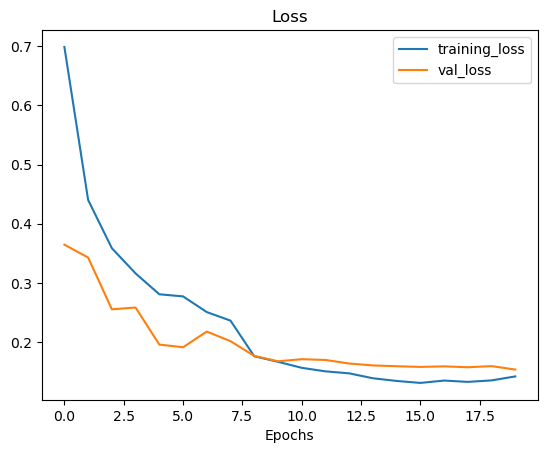

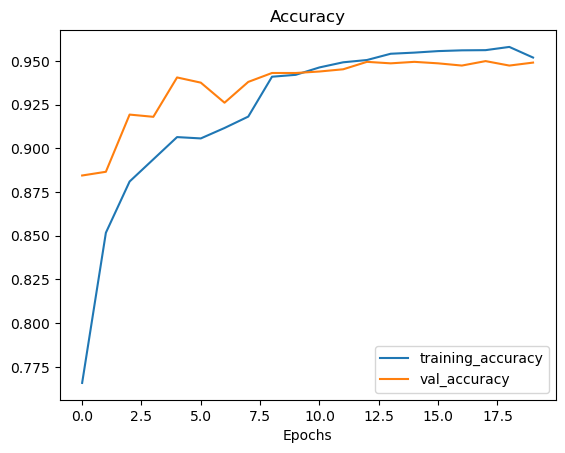

In [59]:
plot_loss_curves(ResNet101_history)

The learning curves look a little jumpy, but the dynamics look pretty good, there is a decrease in learning losses and an increase in testing accuracy.

# Model Evaluation

We use a set of test data to evaluate the accuracy of the model on new data

In [60]:
test_loss, test_accuracy = ResNet101_model.evaluate(test_data, verbose=0)

In [61]:
print("Test Loss: {:.5f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Test Loss: 0.17528
Test Accuracy: 94.46%


Given the limited data set, we obtained a good accuracy of 97%.

Let's look at the main classification metrics

In [62]:
pred_probs = ResNet101_model.predict(test_data, verbose=1)

74/74 [==============================] - 40s 518ms/step


In [63]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [64]:
y_labels = []
for images, labels in test_data.unbatch(): 
    y_labels.append(labels.numpy().argmax()) 
y_labels[:10] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Since the images in the test dataset were not shuffled, all the output labels correspond to the same class.

In [65]:
print('Classification Report \n')
target_names = class_names
print(classification_report(y_labels, pred_classes, target_names=target_names))

Classification Report 

              precision    recall  f1-score   support

     battery       0.99      0.94      0.96        95
  biological       0.96      0.97      0.96        99
   cardboard       0.96      0.94      0.95       234
     clothes       1.00      0.99      0.99       533
       glass       0.96      0.90      0.93       409
       metal       0.89      0.97      0.93       188
       paper       0.94      0.94      0.94       272
     plastic       0.90      0.87      0.88       253
       shoes       0.97      0.98      0.98       199
       trash       0.74      0.93      0.82        84

    accuracy                           0.94      2366
   macro avg       0.93      0.94      0.93      2366
weighted avg       0.95      0.94      0.95      2366



* The “Precision” column shows the percentage of correct predictions among all predictions for a particular class.
* The "Recall" column shows the percentage of images of a particular class that were predicted by the model to belong to that class.
* Column “F1” shows what percentage of model predictions were correct.
* The "Support" column shows how many images of each class were in the test dataset.

From the summary of metrics it is clear that the model classifies plastic worst of all, and best of all - things and various biological waste. However, despite the small data set, the model shows excellent performance in terms of Precision, Recall and F1 scores.

We visualize the error matrix to clearly see the correctness of class definitions

In [66]:
import itertools

In [67]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

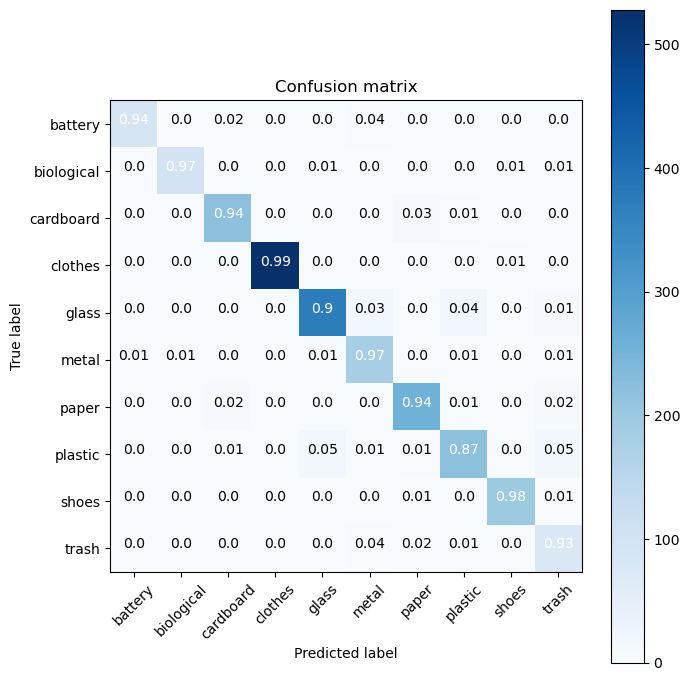

In [68]:
cm = confusion_matrix(y_labels, pred_classes)
plot_confusion_matrix(cm, class_names)

The rows of the matrix are responsible for the class predicted by the model, and the columns are for the actual class. From the error matrix, it is noticeable that in general the model’s errors are very small, although it sometimes incorrectly predicts categories, for example, it confuses plastic and glass.

Visualizing several model predictions

In [69]:
def pred_random_images(model_name, folder_path, class_names):
    plt.figure(figsize=(17, 10))
    for i in range(3):
        class_name = random.choice(class_names)
        filename = random.choice(os.listdir(folder_path + "/" + class_name))
        filepath = folder_path + "/" + class_name + "/" + filename
    
        img = tf.io.read_file(filepath)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])
     #  img = img/255.
        if i == 1:
            deploy_model_emission_tracker = EmissionsTracker()
            deploy_model_emission_tracker.start()
            pred_prob = model_name.predict(tf.expand_dims(img, axis=0), verbose=0)
            deploy_model_emissions: float = prepare_data_emission_tracker.stop()
            print(f"Deploy Model Carbon Emissions: {deploy_model_emissions} kg")
        else:
            pred_prob = model_name.predict(tf.expand_dims(img, axis=0), verbose=0)
            pred_class = class_names[pred_prob.argmax()] 

  # Plot the image(s)
        plt.subplot(1, 3, i+1)
        plt.imshow(img/255.)
        if class_name == pred_class: 
            title_color = "g"
        else:
            title_color = "r"
        plt.title(f"Class: {class_name},\n Pred: {pred_class},\n Prob: {pred_prob.max():.2f}", c=title_color)
        plt.axis(False);

[codecarbon INFO @ 01:10:52] [setup] RAM Tracking...
[codecarbon INFO @ 01:10:52] [setup] GPU Tracking...
[codecarbon INFO @ 01:10:52] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 01:10:52] [setup] CPU Tracking...
[codecarbon WARNING @ 01:10:52] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 01:10:53] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 01:10:53] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 01:10:53] >>> Tracker's metadata:
[codecarbon INFO @ 01:10:53]   Platform system: Linux-5.15.133+-x86_64-with-glibc2.35
[codecarbon INFO @ 01:10:53]   Python version: 3.10.10
[codecarbon INFO @ 01:10:53]   CodeCarbon version: 2.3.2
[codecarbon INFO @ 01:10:53]   Available RAM : 31.358 GB
[codecarbon INFO @ 01:10:53]   CPU count: 4
[codecarbon INFO @ 01:10:53]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 01:10:53]   GPU

Deploy Model Carbon Emissions: 0.09232328358028 kg


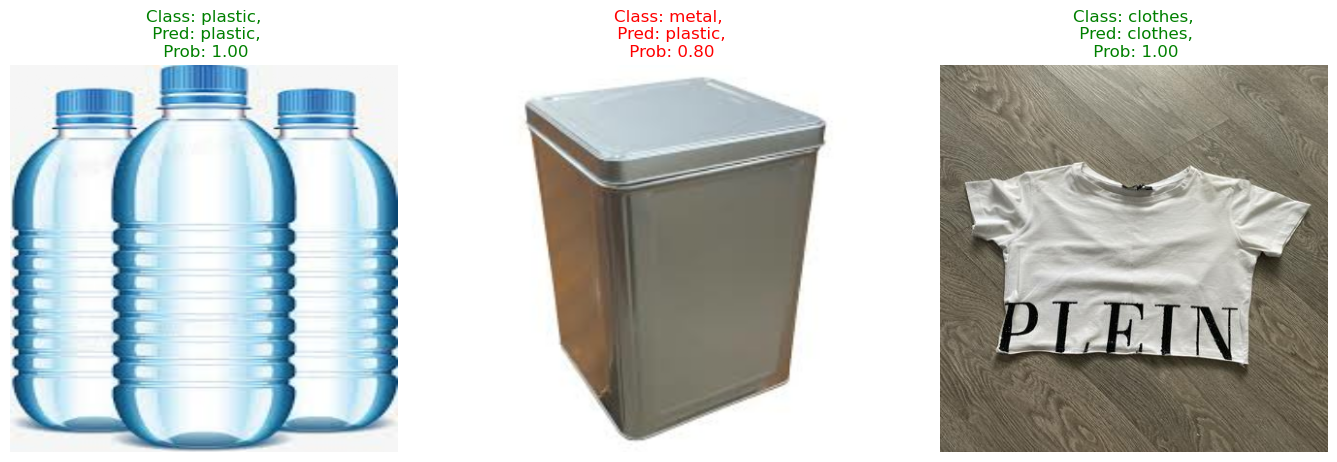

In [70]:
pred_random_images(ResNet101_model, test_path, class_names)

In [71]:
import pickle
pickle.dump(ResNet101_model,open("ResNet101_model.h5","wb"))

In [72]:
ls ../working

ResNet101.h5        data/                      logs/
ResNet101_model.h5  emissions.csv              logs.zip
__notebook__.ipynb  garbage-classification.h5  runs/
